You can also run this with the colab notebook: https://colab.research.google.com/drive/1CYY7Do854E7BLQCwkBZR2BhhEmO4Llmt?usp=sharing

# Deep Art Challenge - part 1 - The Bob Ross DCGAN
AI Impact Lab, Örebro University

## This is a Jupyter Notebook

A Jupyter Notebook is a great tool for creating interactive code tutorials. Runnable code is mixed with instructive text and explanations of what's going on. Put the mouse cursor in a code cell and press the play button to the left, or Ctrl-Enter, to execute it. An asterisc will be shown to the left of the cell when it is running. When finished it will show a sequenced number. If the code generates any output it will be shown below the code cell. Output can be anything from text and error reports to images, movies, and other media.

## Enable GPU support

Training a neural network involves heavy matrix computation. Using a GPU for this will speed up the process compared to using a regular CPU. On Kaggle you have 30 hours free GPU access per month. This is how you enable it:

* Find *Settings* in the sidebar.
* Select GPU as *Accelerator*. (Requires phone verification by SMS.)
* Wait for Kaggle to reconfigure and restart your session.

## Train your DCGAN

Completing this part of the challange is as easy as to run all code cells one by one. You can stop execution at any time by clicking *Cancel run* in the upper toolbar. If you get errors complaining about full disc space, you can start fresh by restarting the session by clicking the rotating arrows button in the toolbar. Don't be afraid to changing hyperparameters or tweaking the code to try and improve your results. You can always start anew by saving a new copy of the project template if you end up with lots of errors and can't find your way back to a working application.

Good luck!

### 1. Application setup

To make this notebook easier to read, most code has been put in a module called *dcgan*, that we import to the project. Implementation details has been abstracted away since they are beyond the scope of this challenge. But if you know a little Python you are more than welcome to take a look at the code to see what's going on under the hood. The implementation is far from optimal and you are more than welcome to improve it.

We also define a file path to where our image data is. You can find this folder in the sidebar.

In [1]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plot
import time

from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, ReLU, LeakyReLU, Dropout, UpSampling2D, Activation
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras import Sequential

# Default values
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_CHANNELS = 3
LEAKY_RELU_SLOPE = 0.2
DROPOUT_RATE = 0.5
WEIGHT_INIT_STD = 0.02
WEIGHT_INIT_MEAN = 0.0
LEARNING_RATE_INITIAL_D = 0.0002
LEARNING_RATE_INITIAL_G = 0.0002
NOISE_ARRAY_DIMENSION = 128
BATCH_SIZE = 16
LABEL_SMOOTHING = True
LABEL_NOISE = True

# TODO: try if loss_type is possible, refactor or remove.
# TODO: expose more hyperparams

class DCGAN():

    def __init__(self, hyperparameters):
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

        self.hyperparms = {
            "leaky_relu_slope": LEAKY_RELU_SLOPE,
            "dropout_rate": DROPOUT_RATE,
            "weight_init_std": WEIGHT_INIT_STD,
            "weight_init_mean": WEIGHT_INIT_MEAN,
            "learning_rate_initial_discriminator": LEARNING_RATE_INITIAL_D,
            "learning_rate_initial_generator": LEARNING_RATE_INITIAL_G,
            "noise_array_dimensions": NOISE_ARRAY_DIMENSION,
            "batch_size": BATCH_SIZE,
            "label_smoothing": LABEL_SMOOTHING,
            "label_noise": LABEL_NOISE
        }
        self.hyperparms.update(hyperparameters)

    def train(self, dataset, generator, discriminator, output_dir=".", epochs=50, save_every_x_results=40):
        noise_dim = self.hyperparms["noise_array_dimensions"]
        batch_size = self.hyperparms["batch_size"]
        lr_initial_g = self.hyperparms["learning_rate_initial_generator"]
        lr_initial_d = self.hyperparms["learning_rate_initial_discriminator"]

        # reused seed for plotting comparable images
        num_examples_to_generate = 5
        seed = tf.random.normal([num_examples_to_generate, noise_dim])

        generator_optimizer = tf.keras.optimizers.Adam(learning_rate=tf.Variable(lr_initial_g), beta_1=0.5)
        discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=tf.Variable(lr_initial_d), beta_1=0.5)

        checkpoint_prefix = os.path.join(output_dir, "ckpt")
        checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                         discriminator_optimizer=discriminator_optimizer,
                                         generator=generator,
                                         discriminator=discriminator)

        all_g_loss = np.array([])
        all_d_loss = np.array([])

        for epoch in range(epochs):
            epoch_g_loss = []
            epoch_d_loss = []

            start = time.time()
            global_step = 0

            for image_batch in dataset:
                g_loss, d_loss = self.train_step(
                    generator,
                    generator_optimizer,
                    discriminator,
                    discriminator_optimizer,
                    image_batch,
                    batch_size,
                    noise_dim)

                global_step = global_step + 1
                epoch_g_loss.append(g_loss)
                epoch_d_loss.append(d_loss)
                all_g_loss = np.append(all_g_loss, np.array([epoch_g_loss]))
                all_d_loss = np.append(all_d_loss, np.array([epoch_d_loss]))

            if (epoch + 1) % save_every_x_results == 0 or epoch == 0:
                DCGAN.plot_losses(epoch_g_loss, epoch_d_loss, all_g_loss, all_d_loss, epoch + 1)
                DCGAN.generate_and_save_images(generator, epoch + 1, seed, output_dir)
                checkpoint.save(file_prefix = checkpoint_prefix)

            print("Epoch: {} computed for {} sec".format(epoch + 1, time.time() - start))
            print("Generator loss mean: ", np.mean(epoch_g_loss)," std: ", np.std(epoch_g_loss))
            print("Discriminator loss mean: ", np.mean(epoch_d_loss)," std: ", np.std(epoch_d_loss))

        DCGAN.generate_and_save_images(generator, epochs, seed, output_dir)
        checkpoint.save(file_prefix = checkpoint_prefix)

        print("Training completed.")

    def train_step(
            self,
            generator,
            generator_optimizer,
            discriminator,
            discriminator_optimizer,
            real_images, 
            batch_size, 
            noise_dim,
            loss_type="gan"):
        label_smoothing = self.hyperparms["label_smoothing"]
        label_noise = self.hyperparms["label_noise"]

        noise = tf.random.normal([batch_size, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)

            real_output = discriminator(real_images, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(
                real_output,
                fake_output,
                loss_type,
                apply_label_smoothing=label_smoothing)

            disc_loss = self.discriminator_loss(
                real_output,
                fake_output,
                loss_type,
                apply_label_smoothing=label_smoothing,
                label_noise=label_noise)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables))

        return gen_loss, disc_loss

    @staticmethod
    def plot_losses(epoch_g_loss, epoch_d_loss, all_g_loss, all_d_loss, epoch):
        plot.figure(figsize=(10, 5))
        plot.title("Epoch loss - EPOCH {}".format(epoch))
        plot.plot(epoch_g_loss, label="Generator")
        plot.plot(epoch_d_loss, label="Discriminator")
        plot.xlabel("Iterations")
        plot.ylabel("Loss")
        plot.legend()
        plot.show()

        plot.figure(figsize=(10, 5))
        plot.plot(np.arange(len(all_g_loss)), all_g_loss, label="Generator")
        plot.plot(np.arange(len(all_d_loss)), all_d_loss, label="Discriminator")
        plot.legend()
        plot.title("All epochs loss")
        plot.show()

    @staticmethod
    def generate_and_save_images(model, epoch, seed, output_dir):
        # Training is set to false to run in inference mode.
        predictions = model(seed, training=False)
        predictions_count = predictions.shape[0]

        for i in range(predictions_count):
            plot.figure(figsize=(3, 3))
            plot.imshow((predictions[i, :, :, :] * 127.5 + 127.5) / 255.)
            plot.axis("off")
            plot.savefig(output_dir + "/image-{}-at-epoch-{:05d}.png".format(i, epoch))
            plot.show()

    # Label smoothing -- technique from GAN hacks, instead of assigning
    # 1/0 as class labels, we assign a random integer in range [0.7, 1.0]
    # for positive class and [0.0, 0.3] for negative class.
    @staticmethod
    def smooth_positive_labels(y):
        rng = np.random.default_rng()
        return y - 0.3 * rng.random(y.shape)

    @staticmethod
    def smooth_negative_labels(y):
        rng = np.random.default_rng()
        return y + rng.random(y.shape) * 0.3

    # Instance noise -- randomly flip some labels
    @staticmethod
    def noisy_labels(y, p_flip):
        # determine the number of labels to flip
        n_select = int(p_flip * int(y.shape[0]))
        # choose labels to flip
        flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)

        op_list = []
        # invert the labels in place
        #y_np[flip_ix] = 1 - y_np[flip_ix]
        for i in range(int(y.shape[0])):
            if i in flip_ix:
                op_list.append(tf.subtract(1, y[i]))
            else:
                op_list.append(y[i])

        outputs = tf.stack(op_list)
        return outputs

    def discriminator_loss(self, real_output, fake_output, loss_func, apply_label_smoothing=True, label_noise=True):
        real_labels = tf.ones_like(real_output)
        fake_labels = tf.zeros_like(fake_output)

        if label_noise:
            real_labels = DCGAN.noisy_labels(real_labels, 0.05)
            fake_labels = DCGAN.noisy_labels(fake_labels, 0.05)

        if apply_label_smoothing:
            real_labels = DCGAN.smooth_positive_labels(real_labels)
            fake_labels = DCGAN.smooth_negative_labels(fake_labels)

            # if loss_func == 'gan':
        real_loss = self.cross_entropy(real_labels, real_output)
        fake_loss = self.cross_entropy(fake_labels, fake_output)

        total_loss = real_loss + fake_loss
        return total_loss

        #     else:
        #         if loss_func == 'ralsgan':
        #             return (tf.reduce_mean(tf.math.square(real_output_smooth - tf.math.reduce_mean(fake_output_smooth) - tf.ones_like(real_output_smooth)))
        #     + tf.math.reduce_mean(tf.math.square(fake_output_smooth - tf.math.reduce_mean(real_output_smooth) + tf.ones_like(fake_output_smooth)))) / 2.
        #         elif loss_func == 'rasgan':
        #             avg_fake_logit = tf.math.reduce_mean(fake_output_smooth)
        #             avg_real_logit = tf.math.reduce_mean(real_output_smooth)
        #             D_r_tilde = tf.nn.sigmoid(real_output_smooth - avg_fake_logit)
        #             D_f_tilde = tf.nn.sigmoid(fake_output_smooth - avg_real_logit)
        #             total_loss = - tf.math.reduce_mean(tf.math.log(
        #                 D_r_tilde + 1e-14)) - tf.math.reduce_mean(tf.math.log(1 - D_f_tilde + 1e-14))
        #             return total_loss
        #         elif loss_func == 'rahinge':
        #             real_loss = tf.math.reduce_mean(tf.nn.relu(tf.ones_like(real_output_smooth) - (real_output_smooth - tf.math.reduce_mean(fake_output_smooth))))
        #             fake_loss = tf.math.reduce_mean(tf.nn.relu(tf.ones_like(fake_output_smooth) + (fake_output_smooth - tf.math.reduce_mean(real_output_smooth))))
            # total_loss = real_loss + fake_loss
            # return total_loss

    def generator_loss(self, real_output, fake_output, loss_func, apply_label_smoothing=True):
        fake_labels = tf.ones_like(fake_output)
        if apply_label_smoothing:
            fake_labels = DCGAN.smooth_positive_labels(fake_labels)

            # if loss_func == 'gan':
        return self.cross_entropy(fake_labels, fake_output)
        #     else:
        #         if loss_func == 'ralsgan':
        #             return (tf.reduce_mean(tf.square(real_output - tf.reduce_mean(fake_output_smooth) + tf.ones_like(real_output)))
        #     + tf.reduce_mean(tf.square(fake_output_smooth - tf.reduce_mean(real_output) - tf.ones_like(fake_output_smooth)))) / 2.
        #         elif loss_func == 'rasgan':
        #             avg_fake_logit = tf.reduce_mean(fake_output_smooth)
        #             avg_real_logit = tf.reduce_mean(real_output)
        #             D_r_tilde = tf.nn.sigmoid(real_output - avg_fake_logit)
        #             D_f_tilde = tf.nn.sigmoid(fake_output_smooth - avg_real_logit)
        #             total_loss = - tf.reduce_mean(tf.log(
        #                 D_f_tilde + 1e-14)) - tf.reduce_mean(tf.log(1 - D_r_tilde + 1e-14))
        #             return total_loss
        #         elif loss_func == 'rahinge':
        #             fake_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(fake_output_smooth) - (fake_output_smooth - tf.reduce_mean(real_output))))
        #             real_loss = tf.reduce_mean(tf.nn.relu(tf.ones_like(real_output) + (real_output - tf.reduce_mean(fake_output_smooth))))
        #             loss = fake_loss + real_loss
        #             return loss

    def upsampling(self, model, filters, kernel_size=(5, 5), strides=(1, 1)):
        model.add(UpSampling2D(size=(2, 2)))
        model.add(Conv2D(filters, kernel_size, strides=strides, padding="same"))
        model.add(Activation("tanh"))
        return model

    def weight_initializer(self):
        weight_init_std = self.hyperparms["weight_init_std"]
        weight_init_mean = self.hyperparms["weight_init_mean"]
        return TruncatedNormal(stddev=weight_init_std, mean=weight_init_mean, seed=42)

    def transposed_conv(self, model, out_channels, ksize, stride_size, padding_type="same"):
        initializer = self.weight_initializer()
        model.add(Conv2DTranspose(
            out_channels,
            (ksize, ksize),
            strides=(stride_size, stride_size),
            padding=padding_type, 
            kernel_initializer=initializer,
            use_bias=False))
        model.add(BatchNormalization())
        model.add(ReLU())
        return model

    def conv(self, model, out_channels, ksize, stride_size, leaky_relu_slope, padding_type="same"):
        initializer = self.weight_initializer()
        model.add(Conv2D(
            out_channels, 
            (ksize, ksize), 
            strides=(stride_size, stride_size), 
            padding=padding_type,
            kernel_initializer=initializer))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=leaky_relu_slope))
        return model

    def build_generator(self):
        initializer = self.weight_initializer()
        noise_dim = self.hyperparms["noise_array_dimensions"]
        dropout_rate = self.hyperparms["dropout_rate"]

        # noise_dim * 1 (noise)     project and reshape
        # 4 * 4 * 1024              conv 1
        # 8 * 8 * 512               conv 2
        # 16 * 16 * 256             conv 3
        # 32 * 32 * 128             conv 4
        # 64 * 64 * 3

        model = Sequential()
        model.add(Dense(4 * 4 * 1024, input_shape=(noise_dim,), kernel_initializer=initializer))
        model.add(Reshape((4, 4, 1024)))

        model = self.upsampling(model, 256, (5, 5))
        model.add(Dropout(dropout_rate))
        model = self.upsampling(model, 128, (5, 5))
        model.add(Dropout(dropout_rate))
        model = self.upsampling(model, 64, (3, 3))
        model.add(Dropout(dropout_rate))
        model = self.upsampling(model, 32, (3, 3))

        model.add(Dense(IMAGE_CHANNELS, activation="tanh", kernel_initializer=initializer))
        return model

    def build_discriminator(self):
        leaky_relu_slope = self.hyperparms["leaky_relu_slope"]
        dropout_rate = self.hyperparms["dropout_rate"]
        initializer = self.weight_initializer()

        model = Sequential()

        model.add(Conv2D(
            64,
            (4, 4),
            strides=(1, 1),
            padding="same",
            use_bias=False,
            input_shape=[IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS],
            kernel_initializer=initializer))
        model.add(LeakyReLU(alpha=leaky_relu_slope))

        model.add(Dropout(dropout_rate))
        model = self.conv(model, 64, 4, 2, leaky_relu_slope)
        model.add(Dropout(dropout_rate))
        model = self.conv(model, 128, 4, 2, leaky_relu_slope)
        model.add(Dropout(dropout_rate))
        model = self.conv(model, 256, 4, 2, leaky_relu_slope)

        model.add(Flatten())
        model.add(Dense(1, activation="sigmoid"))
        return model

    def create_dataset(self, image_dir):
        
        image_height = IMAGE_HEIGHT
        image_width = IMAGE_WIDTH
        image_channels = IMAGE_CHANNELS
        batch_size = self.hyperparms["batch_size"]

        image_list = os.listdir(image_dir)
        image_count = len(image_list)
        print('img count: ',image_count)
        training_data = np.empty((image_count, image_height, image_width, image_channels))

        plot.figure(figsize=(10, 10))

        index = 0
        for filename in image_list:
            path = os.path.join(image_dir, filename)
            original = Image.open(path)

            image = original.resize((image_width, image_height), Image.BICUBIC)
            training_data[index,:,:,:] = np.asarray(image)
            index += 1

            if index <= 30:
                plot.xticks([])
                plot.yticks([])
                plot.grid(False)
                plot.subplot(5, 6, index)
                plot.imshow(image)

        plot.show()

        # normalize pixel value range to [-1, 1]
        training_data = (training_data - 127.5) / 127.5

        tensor = tf.cast(training_data, "float32")

        return tf.data.Dataset.from_tensor_slices(tensor).shuffle(10000).batch(batch_size, drop_remainder=True)

In [2]:

#%pip install gdown

In [3]:

# import gdown


# url = 'https://drive.google.com/uc?id=1NjJazM-fgg5WB2IAS-oBc0By7PwaSAsU'

# output='imgs.zip'
# gdown.download(url,  output, quiet=False)

In [4]:

# !mkdir imgs
# !unzip -d imgs/ imgs.zip

In [5]:
# !git clone https://github.com/aoertel/bob-ross-challenge-wasp.git

In [6]:
# !rm -rf imgs
# !mkdir imgs
# !cp bob-ross-challenge-wasp/augmented/*.png imgs/
# !cp bob-ross-challenge-wasp/curated/*.png imgs/
IMAGE_DIR = "./augmented"

### 2. Define hyperparameters

In machine learning we separate parameters from hyperparameters. Hyperparameters are all parameters that are set before starting the training process. The other parameters or weights are learnt automatically in the training process. Different settings of the hyperparameters can make a huge effect on the outcome of the training.

In [7]:
# Our first try parameters
hyperparameters = {
    "leaky_relu_slope": 0.2,
    "dropout_rate": 0.5,
    "weight_init_std": 0.5,
    "weight_init_mean": 0.0,
    "learning_rate_initial_discriminator": 0.001,
    "learning_rate_initial_generator": 0.01,
    "noise_array_dimensions": 50,
    "batch_size": 16,
    "label_smoothing": True,
    "label_noise": True
}

# Modified default parameters
hyperparameters = {
    "leaky_relu_slope": 0.2,
    "dropout_rate": 0.5,
    "weight_init_std": 0.1,
    "weight_init_mean": 0.0,
    "learning_rate_initial_discriminator": 0.01,
    "learning_rate_initial_generator": 0.01,
    "noise_array_dimensions": 128,
    "batch_size": 128,
    "label_smoothing": True,
    "label_noise": True
}
dcgan = DCGAN(hyperparameters)

### 3. Create training dataset

The images in the input folder are preprocessed and stored in a binary format that the training algorithm can work efficiently with. Each image is also downsampled to 64 by 64 pixels to reduce the training time. This code cell should output a few example images from the training dataset. 

img count:  2712


/home/x_huzha/.conda/envs/tf2_8/lib/python3.7/site-packages/ipykernel_launcher.py:388: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.


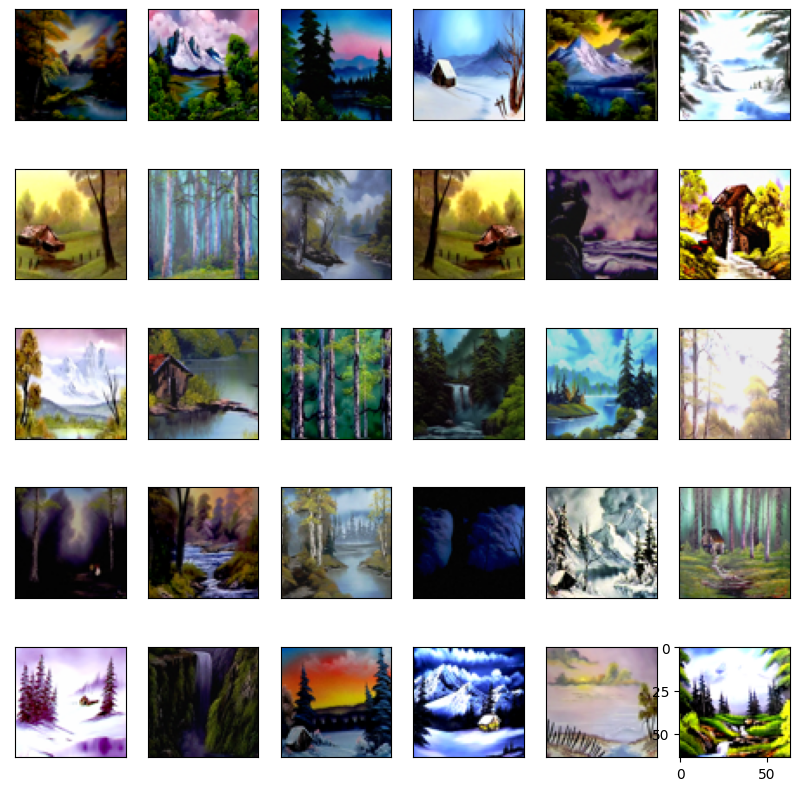

2022-08-24 00:01:20.067471: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-24 00:01:22.997119: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2022-08-24 00:01:23.003551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38420 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2022-08-24 00:01:23.005767: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/devi

In [8]:
dataset = dcgan.create_dataset(IMAGE_DIR)

### 4. Generator and Discriminator

The DCGAN architecture is basically two neural networks competing against each other in the training process. The discriminator takes an image as input and is trained to predict if the image is real or fake. Real in this case means being part of the dataset we trained the model on. The generator takes some noise as input and is trained to fool the discriminator by generating images that resemble the images of the training dataset to a level that the discriminator can not tell them apart from real images.

In [9]:
generator = dcgan.build_generator()
discriminator = dcgan.build_discriminator()

### 5. The training process

To start training we pass the dataset, generator and discriminator to the *train* function. We also specify how many epochs we want the process to repeat, and we tell it to plot and display generated images for every x epoch. Doing this at every iteration would soon fill the disc space we are allowed to use on Kaggle.

When training starts both networks are equally bad. The discriminator predictions will be random and the generator will produce random noise images. As the training goes on both networks should become better at their tasks because the results are fed back in the training loop and progress in the generator should trigger progress in the discriminator and vice versa.

2022-08-24 00:01:25.028140: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-08-24 00:01:26.346711: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


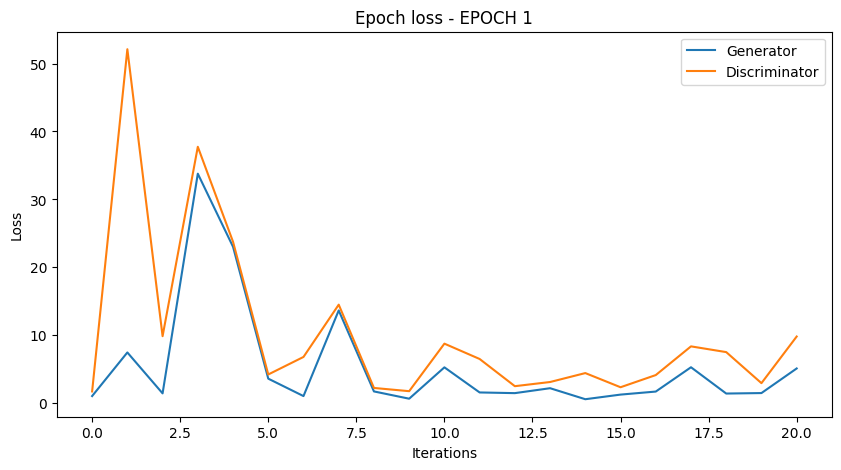

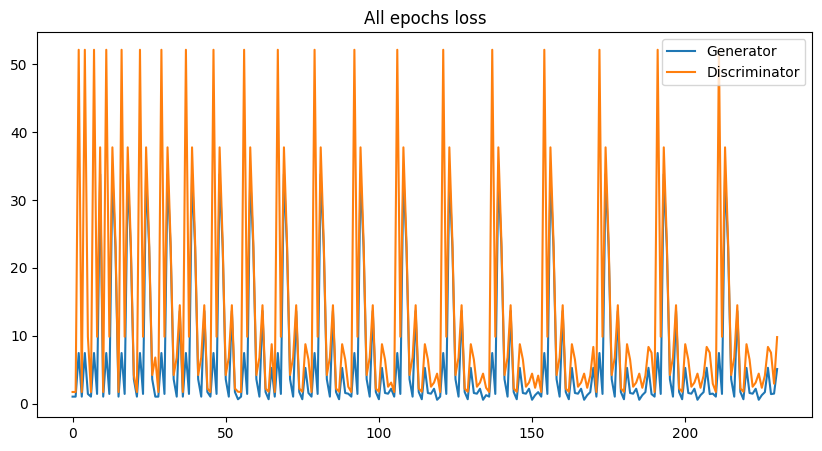

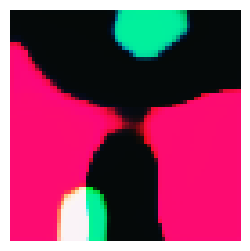

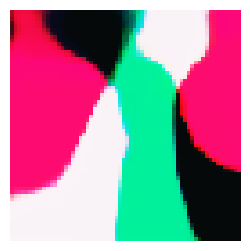

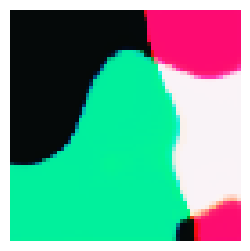

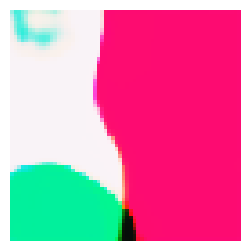

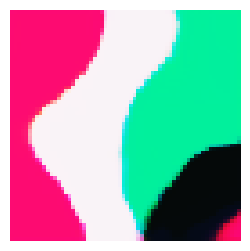

Epoch: 1 computed for 12.841868162155151 sec
Generator loss mean:  5.465373  std:  8.186155
Discriminator loss mean:  10.244269  std:  12.5214205
Epoch: 2 computed for 2.817723274230957 sec
Generator loss mean:  2.357951  std:  2.7730896
Discriminator loss mean:  4.528068  std:  2.7149622
Epoch: 3 computed for 2.8013007640838623 sec
Generator loss mean:  1.7247846  std:  0.6991322
Discriminator loss mean:  2.6085942  std:  1.0003568
Epoch: 4 computed for 2.8062291145324707 sec
Generator loss mean:  1.7829657  std:  1.0837926
Discriminator loss mean:  2.3595886  std:  0.87956625
Epoch: 5 computed for 2.806582450866699 sec
Generator loss mean:  1.1863822  std:  0.42750064
Discriminator loss mean:  1.6351603  std:  0.3048724
Epoch: 6 computed for 2.8029708862304688 sec
Generator loss mean:  1.0983168  std:  0.34203336
Discriminator loss mean:  1.5277661  std:  0.233309
Epoch: 7 computed for 2.8052892684936523 sec
Generator loss mean:  1.045725  std:  0.23224418
Discriminator loss mean:  1

Epoch: 56 computed for 2.8641507625579834 sec
Generator loss mean:  1.3265193  std:  0.14471659
Discriminator loss mean:  1.0710669  std:  0.026026549
Epoch: 57 computed for 2.8204345703125 sec
Generator loss mean:  1.3213311  std:  0.26305005
Discriminator loss mean:  1.1095054  std:  0.06985271
Epoch: 58 computed for 2.8157427310943604 sec
Generator loss mean:  1.3479735  std:  0.15320347
Discriminator loss mean:  1.0680833  std:  0.02866081
Epoch: 59 computed for 2.8337159156799316 sec
Generator loss mean:  1.3822222  std:  0.19113515
Discriminator loss mean:  1.0748736  std:  0.030901354
Epoch: 60 computed for 2.8262901306152344 sec
Generator loss mean:  1.3824444  std:  0.29641777
Discriminator loss mean:  1.0937662  std:  0.04679597
Epoch: 61 computed for 2.8263649940490723 sec
Generator loss mean:  1.3302534  std:  0.16351627
Discriminator loss mean:  1.0777425  std:  0.03151165
Epoch: 62 computed for 2.8060004711151123 sec
Generator loss mean:  1.3702271  std:  0.16770245
Discr

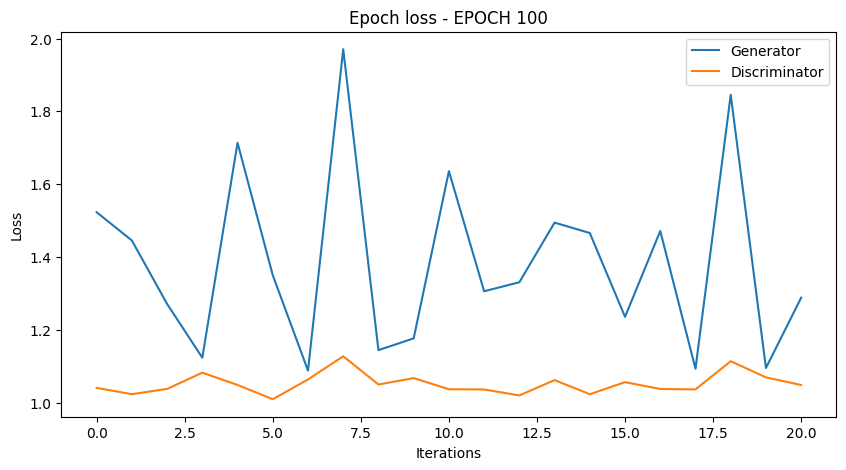

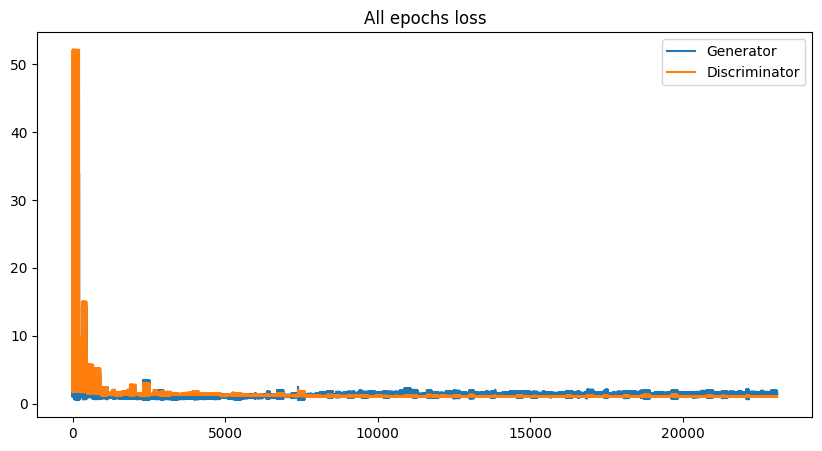

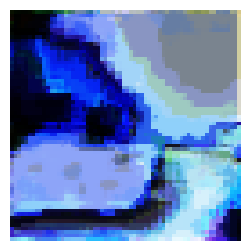

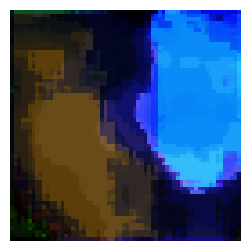

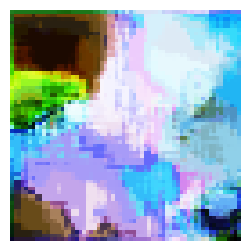

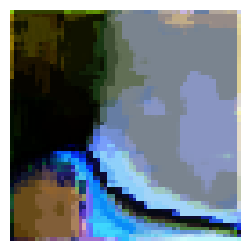

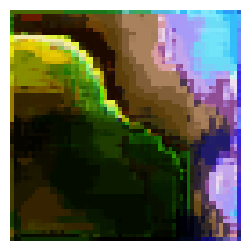

Epoch: 100 computed for 3.6233127117156982 sec
Generator loss mean:  1.3842273  std:  0.2445914
Discriminator loss mean:  1.0519832  std:  0.028458476
Epoch: 101 computed for 2.816546678543091 sec
Generator loss mean:  1.367034  std:  0.21934636
Discriminator loss mean:  1.0498648  std:  0.037182648
Epoch: 102 computed for 2.80731463432312 sec
Generator loss mean:  1.3885572  std:  0.13261119
Discriminator loss mean:  1.0304432  std:  0.024650708
Epoch: 103 computed for 2.8052425384521484 sec
Generator loss mean:  1.3999122  std:  0.26064172
Discriminator loss mean:  1.0526236  std:  0.050828118
Epoch: 104 computed for 2.817486524581909 sec
Generator loss mean:  1.3846968  std:  0.22272618
Discriminator loss mean:  1.0466703  std:  0.038767155
Epoch: 105 computed for 2.809565544128418 sec
Generator loss mean:  1.362858  std:  0.20686004
Discriminator loss mean:  1.0418445  std:  0.027333733
Epoch: 106 computed for 2.8178858757019043 sec
Generator loss mean:  1.3955035  std:  0.22827627

Epoch: 155 computed for 2.8206498622894287 sec
Generator loss mean:  1.3733312  std:  0.19397542
Discriminator loss mean:  1.0362244  std:  0.029610826
Epoch: 156 computed for 2.809349775314331 sec
Generator loss mean:  1.3782693  std:  0.20316374
Discriminator loss mean:  1.0307194  std:  0.02611893
Epoch: 157 computed for 2.8094093799591064 sec
Generator loss mean:  1.3839583  std:  0.2385006
Discriminator loss mean:  1.0373381  std:  0.034332864
Epoch: 158 computed for 2.817225694656372 sec
Generator loss mean:  1.3957336  std:  0.15628989
Discriminator loss mean:  1.0222604  std:  0.018372731
Epoch: 159 computed for 2.812643527984619 sec
Generator loss mean:  1.342319  std:  0.33606216
Discriminator loss mean:  1.0754114  std:  0.088191636
Epoch: 160 computed for 2.8210530281066895 sec
Generator loss mean:  1.3390028  std:  0.26485774
Discriminator loss mean:  1.0605836  std:  0.038837016
Epoch: 161 computed for 2.810676097869873 sec
Generator loss mean:  1.3797827  std:  0.2494920

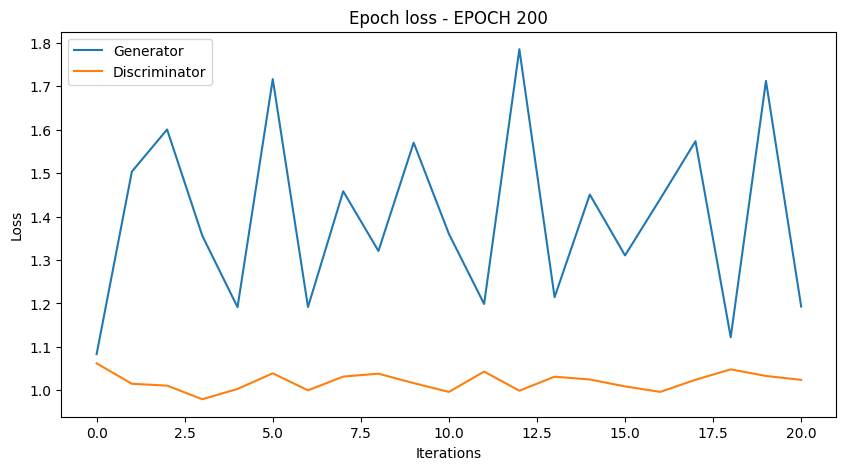

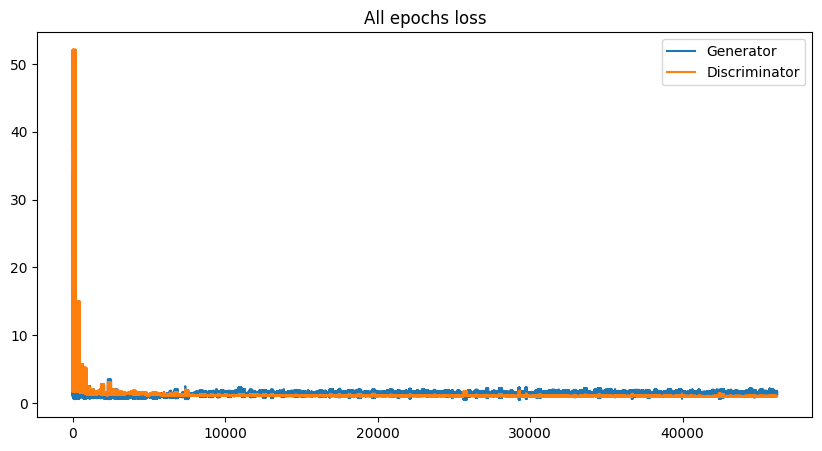

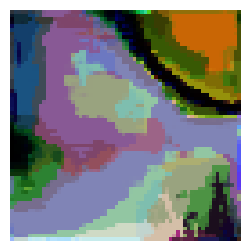

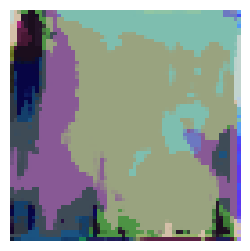

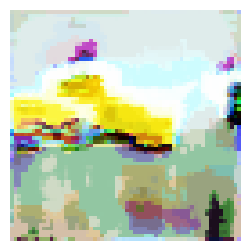

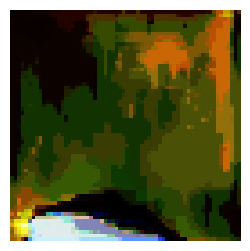

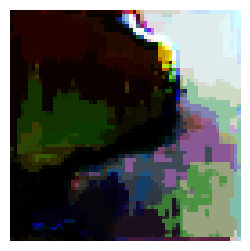

Epoch: 200 computed for 4.464266777038574 sec
Generator loss mean:  1.3977947  std:  0.20280592
Discriminator loss mean:  1.0202513  std:  0.020034218
Epoch: 201 computed for 2.8384604454040527 sec
Generator loss mean:  1.4198939  std:  0.1594973
Discriminator loss mean:  1.0036215  std:  0.0136953825
Epoch: 202 computed for 2.8194873332977295 sec
Generator loss mean:  1.4096353  std:  0.2466672
Discriminator loss mean:  1.0201734  std:  0.017280709
Epoch: 203 computed for 2.8167691230773926 sec
Generator loss mean:  1.4151068  std:  0.21715097
Discriminator loss mean:  1.0204833  std:  0.020875486
Epoch: 204 computed for 2.915642261505127 sec
Generator loss mean:  1.4189574  std:  0.27347153
Discriminator loss mean:  1.023061  std:  0.033449356
Epoch: 205 computed for 2.816547393798828 sec
Generator loss mean:  1.4087464  std:  0.21501958
Discriminator loss mean:  1.0153811  std:  0.016120506
Epoch: 206 computed for 2.816641330718994 sec
Generator loss mean:  1.4143465  std:  0.248633

Epoch: 255 computed for 2.814542293548584 sec
Generator loss mean:  1.3167825  std:  0.20913692
Discriminator loss mean:  1.0843937  std:  0.03843356
Epoch: 256 computed for 2.8146440982818604 sec
Generator loss mean:  1.3304539  std:  0.19190632
Discriminator loss mean:  1.0847359  std:  0.03622407
Epoch: 257 computed for 2.811429500579834 sec
Generator loss mean:  1.3278269  std:  0.1258528
Discriminator loss mean:  1.0619848  std:  0.025679598
Epoch: 258 computed for 2.8148114681243896 sec
Generator loss mean:  1.3376154  std:  0.14535296
Discriminator loss mean:  1.0701033  std:  0.02709836
Epoch: 259 computed for 2.811966896057129 sec
Generator loss mean:  1.3372812  std:  0.28828898
Discriminator loss mean:  1.0979286  std:  0.06309647
Epoch: 260 computed for 2.813636064529419 sec
Generator loss mean:  1.3325078  std:  0.14005299
Discriminator loss mean:  1.050863  std:  0.031918965
Epoch: 261 computed for 2.8228070735931396 sec
Generator loss mean:  1.3378385  std:  0.2247118
Di

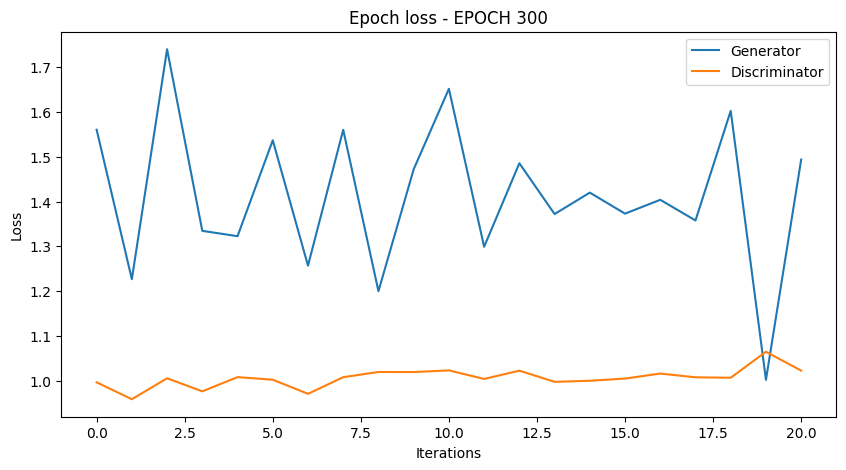

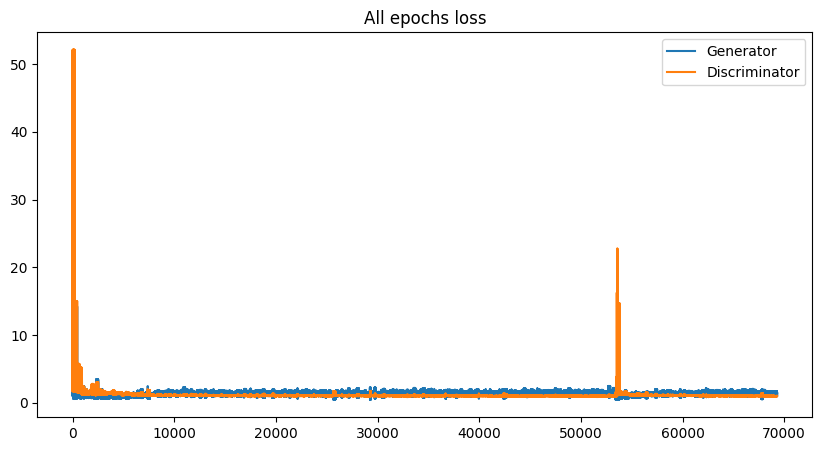

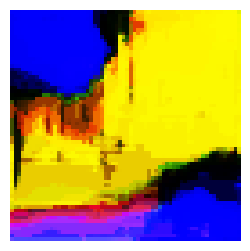

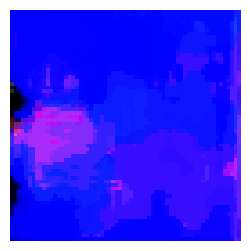

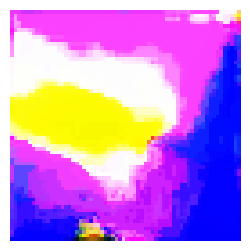

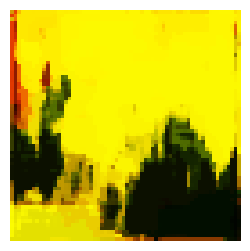

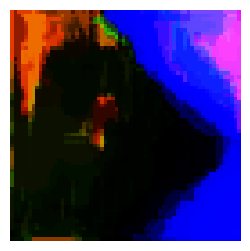

Epoch: 300 computed for 4.335622310638428 sec
Generator loss mean:  1.4129157  std:  0.1664902
Discriminator loss mean:  1.0059682  std:  0.021094834
Epoch: 301 computed for 2.81227707862854 sec
Generator loss mean:  1.2652167  std:  0.4368593
Discriminator loss mean:  1.1285492  std:  0.110938676
Epoch: 302 computed for 2.8088295459747314 sec
Generator loss mean:  1.3609008  std:  0.12673984
Discriminator loss mean:  1.0303988  std:  0.026001781
Epoch: 303 computed for 2.801300048828125 sec
Generator loss mean:  1.4059951  std:  0.14943278
Discriminator loss mean:  1.023237  std:  0.023209438
Epoch: 304 computed for 2.815159559249878 sec
Generator loss mean:  1.3968879  std:  0.15267283
Discriminator loss mean:  1.0161935  std:  0.024353312
Epoch: 305 computed for 2.8137152194976807 sec
Generator loss mean:  1.4155272  std:  0.23981509
Discriminator loss mean:  1.022496  std:  0.022915805
Epoch: 306 computed for 2.8156652450561523 sec
Generator loss mean:  1.4196215  std:  0.14911078


Epoch: 355 computed for 2.960707187652588 sec
Generator loss mean:  1.4291694  std:  0.23380972
Discriminator loss mean:  1.0127344  std:  0.023849124
Epoch: 356 computed for 2.814276933670044 sec
Generator loss mean:  1.4209385  std:  0.2473957
Discriminator loss mean:  1.0149939  std:  0.024819396
Epoch: 357 computed for 2.8282976150512695 sec
Generator loss mean:  1.3993258  std:  0.18110047
Discriminator loss mean:  1.0141404  std:  0.021092538
Epoch: 358 computed for 2.815133810043335 sec
Generator loss mean:  1.4164244  std:  0.19493279
Discriminator loss mean:  1.0093473  std:  0.02646171
Epoch: 359 computed for 2.8139853477478027 sec
Generator loss mean:  1.441738  std:  0.24391638
Discriminator loss mean:  1.0086329  std:  0.023751095
Epoch: 360 computed for 2.814627170562744 sec
Generator loss mean:  1.4350526  std:  0.20733497
Discriminator loss mean:  1.0139652  std:  0.022336498
Epoch: 361 computed for 2.8147804737091064 sec
Generator loss mean:  1.3966404  std:  0.2287449

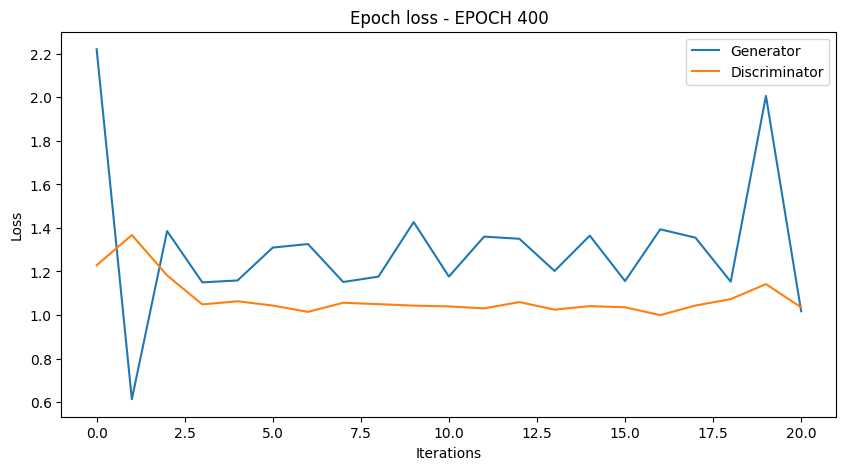

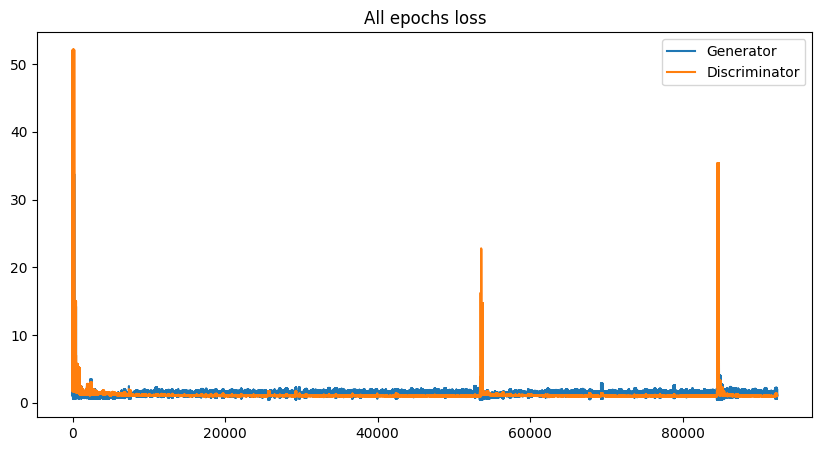

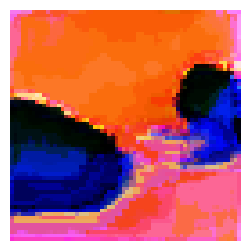

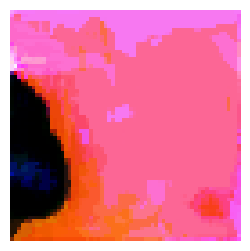

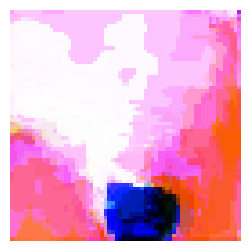

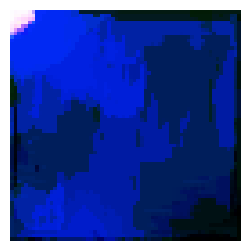

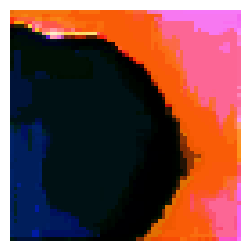

Epoch: 400 computed for 3.6920487880706787 sec
Generator loss mean:  1.3074896  std:  0.31559741
Discriminator loss mean:  1.077216  std:  0.08436438
Epoch: 401 computed for 2.817000389099121 sec
Generator loss mean:  1.4106302  std:  0.1740473
Discriminator loss mean:  1.0232328  std:  0.028401451
Epoch: 402 computed for 2.8242456912994385 sec
Generator loss mean:  1.4414532  std:  0.16743919
Discriminator loss mean:  1.0066692  std:  0.017794825
Epoch: 403 computed for 2.8154356479644775 sec
Generator loss mean:  1.4206183  std:  0.18733694
Discriminator loss mean:  1.0115472  std:  0.029077752
Epoch: 404 computed for 2.828639507293701 sec
Generator loss mean:  1.4019806  std:  0.17674461
Discriminator loss mean:  1.0151229  std:  0.014199902
Epoch: 405 computed for 2.8110873699188232 sec
Generator loss mean:  1.3872511  std:  0.27498743
Discriminator loss mean:  1.0289859  std:  0.031898305
Epoch: 406 computed for 2.8046865463256836 sec
Generator loss mean:  1.4321109  std:  0.22235

Epoch: 455 computed for 2.8102617263793945 sec
Generator loss mean:  1.3939165  std:  0.16564466
Discriminator loss mean:  1.0100658  std:  0.0156293
Epoch: 456 computed for 2.813638687133789 sec
Generator loss mean:  1.4165919  std:  0.12458576
Discriminator loss mean:  1.0037874  std:  0.01653784
Epoch: 457 computed for 2.8145406246185303 sec
Generator loss mean:  1.4390684  std:  0.27855375
Discriminator loss mean:  1.0183643  std:  0.023404803
Epoch: 458 computed for 2.8147716522216797 sec
Generator loss mean:  1.3991423  std:  0.2068855
Discriminator loss mean:  1.0101645  std:  0.019028038
Epoch: 459 computed for 2.8116421699523926 sec
Generator loss mean:  1.4413149  std:  0.17733394
Discriminator loss mean:  1.0003028  std:  0.015655993
Epoch: 460 computed for 2.82304048538208 sec
Generator loss mean:  1.4045753  std:  0.23766272
Discriminator loss mean:  1.0102026  std:  0.019241957
Epoch: 461 computed for 2.816934585571289 sec
Generator loss mean:  1.4371469  std:  0.1810379


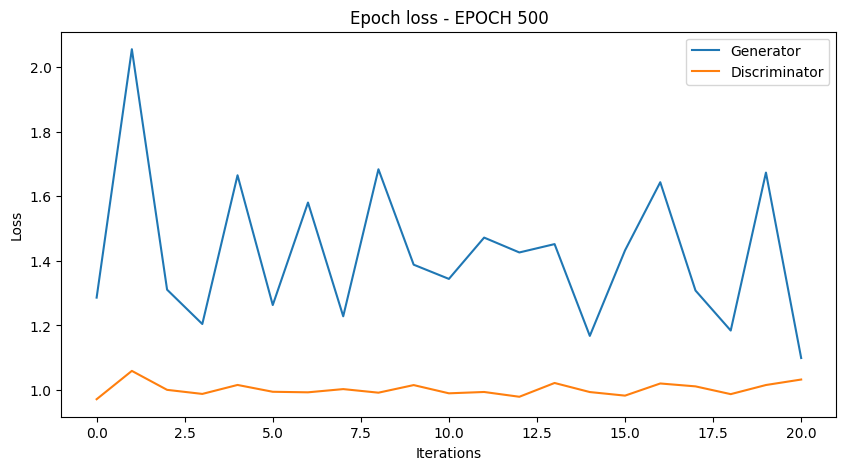

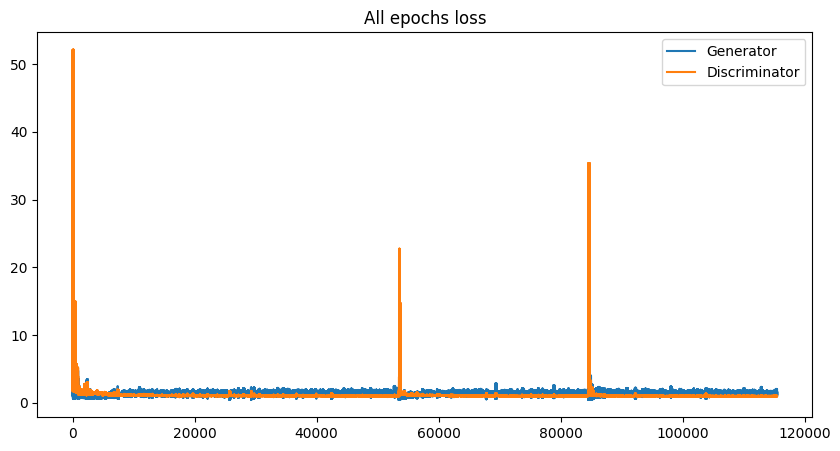

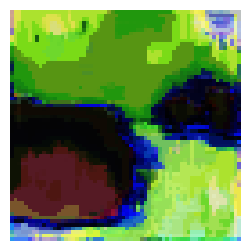

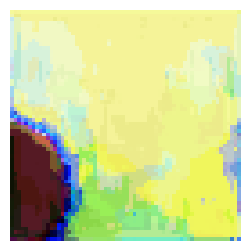

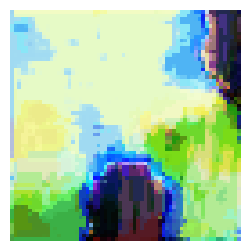

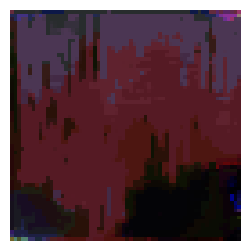

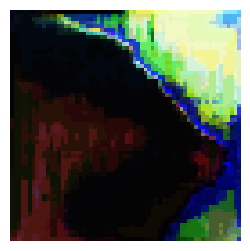

Epoch: 500 computed for 3.750152111053467 sec
Generator loss mean:  1.4221857  std:  0.22402717
Discriminator loss mean:  1.0032172  std:  0.019886443
Epoch: 501 computed for 2.813894033432007 sec
Generator loss mean:  1.4553789  std:  0.3102035
Discriminator loss mean:  1.018924  std:  0.038480934
Epoch: 502 computed for 2.8263063430786133 sec
Generator loss mean:  1.4197658  std:  0.21517721
Discriminator loss mean:  1.004722  std:  0.022818396
Epoch: 503 computed for 2.8126823902130127 sec
Generator loss mean:  1.420365  std:  0.11829904
Discriminator loss mean:  1.0026345  std:  0.0137879765
Epoch: 504 computed for 2.8042943477630615 sec
Generator loss mean:  1.4402918  std:  0.17577766
Discriminator loss mean:  1.006316  std:  0.019897971
Epoch: 505 computed for 2.8112947940826416 sec
Generator loss mean:  1.4070671  std:  0.18300281
Discriminator loss mean:  1.0022739  std:  0.017883826
Epoch: 506 computed for 2.8085527420043945 sec
Generator loss mean:  1.438104  std:  0.2271262

Epoch: 555 computed for 2.817288398742676 sec
Generator loss mean:  1.3967466  std:  0.17358086
Discriminator loss mean:  1.0181853  std:  0.016291887
Epoch: 556 computed for 2.820486307144165 sec
Generator loss mean:  1.4168622  std:  0.16513741
Discriminator loss mean:  1.0168746  std:  0.02709803
Epoch: 557 computed for 2.8206586837768555 sec
Generator loss mean:  1.4159217  std:  0.15267505
Discriminator loss mean:  1.014761  std:  0.02352731
Epoch: 558 computed for 2.8202717304229736 sec
Generator loss mean:  1.4412016  std:  0.18296462
Discriminator loss mean:  1.0100634  std:  0.023648819
Epoch: 559 computed for 2.8180031776428223 sec
Generator loss mean:  1.4079129  std:  0.13303553
Discriminator loss mean:  1.0115491  std:  0.023626888
Epoch: 560 computed for 2.8337526321411133 sec
Generator loss mean:  1.3839364  std:  0.20860401
Discriminator loss mean:  1.0240275  std:  0.02292823
Epoch: 561 computed for 2.8161895275115967 sec
Generator loss mean:  1.43033  std:  0.21530154

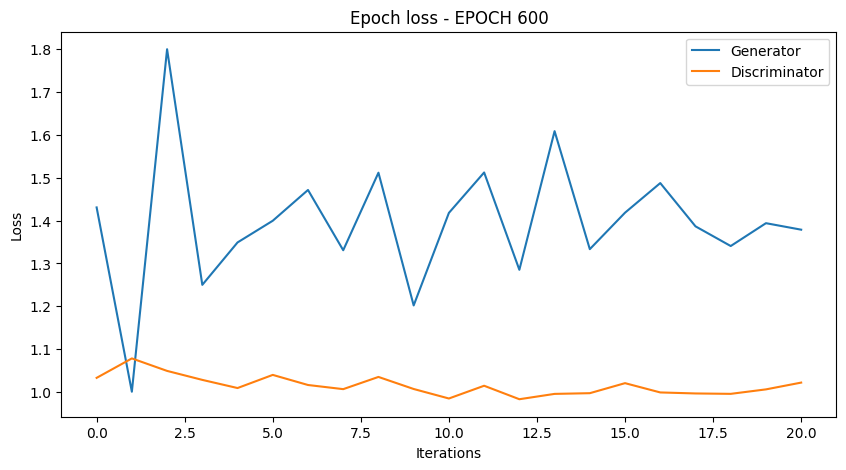

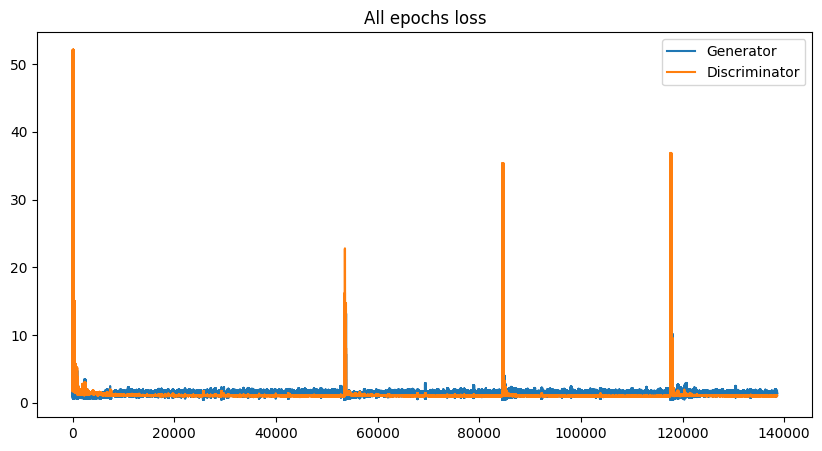

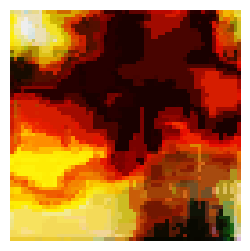

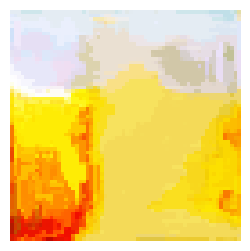

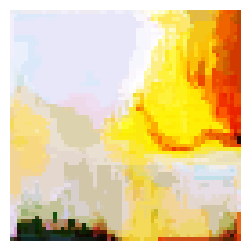

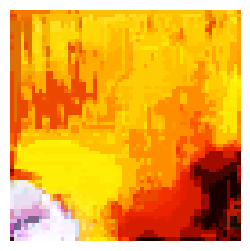

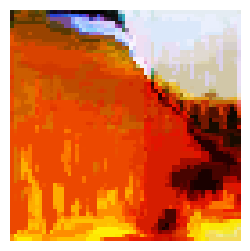

Epoch: 600 computed for 3.6670165061950684 sec
Generator loss mean:  1.3956965  std:  0.15335952
Discriminator loss mean:  1.0148001  std:  0.022518873
Epoch: 601 computed for 2.8167645931243896 sec
Generator loss mean:  1.4243395  std:  0.15220566
Discriminator loss mean:  1.0028143  std:  0.022519168
Epoch: 602 computed for 2.809471607208252 sec
Generator loss mean:  1.4505348  std:  0.16612615
Discriminator loss mean:  1.000338  std:  0.016949557
Epoch: 603 computed for 2.803494930267334 sec
Generator loss mean:  1.4065135  std:  0.16259864
Discriminator loss mean:  1.0078486  std:  0.017800804
Epoch: 604 computed for 2.8134312629699707 sec
Generator loss mean:  1.3890444  std:  0.1879362
Discriminator loss mean:  1.0162569  std:  0.023706045
Epoch: 605 computed for 2.818297863006592 sec
Generator loss mean:  1.4249839  std:  0.18895257
Discriminator loss mean:  1.0114409  std:  0.020257886
Epoch: 606 computed for 2.9726738929748535 sec
Generator loss mean:  1.423969  std:  0.207289

Epoch: 655 computed for 2.8254690170288086 sec
Generator loss mean:  1.4193344  std:  0.2033125
Discriminator loss mean:  1.0076  std:  0.02388955
Epoch: 656 computed for 2.8082032203674316 sec
Generator loss mean:  1.4326272  std:  0.21657257
Discriminator loss mean:  1.007709  std:  0.018571904
Epoch: 657 computed for 2.8157644271850586 sec
Generator loss mean:  1.415857  std:  0.22904593
Discriminator loss mean:  1.0050427  std:  0.018968413
Epoch: 658 computed for 2.815154552459717 sec
Generator loss mean:  1.4385017  std:  0.22617213
Discriminator loss mean:  1.0100713  std:  0.021067064
Epoch: 659 computed for 2.8160362243652344 sec
Generator loss mean:  1.4158655  std:  0.18871096
Discriminator loss mean:  1.0029323  std:  0.013557725
Epoch: 660 computed for 2.817108631134033 sec
Generator loss mean:  1.4130099  std:  0.1669752
Discriminator loss mean:  1.003198  std:  0.018406576
Epoch: 661 computed for 2.811981439590454 sec
Generator loss mean:  1.4312712  std:  0.21194445
Dis

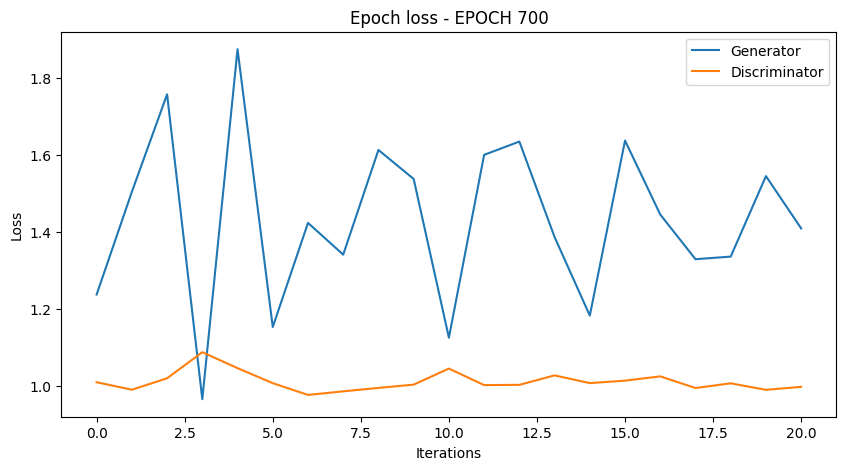

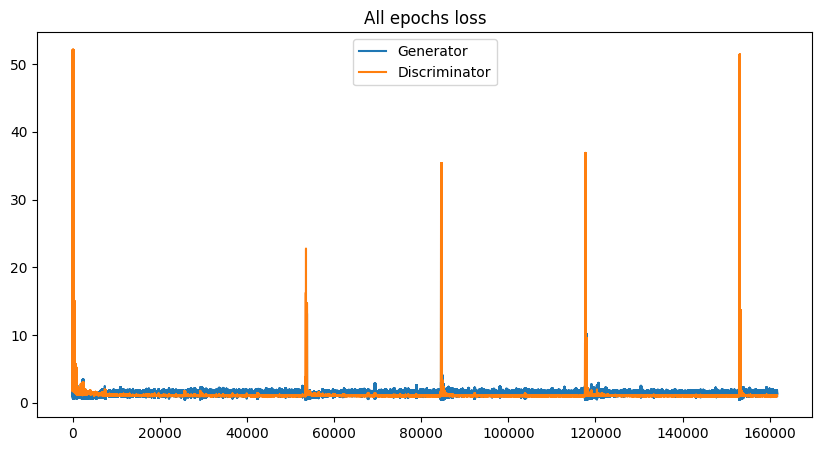

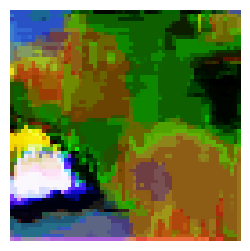

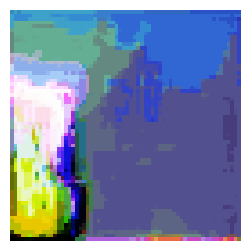

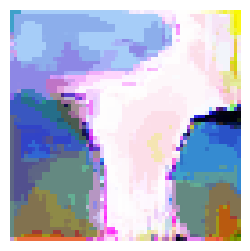

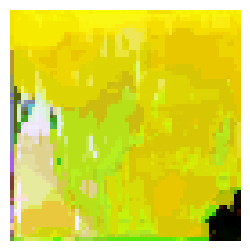

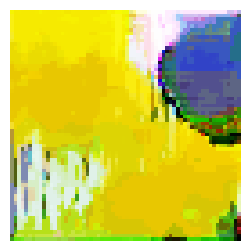

Epoch: 700 computed for 4.257303714752197 sec
Generator loss mean:  1.4297366  std:  0.217945
Discriminator loss mean:  1.0100256  std:  0.024390303
Epoch: 701 computed for 2.8119044303894043 sec
Generator loss mean:  1.4282062  std:  0.14568414
Discriminator loss mean:  0.999674  std:  0.01594039
Epoch: 702 computed for 2.815208673477173 sec
Generator loss mean:  1.4297862  std:  0.16746446
Discriminator loss mean:  1.0013498  std:  0.015530569
Epoch: 703 computed for 2.816826105117798 sec
Generator loss mean:  1.4362948  std:  0.1864704
Discriminator loss mean:  0.9971282  std:  0.022767814
Epoch: 704 computed for 2.810258626937866 sec
Generator loss mean:  1.4371843  std:  0.17532285
Discriminator loss mean:  1.0025023  std:  0.017270163
Epoch: 705 computed for 2.808868169784546 sec
Generator loss mean:  1.4421539  std:  0.20180525
Discriminator loss mean:  1.0092154  std:  0.023241136
Epoch: 706 computed for 2.8080031871795654 sec
Generator loss mean:  1.4066287  std:  0.16152175
D

Epoch: 755 computed for 2.816545009613037 sec
Generator loss mean:  1.4274316  std:  0.18749613
Discriminator loss mean:  1.0048355  std:  0.021182293
Epoch: 756 computed for 2.9132304191589355 sec
Generator loss mean:  1.4044985  std:  0.1681871
Discriminator loss mean:  1.0005039  std:  0.020683404
Epoch: 757 computed for 2.811113119125366 sec
Generator loss mean:  1.4114516  std:  0.11120373
Discriminator loss mean:  1.0016336  std:  0.019228306
Epoch: 758 computed for 2.8246500492095947 sec
Generator loss mean:  1.4047842  std:  0.09949869
Discriminator loss mean:  1.0017236  std:  0.01737321
Epoch: 759 computed for 2.8179121017456055 sec
Generator loss mean:  1.4336227  std:  0.21756345
Discriminator loss mean:  1.0105586  std:  0.031330355
Epoch: 760 computed for 2.82047438621521 sec
Generator loss mean:  1.4149746  std:  0.103016555
Discriminator loss mean:  1.0001763  std:  0.014264122
Epoch: 761 computed for 2.816072463989258 sec
Generator loss mean:  1.4189872  std:  0.177522

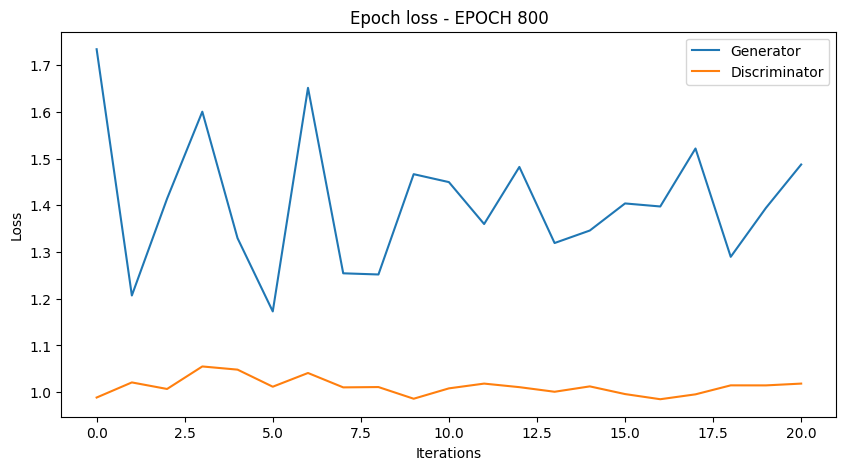

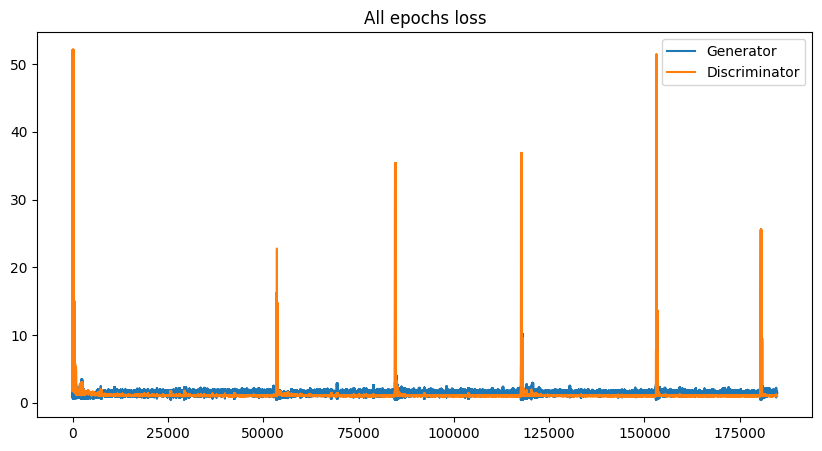

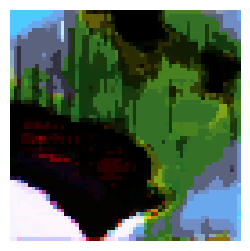

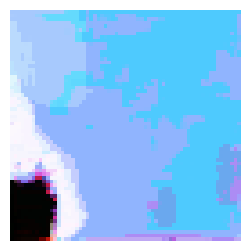

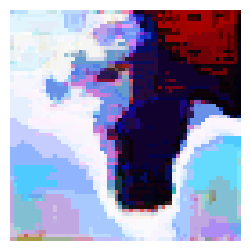

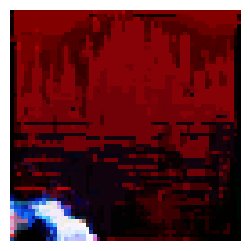

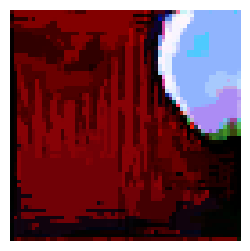

Epoch: 800 computed for 3.7544078826904297 sec
Generator loss mean:  1.4064665  std:  0.13983917
Discriminator loss mean:  1.0121306  std:  0.018063484
Epoch: 801 computed for 2.827538251876831 sec
Generator loss mean:  1.4321334  std:  0.267918
Discriminator loss mean:  1.0190899  std:  0.02242084
Epoch: 802 computed for 2.8171098232269287 sec
Generator loss mean:  1.4500391  std:  0.24764772
Discriminator loss mean:  1.012626  std:  0.022956356
Epoch: 803 computed for 2.8187646865844727 sec
Generator loss mean:  1.4234428  std:  0.116699204
Discriminator loss mean:  0.9994565  std:  0.014105374
Epoch: 804 computed for 2.814736843109131 sec
Generator loss mean:  1.4225454  std:  0.20058472
Discriminator loss mean:  1.0086863  std:  0.012944064
Epoch: 805 computed for 2.812987804412842 sec
Generator loss mean:  1.4239686  std:  0.13109668
Discriminator loss mean:  1.0004872  std:  0.017099451
Epoch: 806 computed for 2.814439058303833 sec
Generator loss mean:  1.4209664  std:  0.1208032

Epoch: 855 computed for 2.8253440856933594 sec
Generator loss mean:  1.4517136  std:  0.21218675
Discriminator loss mean:  1.0002753  std:  0.019302921
Epoch: 856 computed for 2.822221279144287 sec
Generator loss mean:  1.4213861  std:  0.10489403
Discriminator loss mean:  0.9966637  std:  0.015337865
Epoch: 857 computed for 2.830139636993408 sec
Generator loss mean:  1.4287237  std:  0.19065349
Discriminator loss mean:  1.0004358  std:  0.018369013
Epoch: 858 computed for 2.8233723640441895 sec
Generator loss mean:  1.4251715  std:  0.14908242
Discriminator loss mean:  0.99981207  std:  0.016343445
Epoch: 859 computed for 2.8261945247650146 sec
Generator loss mean:  1.422959  std:  0.10910827
Discriminator loss mean:  0.98828495  std:  0.015439937
Epoch: 860 computed for 2.8367927074432373 sec
Generator loss mean:  1.4173715  std:  0.15141542
Discriminator loss mean:  1.0024306  std:  0.015493288
Epoch: 861 computed for 2.824885845184326 sec
Generator loss mean:  1.4210279  std:  0.15

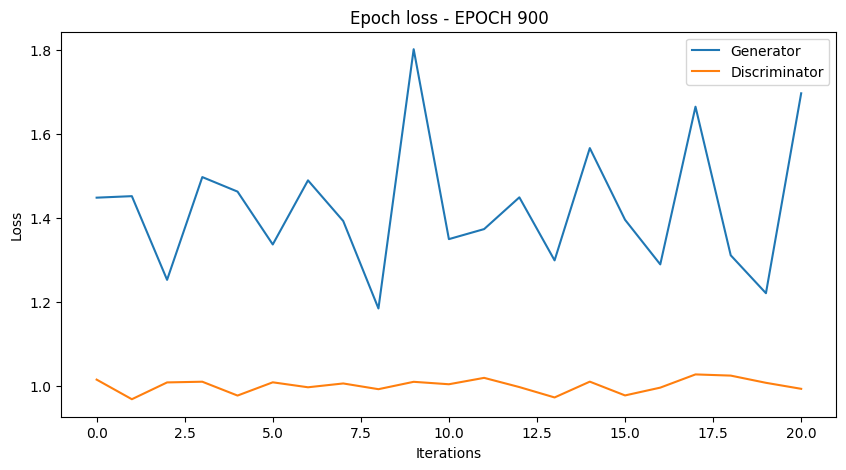

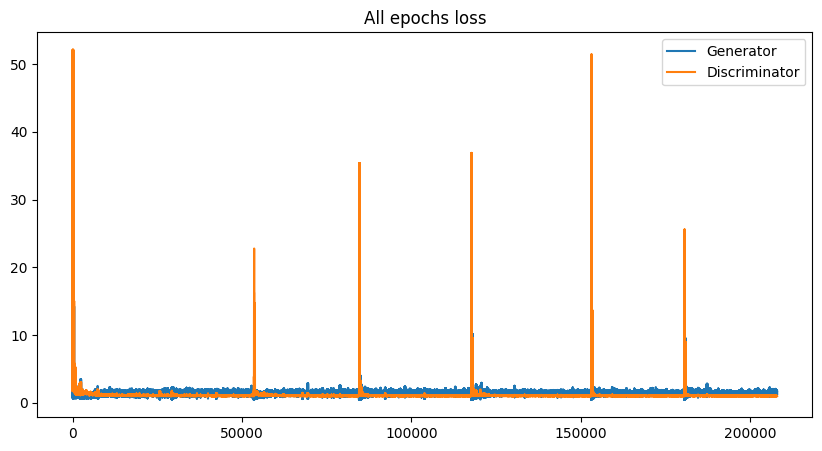

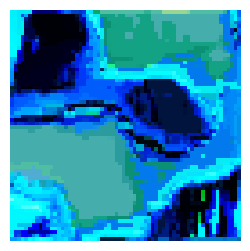

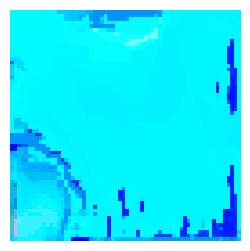

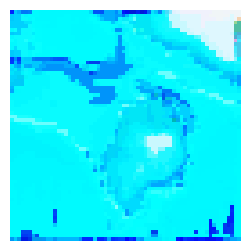

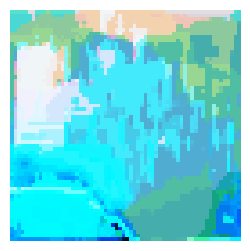

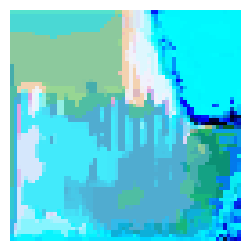

Epoch: 900 computed for 3.8012213706970215 sec
Generator loss mean:  1.4255565  std:  0.15429299
Discriminator loss mean:  1.0013937  std:  0.016045537
Epoch: 901 computed for 2.8222179412841797 sec
Generator loss mean:  1.422486  std:  0.112607464
Discriminator loss mean:  1.0020698  std:  0.016865024
Epoch: 902 computed for 2.8281643390655518 sec
Generator loss mean:  1.4315622  std:  0.14093675
Discriminator loss mean:  0.9951635  std:  0.016128378
Epoch: 903 computed for 2.8218495845794678 sec
Generator loss mean:  1.4345185  std:  0.19555461
Discriminator loss mean:  0.99993145  std:  0.014831269
Epoch: 904 computed for 2.814579486846924 sec
Generator loss mean:  1.4356511  std:  0.14666794
Discriminator loss mean:  0.9973307  std:  0.018191887
Epoch: 905 computed for 2.831867218017578 sec
Generator loss mean:  1.4257026  std:  0.11415841
Discriminator loss mean:  0.99457026  std:  0.018529307
Epoch: 906 computed for 2.817430257797241 sec
Generator loss mean:  1.4132931  std:  0.1

Epoch: 955 computed for 2.8610167503356934 sec
Generator loss mean:  1.4093155  std:  0.1754808
Discriminator loss mean:  1.0048345  std:  0.019943412
Epoch: 956 computed for 2.8355939388275146 sec
Generator loss mean:  1.3733313  std:  0.10864746
Discriminator loss mean:  0.9974871  std:  0.014404524
Epoch: 957 computed for 2.8350419998168945 sec
Generator loss mean:  1.4049475  std:  0.21353678
Discriminator loss mean:  1.0116149  std:  0.030083148
Epoch: 958 computed for 2.8307507038116455 sec
Generator loss mean:  1.422244  std:  0.19310376
Discriminator loss mean:  1.0045938  std:  0.022466306
Epoch: 959 computed for 2.827570676803589 sec
Generator loss mean:  1.4422548  std:  0.23123822
Discriminator loss mean:  1.0041782  std:  0.023061268
Epoch: 960 computed for 2.8342907428741455 sec
Generator loss mean:  1.4217253  std:  0.20634952
Discriminator loss mean:  1.0028887  std:  0.01672551
Epoch: 961 computed for 2.8210155963897705 sec
Generator loss mean:  1.4150411  std:  0.1510

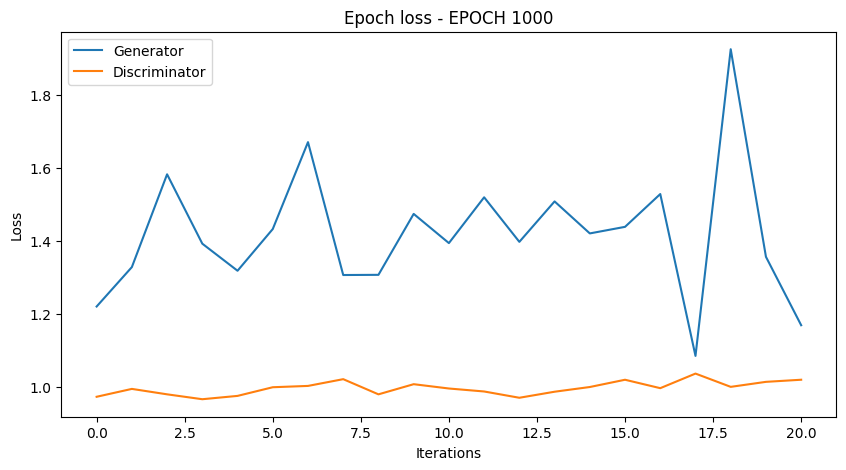

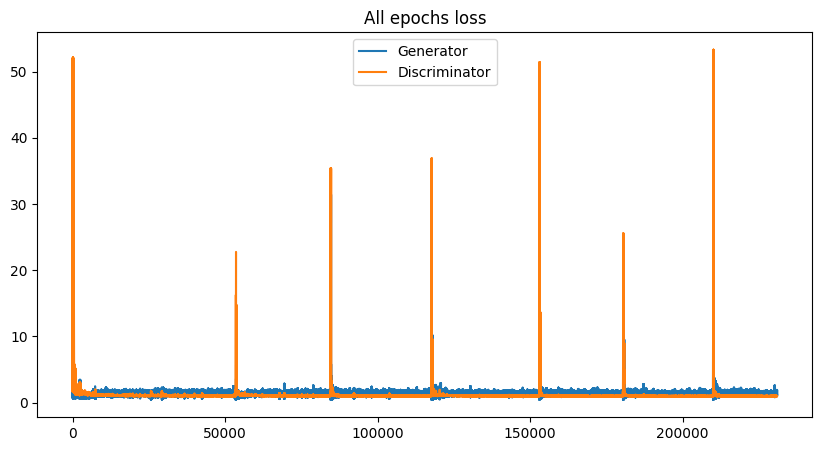

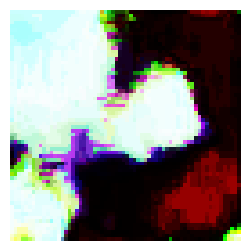

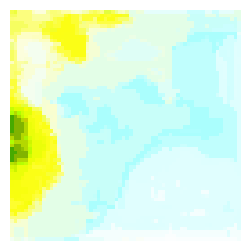

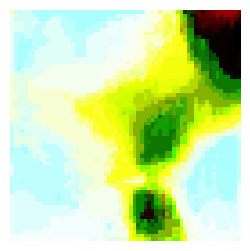

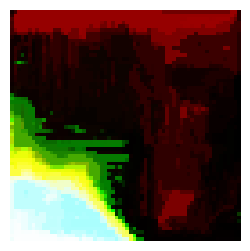

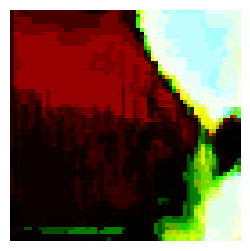

Epoch: 1000 computed for 4.855916738510132 sec
Generator loss mean:  1.417653  std:  0.17530444
Discriminator loss mean:  0.99538404  std:  0.018455274
Epoch: 1001 computed for 2.8294193744659424 sec
Generator loss mean:  1.447394  std:  0.22296824
Discriminator loss mean:  1.0030987  std:  0.027419288
Epoch: 1002 computed for 2.8152027130126953 sec
Generator loss mean:  1.410214  std:  0.11454117
Discriminator loss mean:  0.9998376  std:  0.011656923
Epoch: 1003 computed for 2.811070442199707 sec
Generator loss mean:  1.4304507  std:  0.17279239
Discriminator loss mean:  0.9982497  std:  0.021611558
Epoch: 1004 computed for 2.8073947429656982 sec
Generator loss mean:  1.4289888  std:  0.17156057
Discriminator loss mean:  1.0001968  std:  0.018392371
Epoch: 1005 computed for 2.8219523429870605 sec
Generator loss mean:  1.4470762  std:  0.17304464
Discriminator loss mean:  1.0015799  std:  0.018141521
Epoch: 1006 computed for 2.8120923042297363 sec
Generator loss mean:  1.4245615  std: 

Epoch: 1054 computed for 2.8219192028045654 sec
Generator loss mean:  1.4337744  std:  0.17744273
Discriminator loss mean:  0.9993808  std:  0.01762064
Epoch: 1055 computed for 2.8385090827941895 sec
Generator loss mean:  1.4311022  std:  0.12409896
Discriminator loss mean:  0.9938466  std:  0.01398294
Epoch: 1056 computed for 2.8298659324645996 sec
Generator loss mean:  1.4189329  std:  0.116942294
Discriminator loss mean:  1.0000017  std:  0.01752153
Epoch: 1057 computed for 2.8268625736236572 sec
Generator loss mean:  1.4364209  std:  0.13353759
Discriminator loss mean:  0.9922317  std:  0.013467815
Epoch: 1058 computed for 2.81432843208313 sec
Generator loss mean:  1.4274452  std:  0.1567592
Discriminator loss mean:  0.9998519  std:  0.020093681
Epoch: 1059 computed for 2.8293888568878174 sec
Generator loss mean:  1.4251571  std:  0.18136193
Discriminator loss mean:  1.0001241  std:  0.018839374
Epoch: 1060 computed for 2.8181827068328857 sec
Generator loss mean:  1.455732  std:  0

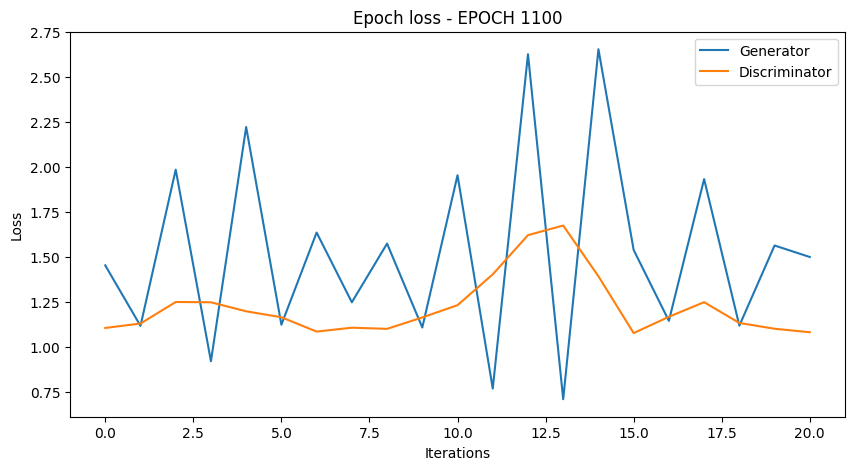

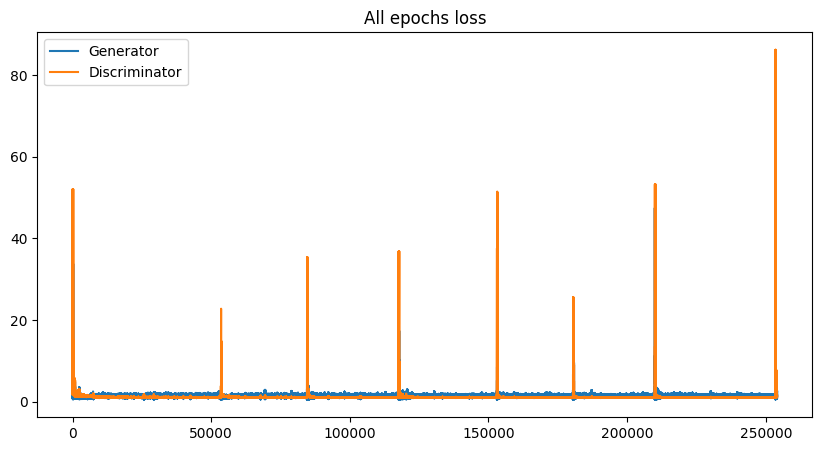

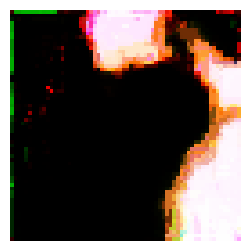

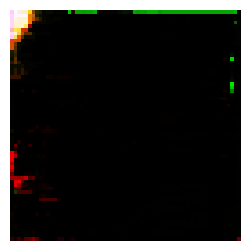

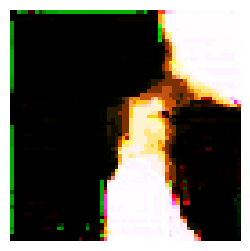

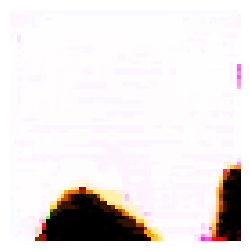

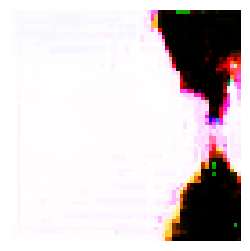

Epoch: 1100 computed for 4.155415058135986 sec
Generator loss mean:  1.5197372  std:  0.53571457
Discriminator loss mean:  1.2244623  std:  0.164537
Epoch: 1101 computed for 2.9020307064056396 sec
Generator loss mean:  1.4368843  std:  0.17147595
Discriminator loss mean:  1.068331  std:  0.02515915
Epoch: 1102 computed for 2.9302902221679688 sec
Generator loss mean:  1.5281607  std:  0.5416046
Discriminator loss mean:  1.1438372  std:  0.14799319
Epoch: 1103 computed for 2.812592029571533 sec
Generator loss mean:  1.4446379  std:  0.29892692
Discriminator loss mean:  1.0700856  std:  0.060206924
Epoch: 1104 computed for 2.817796468734741 sec
Generator loss mean:  1.4695396  std:  0.3107358
Discriminator loss mean:  1.0414965  std:  0.050931677
Epoch: 1105 computed for 2.8107857704162598 sec
Generator loss mean:  1.4825327  std:  0.3135468
Discriminator loss mean:  1.0445229  std:  0.030637637
Epoch: 1106 computed for 2.810955047607422 sec
Generator loss mean:  1.4563963  std:  0.246556

Epoch: 1154 computed for 2.831364870071411 sec
Generator loss mean:  1.4234693  std:  0.20303176
Discriminator loss mean:  0.99979347  std:  0.02057432
Epoch: 1155 computed for 2.840092658996582 sec
Generator loss mean:  1.4266614  std:  0.21216954
Discriminator loss mean:  1.001515  std:  0.02120417
Epoch: 1156 computed for 2.8388798236846924 sec
Generator loss mean:  1.4265603  std:  0.1972107
Discriminator loss mean:  1.0080284  std:  0.026217466
Epoch: 1157 computed for 2.8441288471221924 sec
Generator loss mean:  1.4515038  std:  0.22798832
Discriminator loss mean:  1.0045215  std:  0.029555297
Epoch: 1158 computed for 2.937542200088501 sec
Generator loss mean:  1.4370294  std:  0.26461306
Discriminator loss mean:  1.0160341  std:  0.030678673
Epoch: 1159 computed for 2.826061964035034 sec
Generator loss mean:  1.43155  std:  0.19768277
Discriminator loss mean:  0.99951  std:  0.018880833
Epoch: 1160 computed for 2.8355140686035156 sec
Generator loss mean:  1.4351741  std:  0.1989

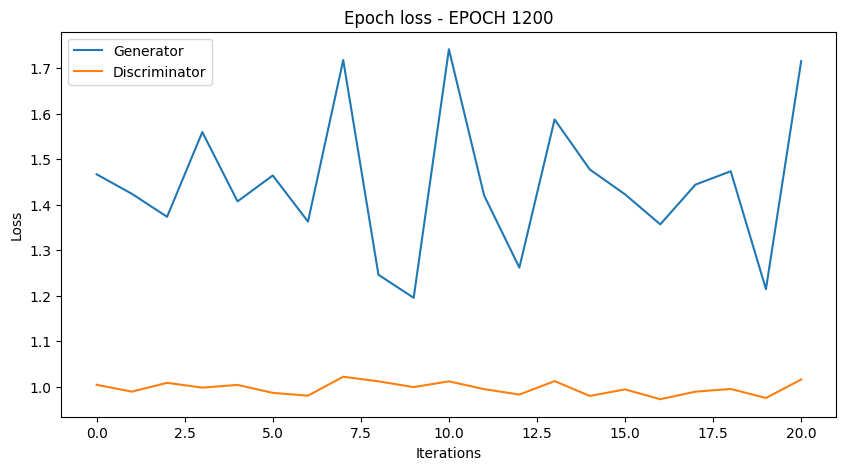

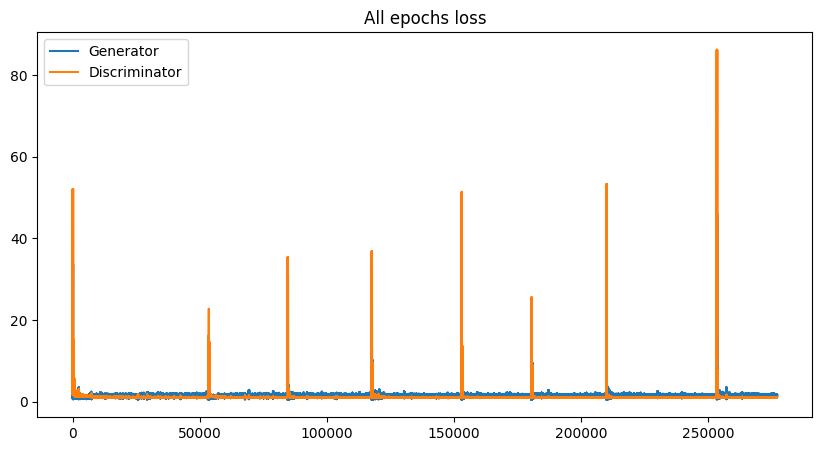

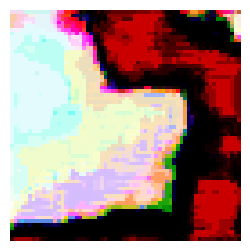

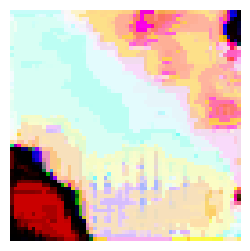

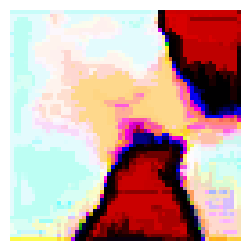

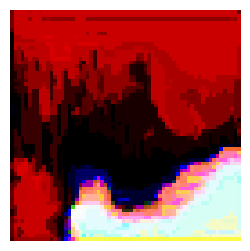

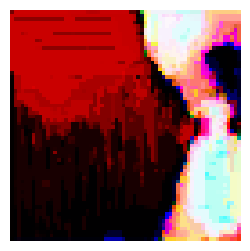

Epoch: 1200 computed for 4.045982122421265 sec
Generator loss mean:  1.4444716  std:  0.15155804
Discriminator loss mean:  0.9968694  std:  0.013781389
Epoch: 1201 computed for 2.818594455718994 sec
Generator loss mean:  1.438114  std:  0.15684958
Discriminator loss mean:  0.99562484  std:  0.022361195
Epoch: 1202 computed for 2.819263219833374 sec
Generator loss mean:  1.4488972  std:  0.17123996
Discriminator loss mean:  0.99965733  std:  0.013285731
Epoch: 1203 computed for 2.813917875289917 sec
Generator loss mean:  1.432223  std:  0.15231714
Discriminator loss mean:  0.99882764  std:  0.014929378
Epoch: 1204 computed for 2.8168785572052 sec
Generator loss mean:  1.4313126  std:  0.13778342
Discriminator loss mean:  0.99347603  std:  0.016223507
Epoch: 1205 computed for 2.819232940673828 sec
Generator loss mean:  1.4411894  std:  0.12828162
Discriminator loss mean:  0.9972453  std:  0.016597148
Epoch: 1206 computed for 2.8221182823181152 sec
Generator loss mean:  1.4221154  std:  0

Epoch: 1254 computed for 2.8225414752960205 sec
Generator loss mean:  1.4256535  std:  0.23334573
Discriminator loss mean:  1.0042651  std:  0.020197162
Epoch: 1255 computed for 2.8280727863311768 sec
Generator loss mean:  1.4143406  std:  0.16570045
Discriminator loss mean:  1.0063734  std:  0.01357423
Epoch: 1256 computed for 2.8254482746124268 sec
Generator loss mean:  1.4517702  std:  0.17860019
Discriminator loss mean:  0.9946027  std:  0.016225642
Epoch: 1257 computed for 2.8286726474761963 sec
Generator loss mean:  1.4217117  std:  0.1428258
Discriminator loss mean:  0.9964891  std:  0.015527737
Epoch: 1258 computed for 2.8218882083892822 sec
Generator loss mean:  1.4265504  std:  0.23225483
Discriminator loss mean:  1.006772  std:  0.018356044
Epoch: 1259 computed for 2.826902151107788 sec
Generator loss mean:  1.4357126  std:  0.13574989
Discriminator loss mean:  0.99997467  std:  0.014534247
Epoch: 1260 computed for 2.82423734664917 sec
Generator loss mean:  1.4595383  std:  

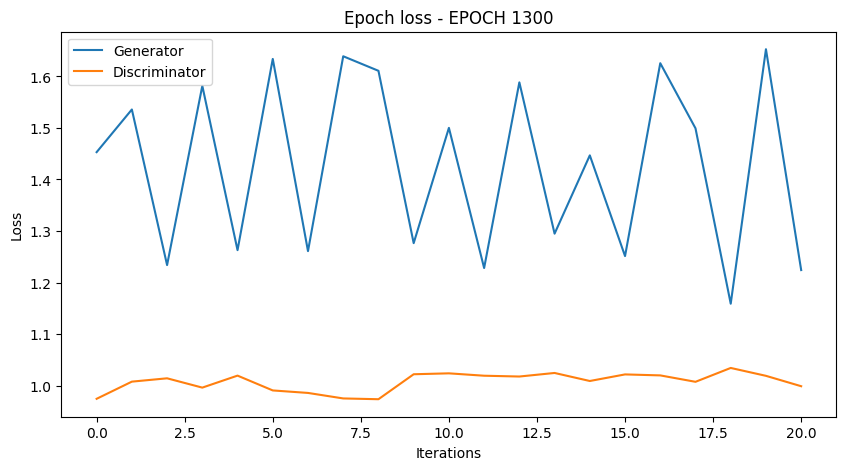

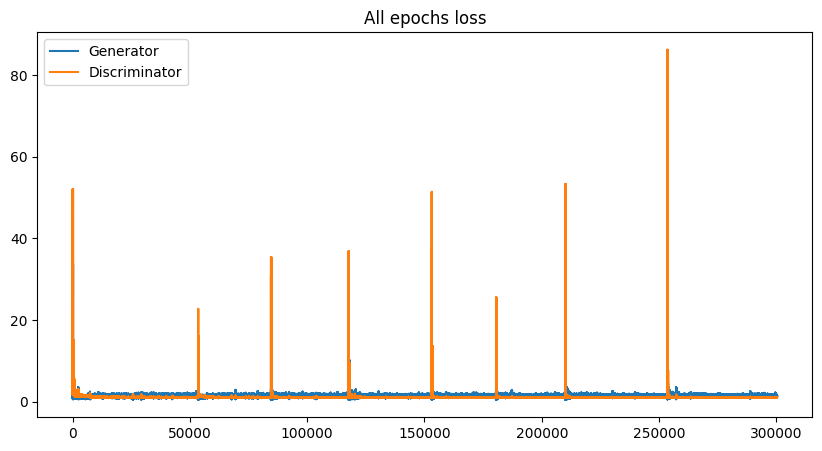

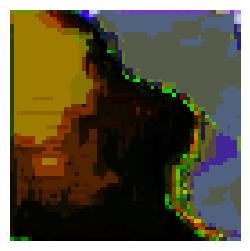

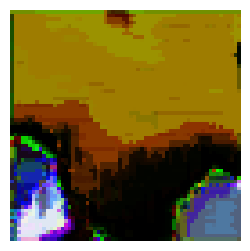

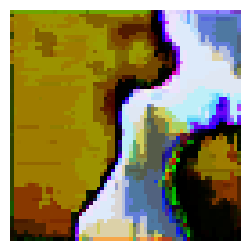

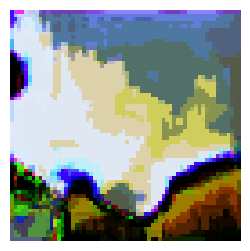

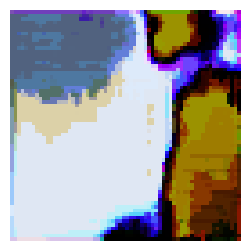

Epoch: 1300 computed for 4.03767466545105 sec
Generator loss mean:  1.4266711  std:  0.16921389
Discriminator loss mean:  1.0072179  std:  0.01780575
Epoch: 1301 computed for 2.8026928901672363 sec
Generator loss mean:  1.4628352  std:  0.1942862
Discriminator loss mean:  0.9905794  std:  0.022429956
Epoch: 1302 computed for 2.79791259765625 sec
Generator loss mean:  1.4229283  std:  0.14540844
Discriminator loss mean:  1.0014454  std:  0.016983027
Epoch: 1303 computed for 2.806832790374756 sec
Generator loss mean:  1.426163  std:  0.19848362
Discriminator loss mean:  1.0060266  std:  0.024850648
Epoch: 1304 computed for 2.802178144454956 sec
Generator loss mean:  1.4448127  std:  0.22691356
Discriminator loss mean:  1.0083383  std:  0.025880115
Epoch: 1305 computed for 2.801067352294922 sec
Generator loss mean:  1.432756  std:  0.17554493
Discriminator loss mean:  0.99937487  std:  0.016525052
Epoch: 1306 computed for 2.801260471343994 sec
Generator loss mean:  1.421936  std:  0.11139

Epoch: 1355 computed for 2.797351837158203 sec
Generator loss mean:  1.4532015  std:  0.21300785
Discriminator loss mean:  1.0034306  std:  0.023543166
Epoch: 1356 computed for 2.80275821685791 sec
Generator loss mean:  1.4499639  std:  0.22127922
Discriminator loss mean:  1.0130876  std:  0.026641812
Epoch: 1357 computed for 2.8139164447784424 sec
Generator loss mean:  1.4351488  std:  0.15384977
Discriminator loss mean:  0.9948786  std:  0.01271945
Epoch: 1358 computed for 2.8451621532440186 sec
Generator loss mean:  1.4438893  std:  0.15180984
Discriminator loss mean:  1.0021957  std:  0.015625728
Epoch: 1359 computed for 2.798692226409912 sec
Generator loss mean:  1.4328829  std:  0.21226704
Discriminator loss mean:  1.0022428  std:  0.016944863
Epoch: 1360 computed for 2.8004753589630127 sec
Generator loss mean:  1.439826  std:  0.1635935
Discriminator loss mean:  1.0042853  std:  0.016275937
Epoch: 1361 computed for 2.8004086017608643 sec
Generator loss mean:  1.4271576  std:  0.

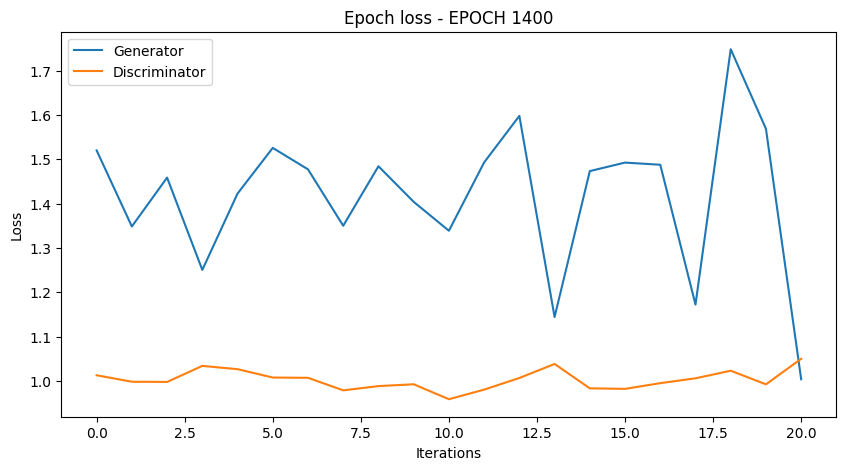

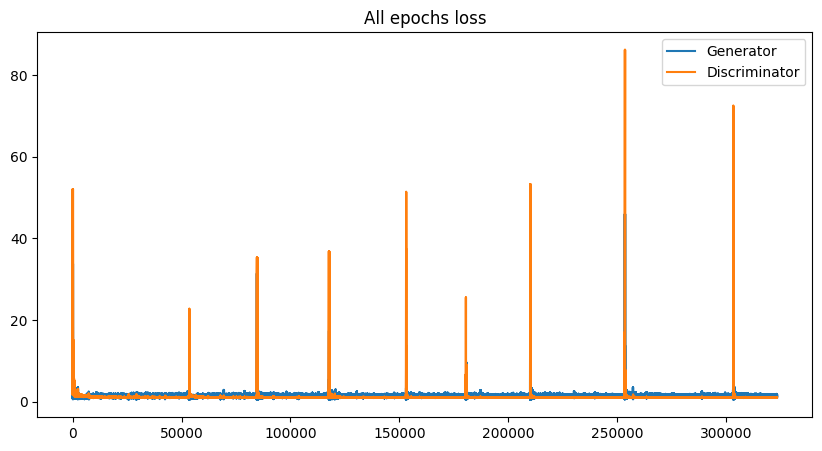

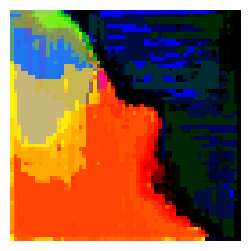

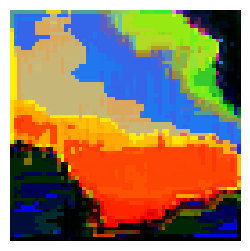

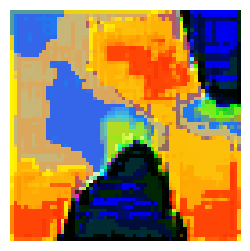

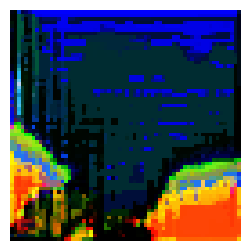

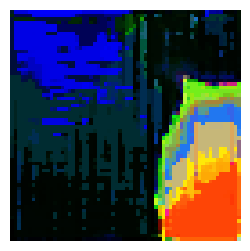

Epoch: 1400 computed for 4.7577738761901855 sec
Generator loss mean:  1.4173639  std:  0.16411163
Discriminator loss mean:  1.0030451  std:  0.021756914
Epoch: 1401 computed for 2.8025691509246826 sec
Generator loss mean:  1.4315042  std:  0.18043113
Discriminator loss mean:  0.9973277  std:  0.01717928
Epoch: 1402 computed for 2.7845475673675537 sec
Generator loss mean:  1.4506421  std:  0.20588112
Discriminator loss mean:  1.0067791  std:  0.011592096
Epoch: 1403 computed for 2.780087947845459 sec
Generator loss mean:  1.4163301  std:  0.14302398
Discriminator loss mean:  1.0019298  std:  0.016714001
Epoch: 1404 computed for 2.785623550415039 sec
Generator loss mean:  1.4327091  std:  0.15392901
Discriminator loss mean:  0.9942893  std:  0.023931043
Epoch: 1405 computed for 2.7820725440979004 sec
Generator loss mean:  1.4505094  std:  0.3201338
Discriminator loss mean:  1.0110366  std:  0.04574784
Epoch: 1406 computed for 2.7826547622680664 sec
Generator loss mean:  1.4074137  std:  

Epoch: 1454 computed for 2.796764373779297 sec
Generator loss mean:  1.430323  std:  0.20362192
Discriminator loss mean:  1.0065061  std:  0.025926314
Epoch: 1455 computed for 2.796983480453491 sec
Generator loss mean:  1.4234881  std:  0.13412073
Discriminator loss mean:  1.0007553  std:  0.01889842
Epoch: 1456 computed for 2.793280839920044 sec
Generator loss mean:  1.4293774  std:  0.13063669
Discriminator loss mean:  0.99078697  std:  0.01709016
Epoch: 1457 computed for 2.790867805480957 sec
Generator loss mean:  1.4255232  std:  0.17275913
Discriminator loss mean:  1.0010954  std:  0.021402137
Epoch: 1458 computed for 2.7979390621185303 sec
Generator loss mean:  1.4156841  std:  0.2330264
Discriminator loss mean:  1.0142767  std:  0.021190219
Epoch: 1459 computed for 2.798964023590088 sec
Generator loss mean:  1.4540228  std:  0.2494689
Discriminator loss mean:  1.0073149  std:  0.02316296
Epoch: 1460 computed for 2.795790672302246 sec
Generator loss mean:  1.4383924  std:  0.1820

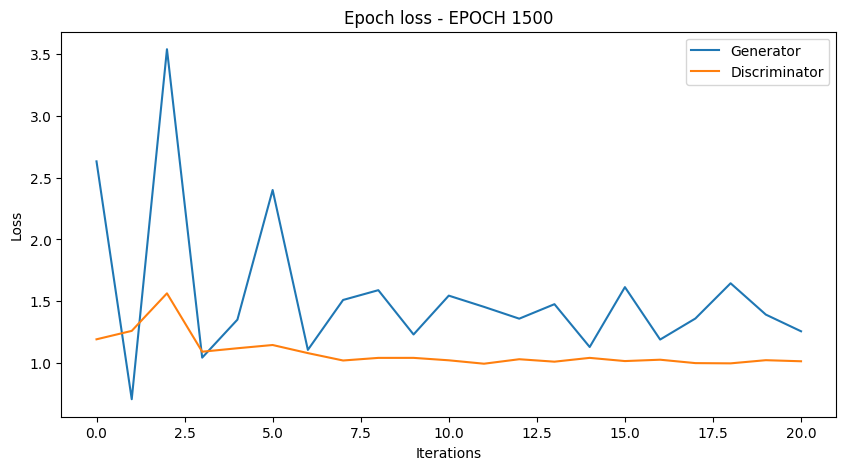

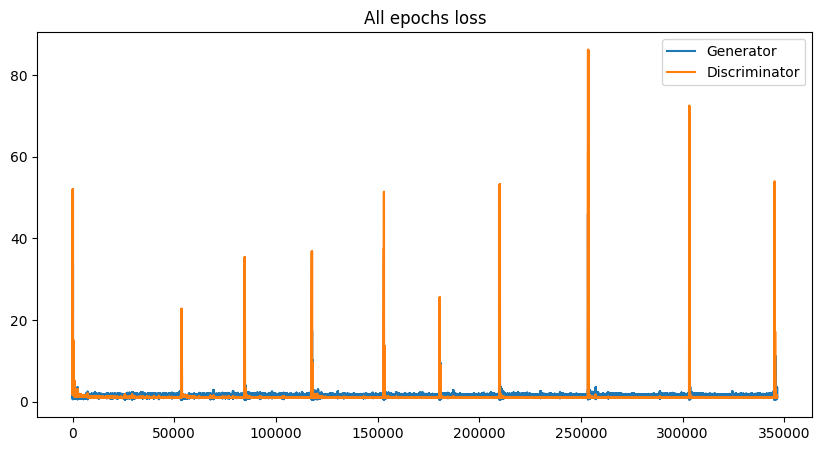

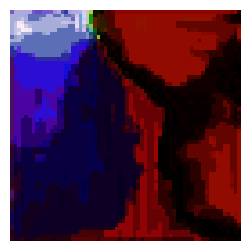

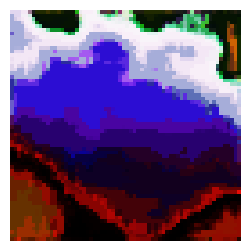

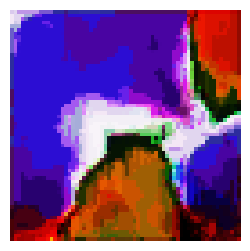

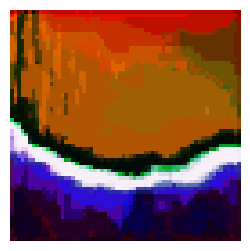

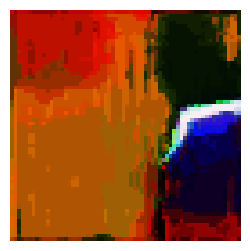

Epoch: 1500 computed for 4.085204362869263 sec
Generator loss mean:  1.5500154  std:  0.6032903
Discriminator loss mean:  1.0843496  std:  0.1267271
Epoch: 1501 computed for 2.816467523574829 sec
Generator loss mean:  1.4716353  std:  0.22194533
Discriminator loss mean:  1.0193881  std:  0.022650016
Epoch: 1502 computed for 2.793245315551758 sec
Generator loss mean:  1.4814593  std:  0.3071928
Discriminator loss mean:  1.0333846  std:  0.040991966
Epoch: 1503 computed for 2.797318458557129 sec
Generator loss mean:  1.4463625  std:  0.29678193
Discriminator loss mean:  1.0325416  std:  0.03221594
Epoch: 1504 computed for 2.7937450408935547 sec
Generator loss mean:  1.4581167  std:  0.21482149
Discriminator loss mean:  1.0134717  std:  0.021743128
Epoch: 1505 computed for 2.795179843902588 sec
Generator loss mean:  1.4267498  std:  0.22919782
Discriminator loss mean:  1.0168177  std:  0.024387855
Epoch: 1506 computed for 2.8007612228393555 sec
Generator loss mean:  1.4406233  std:  0.198

Epoch: 1554 computed for 2.8076868057250977 sec
Generator loss mean:  1.4186693  std:  0.12445181
Discriminator loss mean:  0.9990356  std:  0.013696121
Epoch: 1555 computed for 2.8004348278045654 sec
Generator loss mean:  1.4287446  std:  0.11654052
Discriminator loss mean:  0.99417293  std:  0.022075152
Epoch: 1556 computed for 2.8029839992523193 sec
Generator loss mean:  1.410963  std:  0.12716334
Discriminator loss mean:  0.9920373  std:  0.015979182
Epoch: 1557 computed for 2.796231985092163 sec
Generator loss mean:  1.417316  std:  0.18102376
Discriminator loss mean:  1.0043871  std:  0.02116368
Epoch: 1558 computed for 2.883812189102173 sec
Generator loss mean:  1.4273438  std:  0.11118962
Discriminator loss mean:  0.99353063  std:  0.016361685
Epoch: 1559 computed for 2.797865152359009 sec
Generator loss mean:  1.4335198  std:  0.16138254
Discriminator loss mean:  1.0008811  std:  0.01561943
Epoch: 1560 computed for 2.797254800796509 sec
Generator loss mean:  1.4379259  std:  0

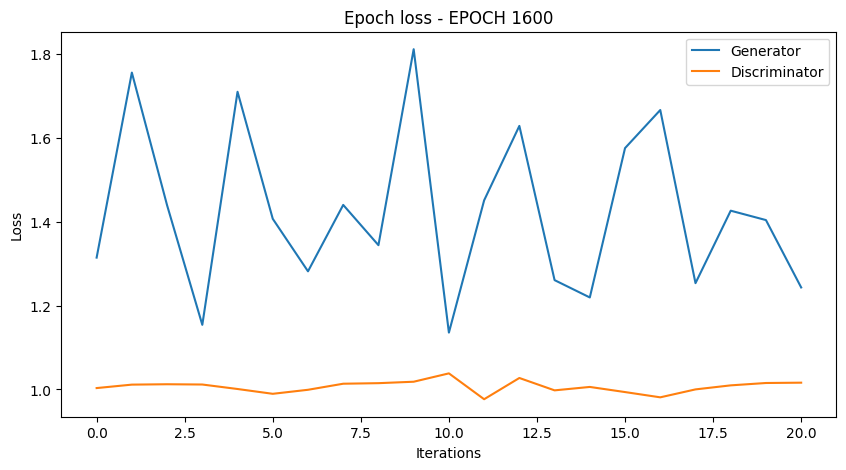

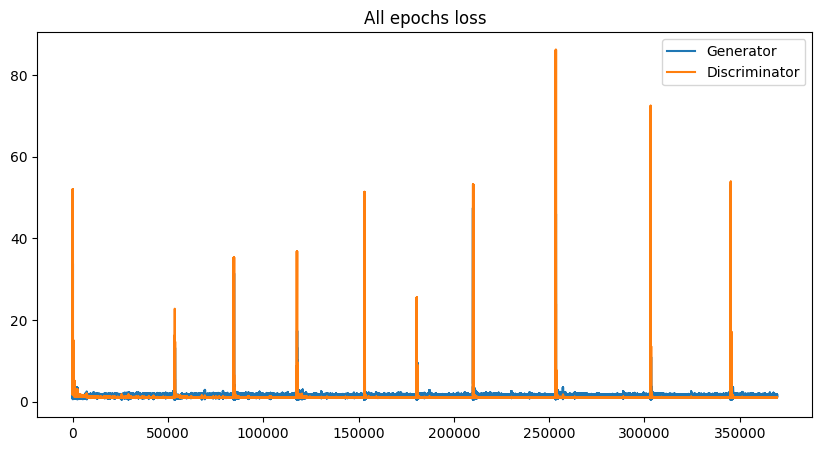

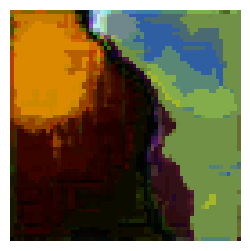

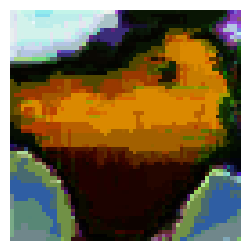

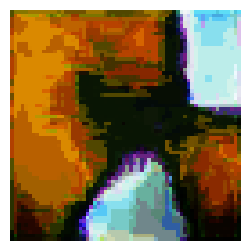

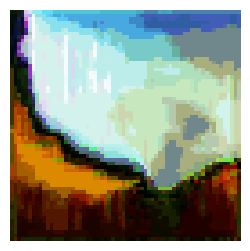

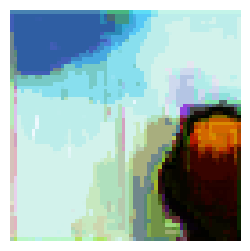

Epoch: 1600 computed for 4.30299186706543 sec
Generator loss mean:  1.4246595  std:  0.194176
Discriminator loss mean:  1.0065416  std:  0.014086293
Epoch: 1601 computed for 2.8036205768585205 sec
Generator loss mean:  1.4360105  std:  0.14546478
Discriminator loss mean:  0.99819326  std:  0.019016486
Epoch: 1602 computed for 2.7934775352478027 sec
Generator loss mean:  1.4046797  std:  0.10940159
Discriminator loss mean:  0.998844  std:  0.009980474
Epoch: 1603 computed for 2.7957916259765625 sec
Generator loss mean:  1.4250339  std:  0.13545449
Discriminator loss mean:  1.0003313  std:  0.017049033
Epoch: 1604 computed for 2.785036325454712 sec
Generator loss mean:  1.435941  std:  0.17302124
Discriminator loss mean:  1.0047061  std:  0.02100839
Epoch: 1605 computed for 2.7964212894439697 sec
Generator loss mean:  1.4130561  std:  0.1626596
Discriminator loss mean:  1.0044924  std:  0.018312704
Epoch: 1606 computed for 2.8432302474975586 sec
Generator loss mean:  1.4250995  std:  0.1

Epoch: 1654 computed for 2.801740884780884 sec
Generator loss mean:  1.4196941  std:  0.18955512
Discriminator loss mean:  1.0089998  std:  0.026746802
Epoch: 1655 computed for 2.8061325550079346 sec
Generator loss mean:  1.4337003  std:  0.14673983
Discriminator loss mean:  1.0059042  std:  0.018123494
Epoch: 1656 computed for 2.8106424808502197 sec
Generator loss mean:  1.4297768  std:  0.19710726
Discriminator loss mean:  1.0005945  std:  0.019435879
Epoch: 1657 computed for 2.7920212745666504 sec
Generator loss mean:  1.4220185  std:  0.22896962
Discriminator loss mean:  1.0121286  std:  0.023083784
Epoch: 1658 computed for 2.800523281097412 sec
Generator loss mean:  1.441906  std:  0.16462855
Discriminator loss mean:  0.9988824  std:  0.019382287
Epoch: 1659 computed for 2.813875198364258 sec
Generator loss mean:  1.4492184  std:  0.22099806
Discriminator loss mean:  1.0083487  std:  0.020981021
Epoch: 1660 computed for 2.7904162406921387 sec
Generator loss mean:  1.4458089  std: 

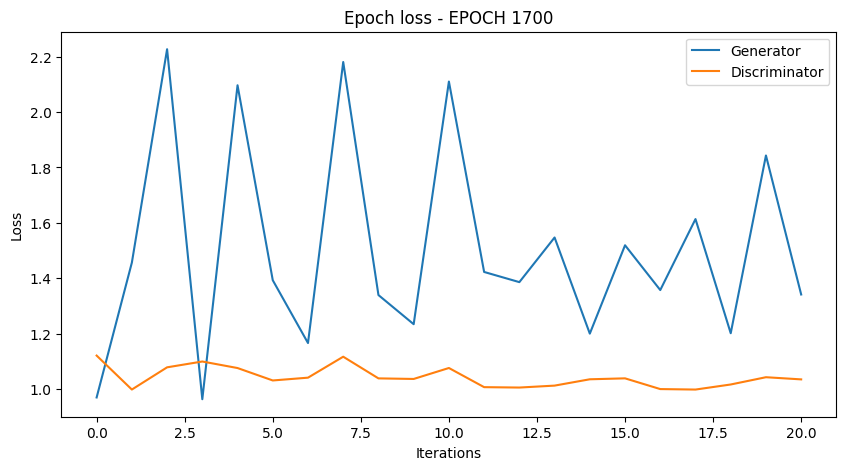

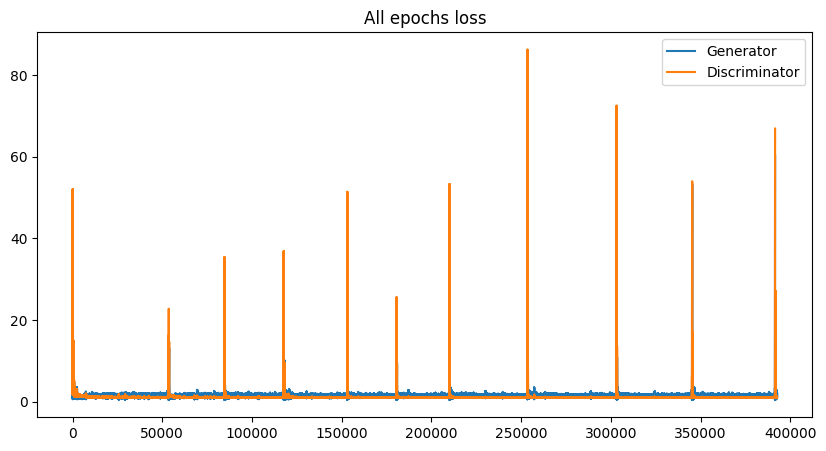

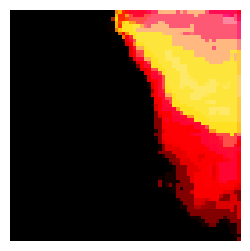

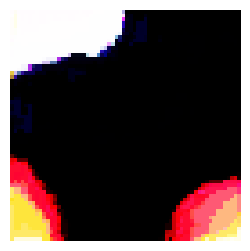

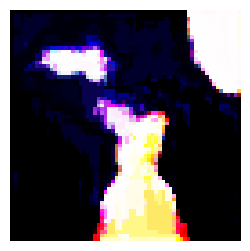

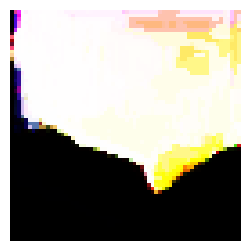

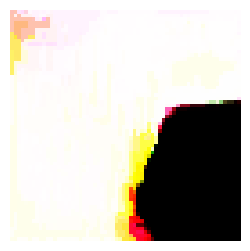

Epoch: 1700 computed for 4.416392087936401 sec
Generator loss mean:  1.5031472  std:  0.3706779
Discriminator loss mean:  1.0430548  std:  0.036951624
Epoch: 1701 computed for 2.8230748176574707 sec
Generator loss mean:  1.4825995  std:  0.29911226
Discriminator loss mean:  1.0308012  std:  0.04870044
Epoch: 1702 computed for 2.801433563232422 sec
Generator loss mean:  1.4683241  std:  0.3070803
Discriminator loss mean:  1.027982  std:  0.042187013
Epoch: 1703 computed for 2.797201633453369 sec
Generator loss mean:  1.4429318  std:  0.2669824
Discriminator loss mean:  1.0228915  std:  0.03791668
Epoch: 1704 computed for 2.7923014163970947 sec
Generator loss mean:  1.508783  std:  0.3241036
Discriminator loss mean:  1.02854  std:  0.03369944
Epoch: 1705 computed for 2.7894034385681152 sec
Generator loss mean:  1.4714968  std:  0.31055954
Discriminator loss mean:  1.0170678  std:  0.021761343
Epoch: 1706 computed for 2.7916982173919678 sec
Generator loss mean:  1.4410956  std:  0.2306745

Epoch: 1754 computed for 2.801521062850952 sec
Generator loss mean:  1.426129  std:  0.17257077
Discriminator loss mean:  0.9999652  std:  0.015794579
Epoch: 1755 computed for 2.7986061573028564 sec
Generator loss mean:  1.4222099  std:  0.14079633
Discriminator loss mean:  0.9987296  std:  0.016193941
Epoch: 1756 computed for 2.8023295402526855 sec
Generator loss mean:  1.4293108  std:  0.1694789
Discriminator loss mean:  0.9980605  std:  0.01504571
Epoch: 1757 computed for 2.813405990600586 sec
Generator loss mean:  1.4325469  std:  0.14412707
Discriminator loss mean:  0.9966953  std:  0.02098281
Epoch: 1758 computed for 2.8389267921447754 sec
Generator loss mean:  1.4251081  std:  0.13103709
Discriminator loss mean:  0.9973918  std:  0.017091295
Epoch: 1759 computed for 2.84674334526062 sec
Generator loss mean:  1.4264798  std:  0.1600273
Discriminator loss mean:  1.0038556  std:  0.019423453
Epoch: 1760 computed for 2.8017196655273438 sec
Generator loss mean:  1.4375229  std:  0.13

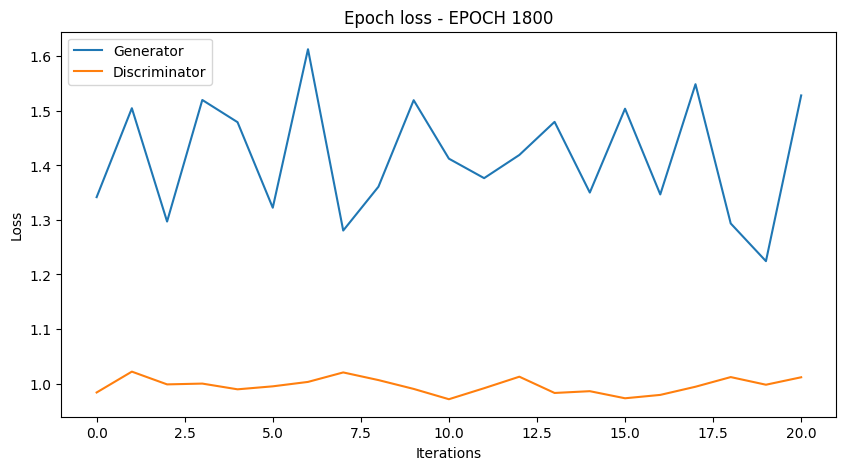

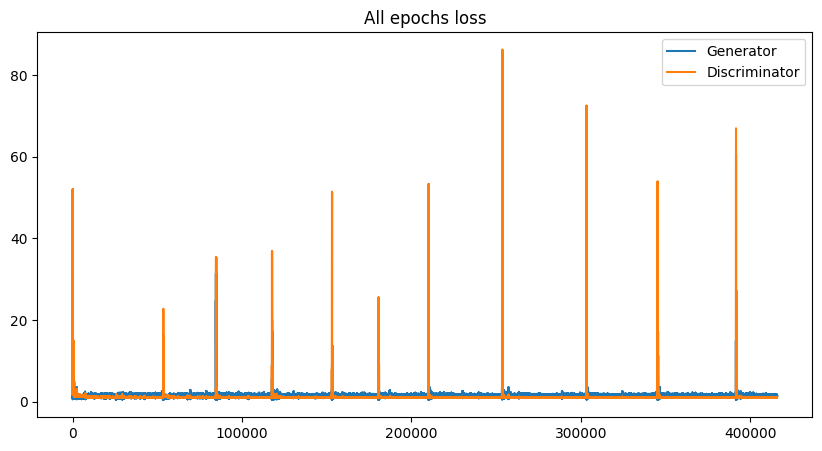

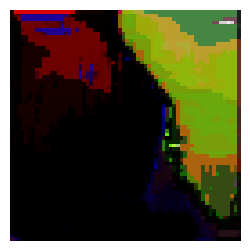

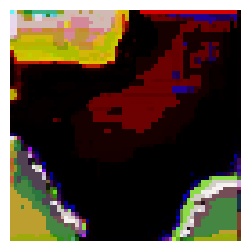

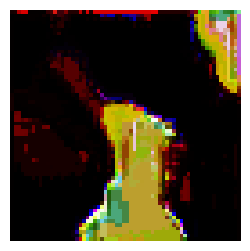

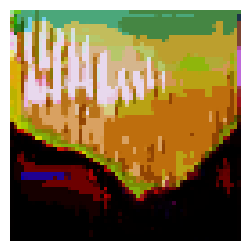

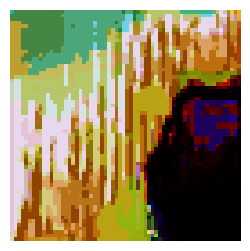

Epoch: 1800 computed for 4.336896657943726 sec
Generator loss mean:  1.4154505  std:  0.103883706
Discriminator loss mean:  0.9961141  std:  0.014088274
Epoch: 1801 computed for 2.852415084838867 sec
Generator loss mean:  1.4341648  std:  0.15862425
Discriminator loss mean:  0.99690086  std:  0.014582236
Epoch: 1802 computed for 2.7987008094787598 sec
Generator loss mean:  1.426908  std:  0.09381561
Discriminator loss mean:  0.99774  std:  0.015519328
Epoch: 1803 computed for 2.810176134109497 sec
Generator loss mean:  1.4208155  std:  0.12967125
Discriminator loss mean:  0.9957024  std:  0.01632099
Epoch: 1804 computed for 2.803112268447876 sec
Generator loss mean:  1.4226714  std:  0.07049735
Discriminator loss mean:  0.99353  std:  0.016350584
Epoch: 1805 computed for 2.806349039077759 sec
Generator loss mean:  1.4346783  std:  0.15263024
Discriminator loss mean:  0.9965766  std:  0.02285838
Epoch: 1806 computed for 2.8125710487365723 sec
Generator loss mean:  1.4054465  std:  0.123

Epoch: 1854 computed for 2.7899911403656006 sec
Generator loss mean:  1.4115393  std:  0.12030381
Discriminator loss mean:  0.99758804  std:  0.016892089
Epoch: 1855 computed for 2.806730270385742 sec
Generator loss mean:  1.4437342  std:  0.15780218
Discriminator loss mean:  0.99590427  std:  0.016488932
Epoch: 1856 computed for 2.791696548461914 sec
Generator loss mean:  1.4332037  std:  0.22624792
Discriminator loss mean:  1.0116427  std:  0.024153266
Epoch: 1857 computed for 2.800536632537842 sec
Generator loss mean:  1.4261576  std:  0.15908326
Discriminator loss mean:  0.9997405  std:  0.016774254
Epoch: 1858 computed for 2.792520046234131 sec
Generator loss mean:  1.4257838  std:  0.18890022
Discriminator loss mean:  1.0034528  std:  0.018039523
Epoch: 1859 computed for 2.797823429107666 sec
Generator loss mean:  1.4345535  std:  0.1668029
Discriminator loss mean:  1.000731  std:  0.017389385
Epoch: 1860 computed for 2.7990596294403076 sec
Generator loss mean:  1.4069595  std:  

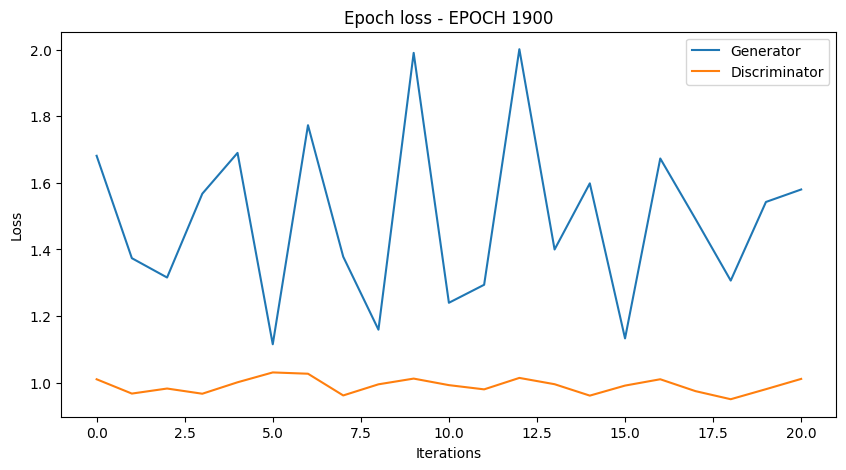

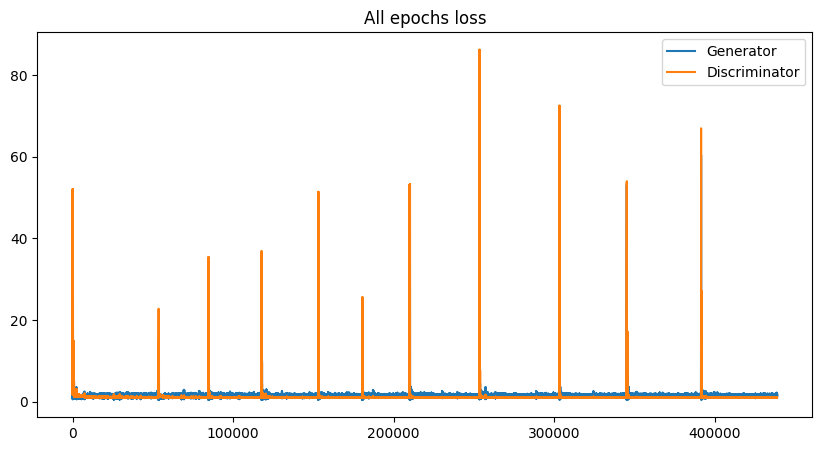

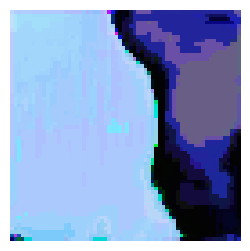

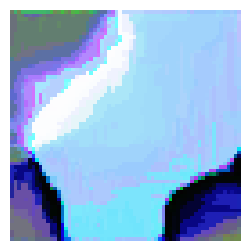

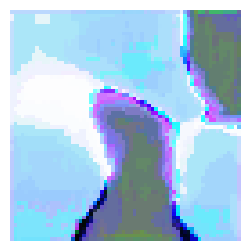

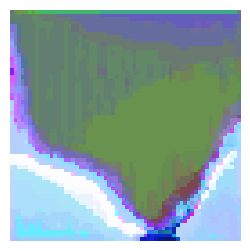

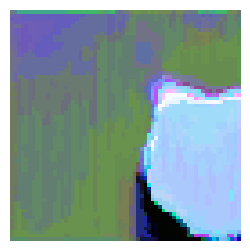

Epoch: 1900 computed for 4.285059928894043 sec
Generator loss mean:  1.4907042  std:  0.24951658
Discriminator loss mean:  0.9911853  std:  0.022141248
Epoch: 1901 computed for 2.813225030899048 sec
Generator loss mean:  1.4384985  std:  0.19258289
Discriminator loss mean:  1.0095108  std:  0.02316048
Epoch: 1902 computed for 2.7969369888305664 sec
Generator loss mean:  1.4329127  std:  0.13431062
Discriminator loss mean:  0.99780566  std:  0.01885463
Epoch: 1903 computed for 2.7942042350769043 sec
Generator loss mean:  1.4233304  std:  0.13473235
Discriminator loss mean:  0.99429584  std:  0.017414428
Epoch: 1904 computed for 2.788961410522461 sec
Generator loss mean:  1.4271019  std:  0.15040328
Discriminator loss mean:  0.997633  std:  0.016423687
Epoch: 1905 computed for 2.78924822807312 sec
Generator loss mean:  1.4392  std:  0.113335304
Discriminator loss mean:  0.9942197  std:  0.013892931
Epoch: 1906 computed for 2.791501998901367 sec
Generator loss mean:  1.4260161  std:  0.17

Epoch: 1955 computed for 2.79178524017334 sec
Generator loss mean:  1.5341978  std:  0.36979216
Discriminator loss mean:  1.0498046  std:  0.059261363
Epoch: 1956 computed for 2.7951345443725586 sec
Generator loss mean:  1.4498309  std:  0.4024851
Discriminator loss mean:  1.0709544  std:  0.08075799
Epoch: 1957 computed for 2.7946572303771973 sec
Generator loss mean:  1.4876577  std:  0.502446
Discriminator loss mean:  1.0990119  std:  0.1313824
Epoch: 1958 computed for 2.8063244819641113 sec
Generator loss mean:  1.4554297  std:  0.29766756
Discriminator loss mean:  1.0286486  std:  0.028159367
Epoch: 1959 computed for 2.794191360473633 sec
Generator loss mean:  1.4773805  std:  0.2626198
Discriminator loss mean:  1.0169401  std:  0.026558632
Epoch: 1960 computed for 2.905940532684326 sec
Generator loss mean:  1.4417962  std:  0.1793476
Discriminator loss mean:  1.0085202  std:  0.01576513
Epoch: 1961 computed for 2.7949817180633545 sec
Generator loss mean:  1.4504049  std:  0.280206

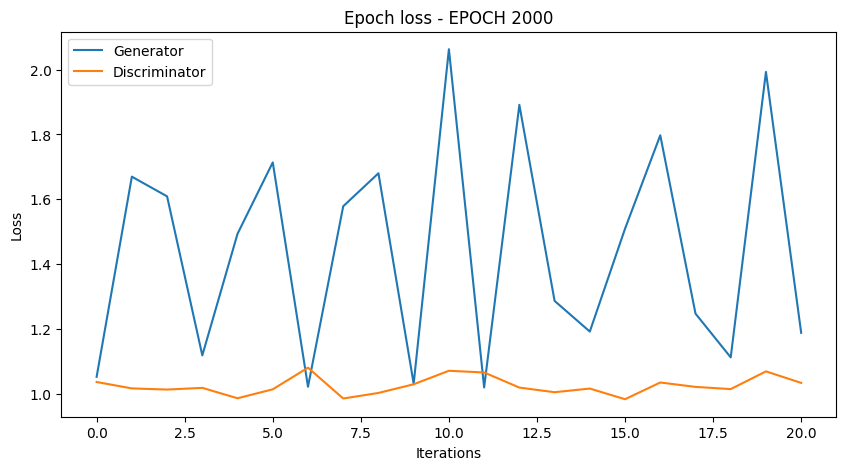

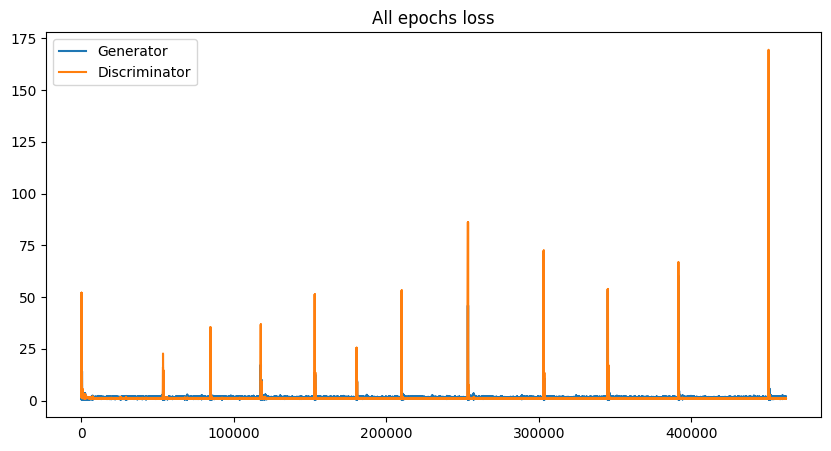

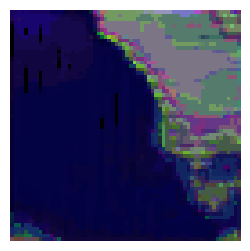

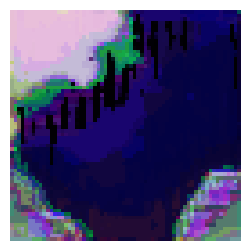

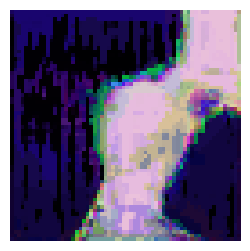

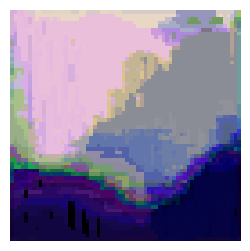

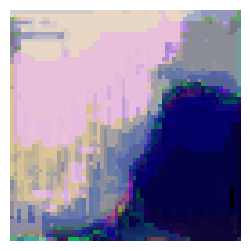

Epoch: 2000 computed for 5.096250772476196 sec
Generator loss mean:  1.4416662  std:  0.33287632
Discriminator loss mean:  1.025318  std:  0.027109195
Epoch: 2001 computed for 2.812246322631836 sec
Generator loss mean:  1.4546267  std:  0.32461485
Discriminator loss mean:  1.027153  std:  0.057691466
Epoch: 2002 computed for 2.7850372791290283 sec
Generator loss mean:  1.4279021  std:  0.25715792
Discriminator loss mean:  1.0051302  std:  0.022335632
Epoch: 2003 computed for 2.7957589626312256 sec
Generator loss mean:  1.438084  std:  0.19153604
Discriminator loss mean:  1.0075746  std:  0.019171925
Epoch: 2004 computed for 2.799659252166748 sec
Generator loss mean:  1.4214504  std:  0.16959956
Discriminator loss mean:  1.0016625  std:  0.015542354
Epoch: 2005 computed for 2.7909770011901855 sec
Generator loss mean:  1.4448181  std:  0.23364048
Discriminator loss mean:  1.0027109  std:  0.020286296
Epoch: 2006 computed for 2.7919983863830566 sec
Generator loss mean:  1.4366239  std:  0

Epoch: 2054 computed for 2.783280372619629 sec
Generator loss mean:  1.4332674  std:  0.16784422
Discriminator loss mean:  0.9978123  std:  0.015018496
Epoch: 2055 computed for 2.7962982654571533 sec
Generator loss mean:  1.433329  std:  0.11578028
Discriminator loss mean:  0.9978461  std:  0.017821541
Epoch: 2056 computed for 2.793510913848877 sec
Generator loss mean:  1.4045241  std:  0.09676618
Discriminator loss mean:  0.9947482  std:  0.014523713
Epoch: 2057 computed for 2.7975475788116455 sec
Generator loss mean:  1.4379952  std:  0.112865716
Discriminator loss mean:  0.9931231  std:  0.017521856
Epoch: 2058 computed for 2.800299882888794 sec
Generator loss mean:  1.4282808  std:  0.1320633
Discriminator loss mean:  0.99423283  std:  0.016850738
Epoch: 2059 computed for 2.7974188327789307 sec
Generator loss mean:  1.4086965  std:  0.12298661
Discriminator loss mean:  0.9961501  std:  0.015846798
Epoch: 2060 computed for 2.7993688583374023 sec
Generator loss mean:  1.4227257  std:

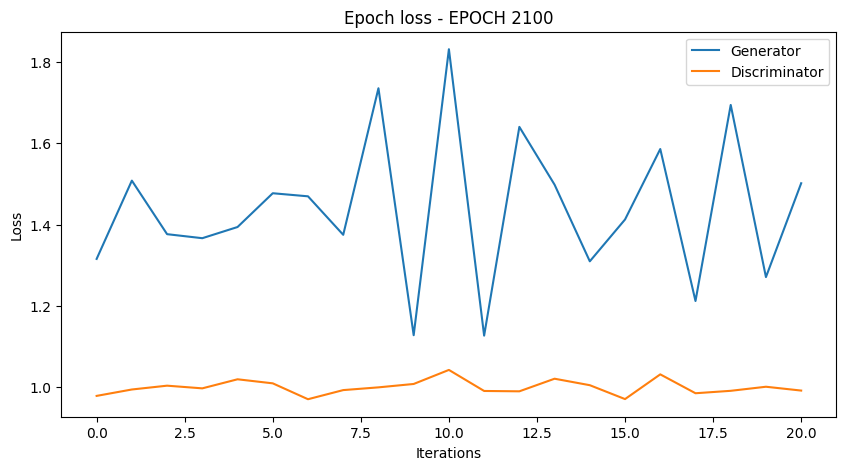

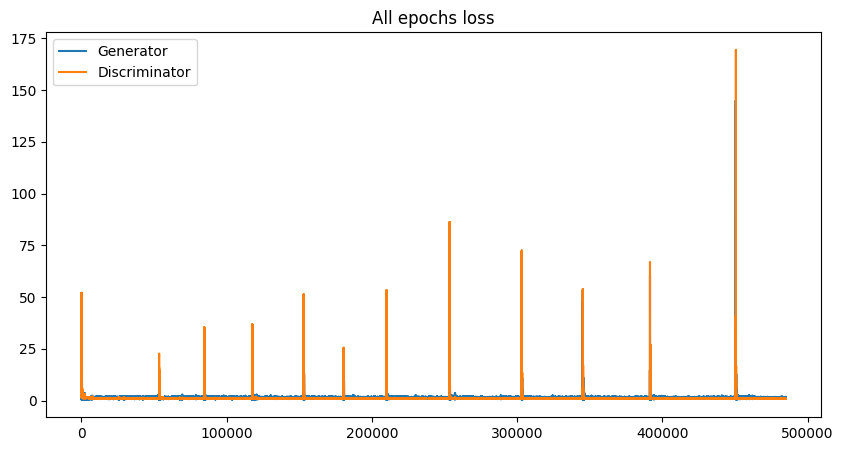

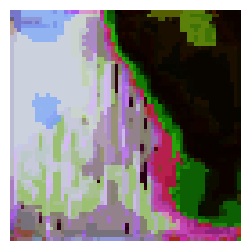

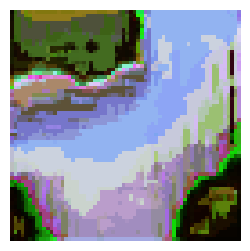

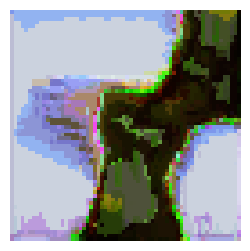

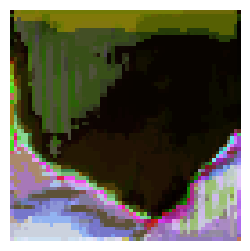

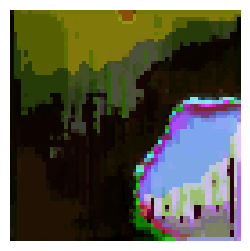

Epoch: 2100 computed for 4.36283278465271 sec
Generator loss mean:  1.4394567  std:  0.18346775
Discriminator loss mean:  0.9993118  std:  0.017801471
Epoch: 2101 computed for 2.8226988315582275 sec
Generator loss mean:  1.4198864  std:  0.16565166
Discriminator loss mean:  1.0085195  std:  0.014476137
Epoch: 2102 computed for 2.8007595539093018 sec
Generator loss mean:  1.4087293  std:  0.16216275
Discriminator loss mean:  1.0032862  std:  0.023678513
Epoch: 2103 computed for 2.8015573024749756 sec
Generator loss mean:  1.4323944  std:  0.14238048
Discriminator loss mean:  0.9933971  std:  0.019150369
Epoch: 2104 computed for 2.801255464553833 sec
Generator loss mean:  1.4355358  std:  0.14813556
Discriminator loss mean:  0.9944392  std:  0.014405399
Epoch: 2105 computed for 2.789581775665283 sec
Generator loss mean:  1.4298303  std:  0.18991998
Discriminator loss mean:  1.0006436  std:  0.020817546
Epoch: 2106 computed for 2.792328119277954 sec
Generator loss mean:  1.447412  std:  0

Epoch: 2154 computed for 2.8010709285736084 sec
Generator loss mean:  1.4326442  std:  0.13048
Discriminator loss mean:  0.9978734  std:  0.018166488
Epoch: 2155 computed for 2.801394462585449 sec
Generator loss mean:  1.4133387  std:  0.15189499
Discriminator loss mean:  0.9991166  std:  0.019503871
Epoch: 2156 computed for 2.8037643432617188 sec
Generator loss mean:  1.449214  std:  0.16180368
Discriminator loss mean:  1.0001296  std:  0.019887326
Epoch: 2157 computed for 2.8268518447875977 sec
Generator loss mean:  1.4395921  std:  0.20147866
Discriminator loss mean:  1.0033602  std:  0.025219835
Epoch: 2158 computed for 2.8026907444000244 sec
Generator loss mean:  1.4185233  std:  0.12503959
Discriminator loss mean:  1.0020896  std:  0.017257843
Epoch: 2159 computed for 2.807044744491577 sec
Generator loss mean:  1.4261328  std:  0.13179296
Discriminator loss mean:  0.9950732  std:  0.017491
Epoch: 2160 computed for 2.8045032024383545 sec
Generator loss mean:  1.4352115  std:  0.19

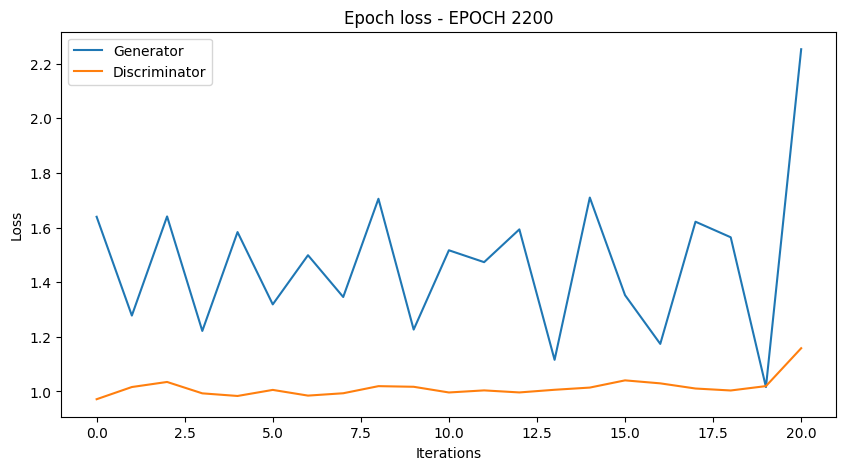

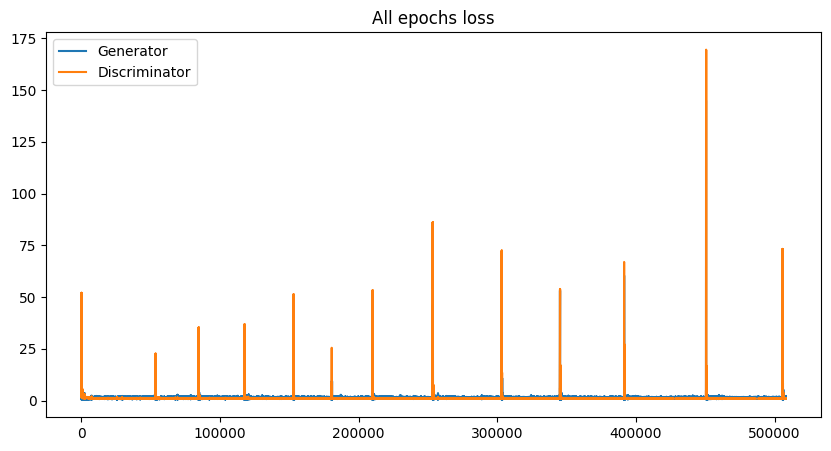

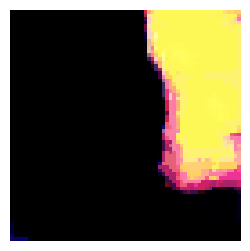

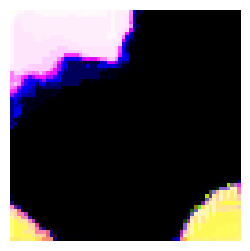

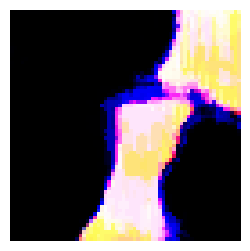

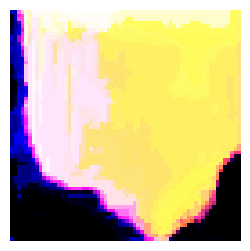

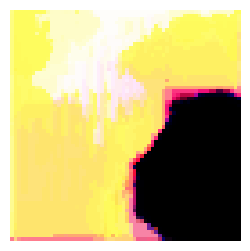

Epoch: 2200 computed for 4.6796770095825195 sec
Generator loss mean:  1.4689814  std:  0.26501113
Discriminator loss mean:  1.0143427  std:  0.036316276
Epoch: 2201 computed for 2.837164878845215 sec
Generator loss mean:  1.4564667  std:  0.34234992
Discriminator loss mean:  1.0278431  std:  0.026793698
Epoch: 2202 computed for 2.8069944381713867 sec
Generator loss mean:  1.4547642  std:  0.25428072
Discriminator loss mean:  1.0170265  std:  0.022508573
Epoch: 2203 computed for 2.806185007095337 sec
Generator loss mean:  1.4391522  std:  0.23094389
Discriminator loss mean:  1.0076728  std:  0.025556387
Epoch: 2204 computed for 2.8149971961975098 sec
Generator loss mean:  1.4593205  std:  0.36996773
Discriminator loss mean:  1.0273688  std:  0.056595378
Epoch: 2205 computed for 2.7988345623016357 sec
Generator loss mean:  1.4039901  std:  0.14703529
Discriminator loss mean:  1.0091959  std:  0.023118539
Epoch: 2206 computed for 2.800042152404785 sec
Generator loss mean:  1.446261  std: 

Epoch: 2254 computed for 2.804110288619995 sec
Generator loss mean:  1.4306059  std:  0.15220436
Discriminator loss mean:  0.99825424  std:  0.020722585
Epoch: 2255 computed for 2.8155834674835205 sec
Generator loss mean:  1.4374809  std:  0.18341191
Discriminator loss mean:  1.0021288  std:  0.019124262
Epoch: 2256 computed for 2.808227300643921 sec
Generator loss mean:  1.425136  std:  0.17672542
Discriminator loss mean:  1.0030435  std:  0.014396681
Epoch: 2257 computed for 2.8254218101501465 sec
Generator loss mean:  1.4205931  std:  0.13176598
Discriminator loss mean:  0.9964327  std:  0.021836275
Epoch: 2258 computed for 2.805135726928711 sec
Generator loss mean:  1.431024  std:  0.16136475
Discriminator loss mean:  1.0003071  std:  0.012508737
Epoch: 2259 computed for 2.801091194152832 sec
Generator loss mean:  1.42854  std:  0.14076068
Discriminator loss mean:  0.9962617  std:  0.019241115
Epoch: 2260 computed for 2.800062417984009 sec
Generator loss mean:  1.406484  std:  0.10

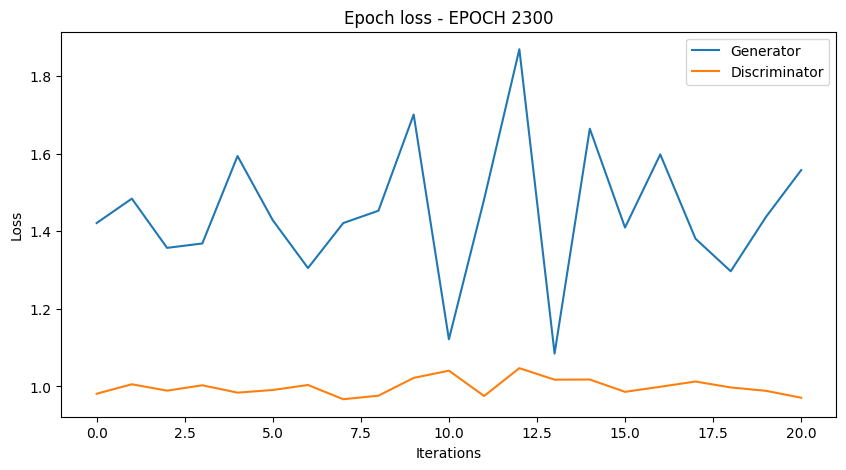

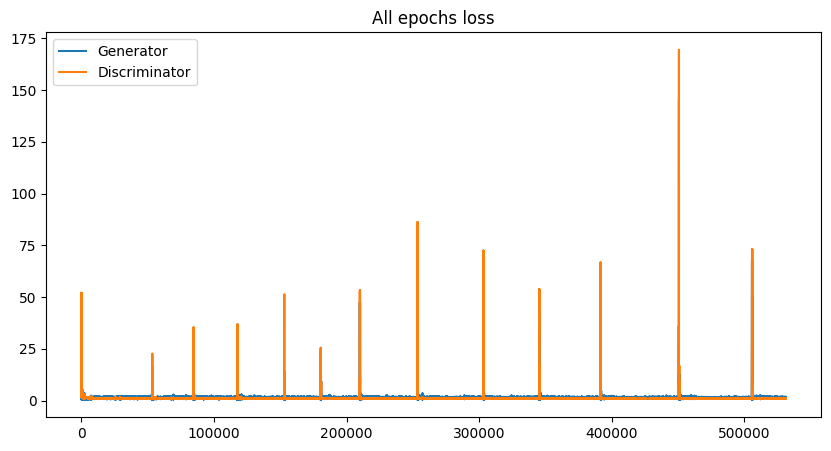

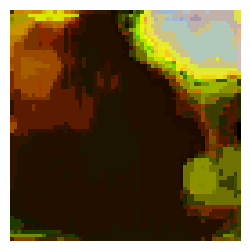

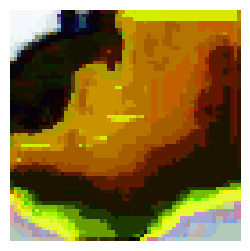

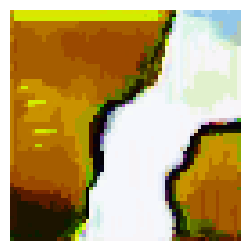

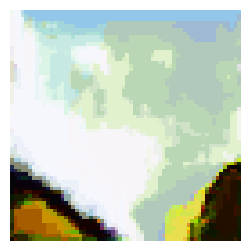

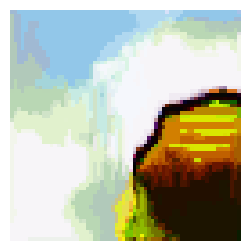

Epoch: 2300 computed for 4.1812584400177 sec
Generator loss mean:  1.449392  std:  0.17605935
Discriminator loss mean:  0.9988357  std:  0.02117391
Epoch: 2301 computed for 2.7967748641967773 sec
Generator loss mean:  1.4352858  std:  0.15148857
Discriminator loss mean:  0.99851483  std:  0.016561046
Epoch: 2302 computed for 2.807493209838867 sec
Generator loss mean:  1.4490232  std:  0.2128974
Discriminator loss mean:  1.0016022  std:  0.021268966
Epoch: 2303 computed for 2.7971463203430176 sec
Generator loss mean:  1.4241251  std:  0.13109425
Discriminator loss mean:  0.9949807  std:  0.015959214
Epoch: 2304 computed for 2.7939751148223877 sec
Generator loss mean:  1.4389925  std:  0.13498917
Discriminator loss mean:  0.9961646  std:  0.019912122
Epoch: 2305 computed for 2.7868354320526123 sec
Generator loss mean:  1.4113486  std:  0.1326367
Discriminator loss mean:  1.0052428  std:  0.016355257
Epoch: 2306 computed for 2.793050527572632 sec
Generator loss mean:  1.4327267  std:  0.1

Epoch: 2354 computed for 2.8042964935302734 sec
Generator loss mean:  1.4363078  std:  0.10719974
Discriminator loss mean:  0.99487394  std:  0.018139826
Epoch: 2355 computed for 2.802121162414551 sec
Generator loss mean:  1.4115832  std:  0.11768269
Discriminator loss mean:  0.9979361  std:  0.018728614
Epoch: 2356 computed for 2.7977454662323 sec
Generator loss mean:  1.4251393  std:  0.13067508
Discriminator loss mean:  0.9970605  std:  0.014110255
Epoch: 2357 computed for 2.799764633178711 sec
Generator loss mean:  1.4188048  std:  0.14236785
Discriminator loss mean:  1.0011278  std:  0.019151676
Epoch: 2358 computed for 2.798413038253784 sec
Generator loss mean:  1.4241812  std:  0.095719226
Discriminator loss mean:  0.99388134  std:  0.019809408
Epoch: 2359 computed for 2.7964978218078613 sec
Generator loss mean:  1.4178174  std:  0.10373587
Discriminator loss mean:  0.9971563  std:  0.0131933065
Epoch: 2360 computed for 2.917935609817505 sec
Generator loss mean:  1.4260467  std:

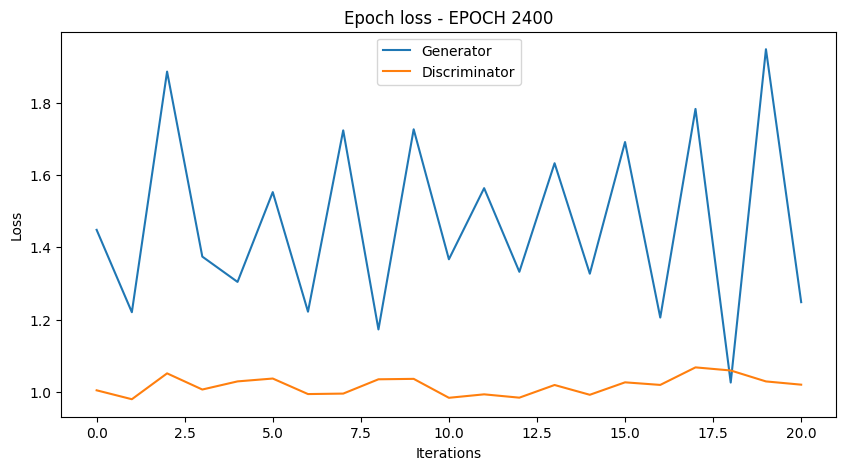

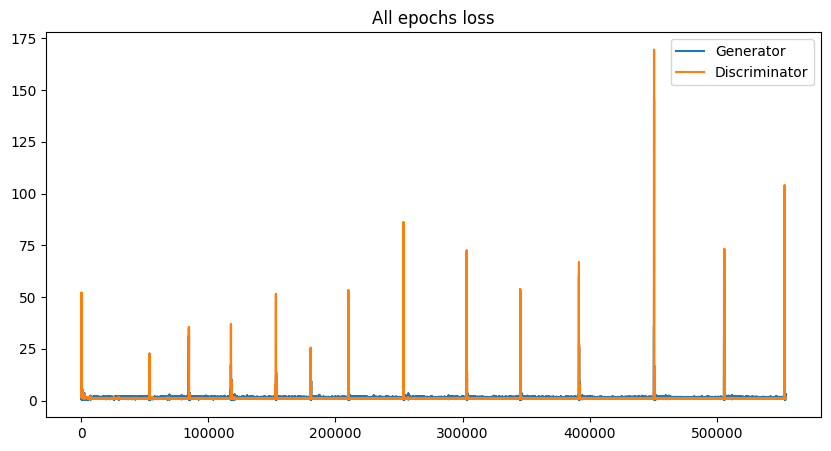

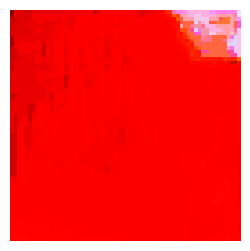

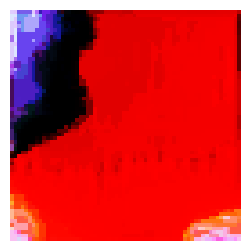

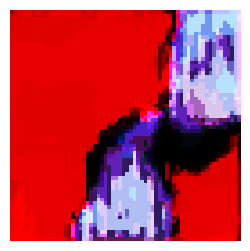

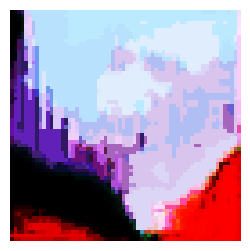

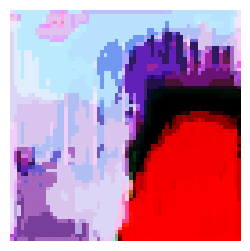

Epoch: 2400 computed for 4.011087894439697 sec
Generator loss mean:  1.4643182  std:  0.25217134
Discriminator loss mean:  1.017072  std:  0.024938373
Epoch: 2401 computed for 2.8066227436065674 sec
Generator loss mean:  1.4660878  std:  0.25154486
Discriminator loss mean:  1.0144091  std:  0.021317935
Epoch: 2402 computed for 2.7966535091400146 sec
Generator loss mean:  1.4578296  std:  0.18101001
Discriminator loss mean:  1.0067087  std:  0.024830146
Epoch: 2403 computed for 2.7956113815307617 sec
Generator loss mean:  1.4303175  std:  0.15688346
Discriminator loss mean:  1.0034862  std:  0.015986415
Epoch: 2404 computed for 2.801543951034546 sec
Generator loss mean:  1.4375693  std:  0.22470215
Discriminator loss mean:  1.009321  std:  0.019248309
Epoch: 2405 computed for 2.7963764667510986 sec
Generator loss mean:  1.4388765  std:  0.18381558
Discriminator loss mean:  1.0006305  std:  0.021658253
Epoch: 2406 computed for 2.8008065223693848 sec
Generator loss mean:  1.4301786  std: 

Epoch: 2454 computed for 5.16474986076355 sec
Generator loss mean:  1.4339502  std:  0.12051467
Discriminator loss mean:  0.99743617  std:  0.021067455
Epoch: 2455 computed for 2.8135998249053955 sec
Generator loss mean:  1.4427868  std:  0.17417108
Discriminator loss mean:  0.99652183  std:  0.01813806
Epoch: 2456 computed for 2.8028573989868164 sec
Generator loss mean:  1.4435343  std:  0.21594447
Discriminator loss mean:  1.0031909  std:  0.023684898
Epoch: 2457 computed for 2.8095598220825195 sec
Generator loss mean:  1.4334049  std:  0.17717336
Discriminator loss mean:  0.9963565  std:  0.026365396
Epoch: 2458 computed for 2.792632579803467 sec
Generator loss mean:  1.433676  std:  0.11707564
Discriminator loss mean:  0.997552  std:  0.013124524
Epoch: 2459 computed for 2.804184675216675 sec
Generator loss mean:  1.437125  std:  0.13768901
Discriminator loss mean:  0.995649  std:  0.013527754
Epoch: 2460 computed for 2.8097033500671387 sec
Generator loss mean:  1.4060193  std:  0.

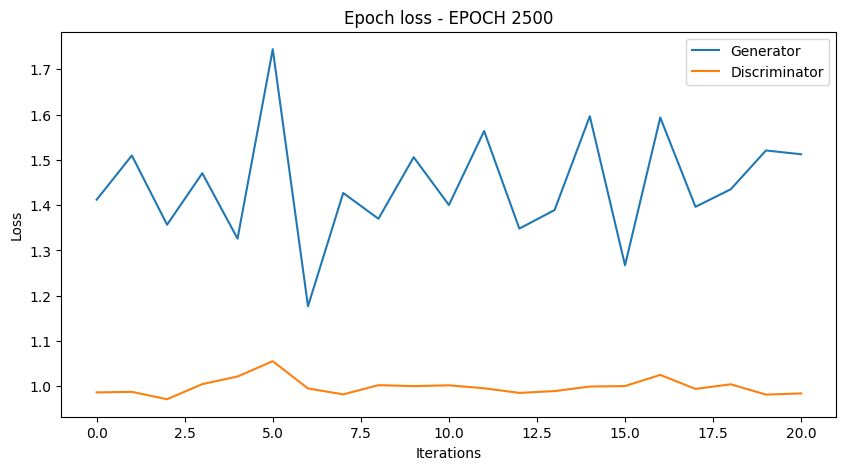

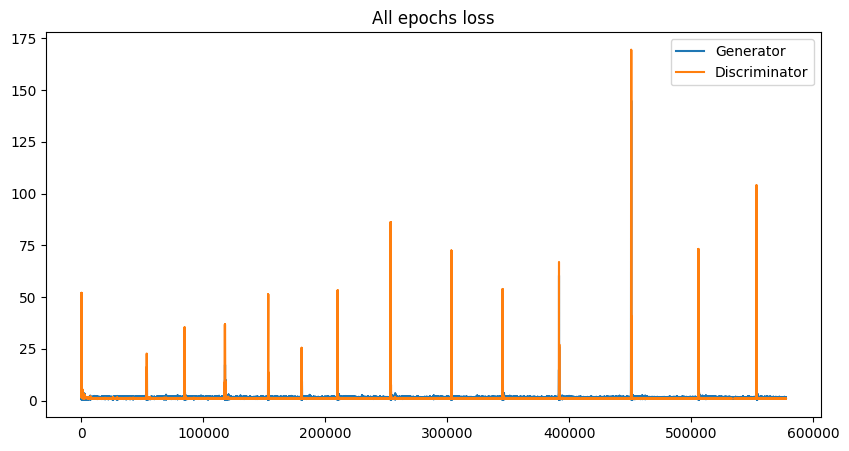

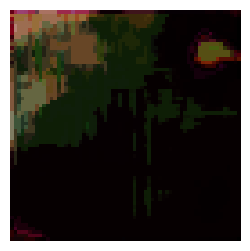

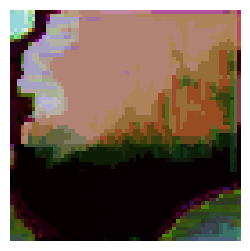

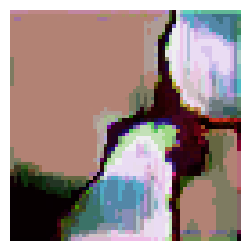

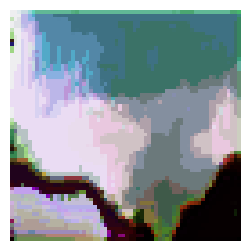

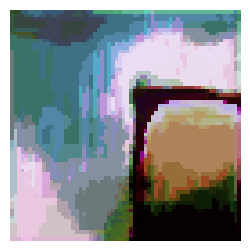

Epoch: 2500 computed for 4.019343614578247 sec
Generator loss mean:  1.4439913  std:  0.1228347
Discriminator loss mean:  0.9986753  std:  0.017777836
Epoch: 2501 computed for 3.062682628631592 sec
Generator loss mean:  1.4150999  std:  0.14380966
Discriminator loss mean:  0.9985596  std:  0.013996528
Epoch: 2502 computed for 3.2372090816497803 sec
Generator loss mean:  1.4200525  std:  0.11512886
Discriminator loss mean:  0.99259883  std:  0.017244859
Epoch: 2503 computed for 2.8981008529663086 sec
Generator loss mean:  1.4438376  std:  0.14433192
Discriminator loss mean:  1.0039425  std:  0.018019903
Epoch: 2504 computed for 2.8049285411834717 sec
Generator loss mean:  1.4238899  std:  0.11443811
Discriminator loss mean:  0.9900754  std:  0.011565039
Epoch: 2505 computed for 2.8039724826812744 sec
Generator loss mean:  1.4078608  std:  0.12172522
Discriminator loss mean:  0.99998885  std:  0.016664412
Epoch: 2506 computed for 2.798685073852539 sec
Generator loss mean:  1.409591  std:

Epoch: 2554 computed for 2.801495313644409 sec
Generator loss mean:  1.4289334  std:  0.092535086
Discriminator loss mean:  0.99035424  std:  0.018104061
Epoch: 2555 computed for 2.80307936668396 sec
Generator loss mean:  1.4286581  std:  0.13753237
Discriminator loss mean:  0.99547505  std:  0.013826328
Epoch: 2556 computed for 2.803068161010742 sec
Generator loss mean:  1.4392042  std:  0.13608281
Discriminator loss mean:  0.99642164  std:  0.019818014
Epoch: 2557 computed for 2.804781198501587 sec
Generator loss mean:  1.423885  std:  0.11553336
Discriminator loss mean:  0.9984784  std:  0.014885581
Epoch: 2558 computed for 2.804370164871216 sec
Generator loss mean:  1.4214947  std:  0.12925154
Discriminator loss mean:  0.9926477  std:  0.016758205
Epoch: 2559 computed for 2.787249803543091 sec
Generator loss mean:  1.4305516  std:  0.12210247
Discriminator loss mean:  0.99971133  std:  0.017682398
Epoch: 2560 computed for 2.7961816787719727 sec
Generator loss mean:  1.4326632  std:

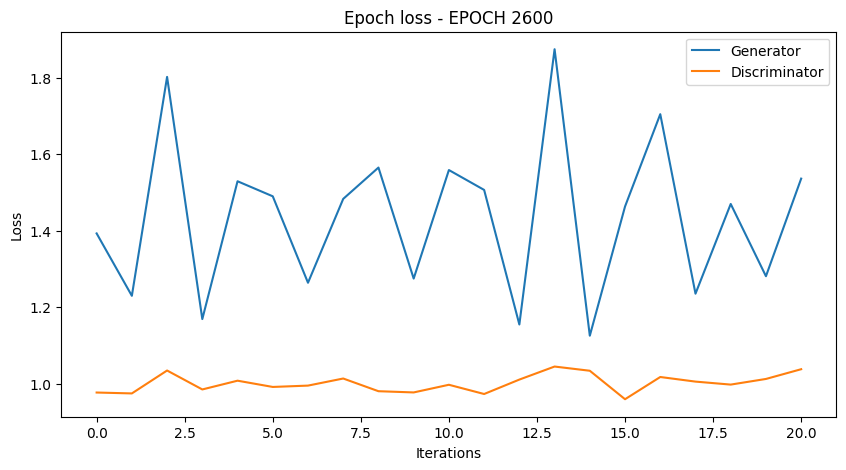

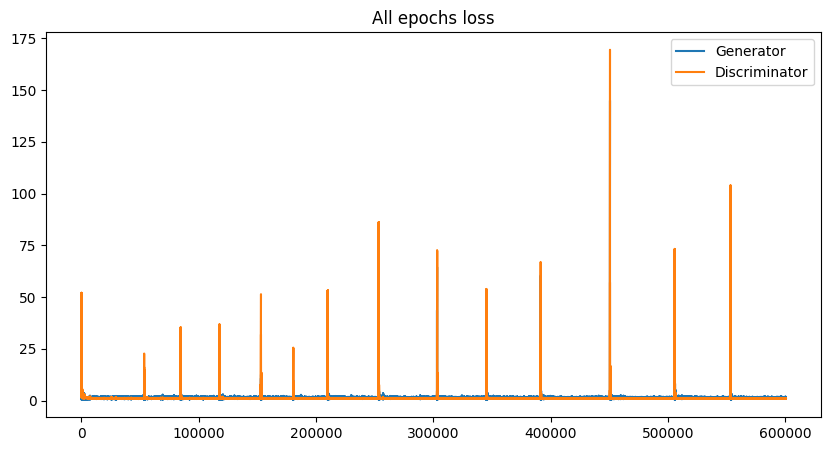

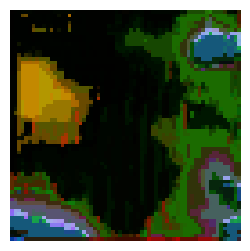

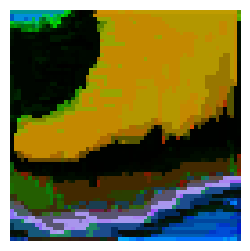

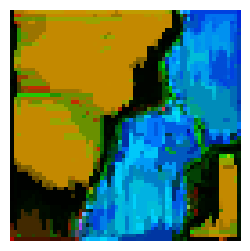

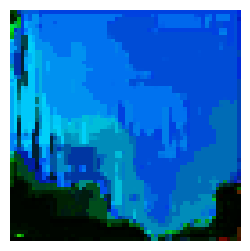

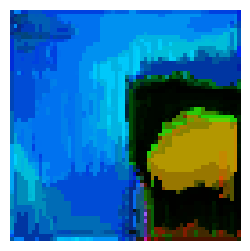

Epoch: 2600 computed for 3.9534752368927 sec
Generator loss mean:  1.4337007  std:  0.20389073
Discriminator loss mean:  1.0008695  std:  0.023310835
Epoch: 2601 computed for 2.805511474609375 sec
Generator loss mean:  1.4324646  std:  0.13065985
Discriminator loss mean:  0.9988089  std:  0.019304413
Epoch: 2602 computed for 2.8091211318969727 sec
Generator loss mean:  1.4477422  std:  0.13016716
Discriminator loss mean:  1.0008268  std:  0.018960029
Epoch: 2603 computed for 2.8141329288482666 sec
Generator loss mean:  1.4188398  std:  0.12563032
Discriminator loss mean:  0.99642354  std:  0.016370099
Epoch: 2604 computed for 2.813447952270508 sec
Generator loss mean:  1.4338326  std:  0.09929344
Discriminator loss mean:  0.9946012  std:  0.019722274
Epoch: 2605 computed for 2.8149874210357666 sec
Generator loss mean:  1.423626  std:  0.11438613
Discriminator loss mean:  1.0042272  std:  0.01564925
Epoch: 2606 computed for 2.813314199447632 sec
Generator loss mean:  1.4356589  std:  0.

Epoch: 2655 computed for 2.8136463165283203 sec
Generator loss mean:  1.4325249  std:  0.20051429
Discriminator loss mean:  0.9996033  std:  0.02088523
Epoch: 2656 computed for 2.812689781188965 sec
Generator loss mean:  1.4187835  std:  0.17536312
Discriminator loss mean:  1.0045683  std:  0.01909005
Epoch: 2657 computed for 2.809985399246216 sec
Generator loss mean:  1.4232879  std:  0.14248508
Discriminator loss mean:  0.9987073  std:  0.01605354
Epoch: 2658 computed for 2.8107547760009766 sec
Generator loss mean:  1.4296293  std:  0.14851756
Discriminator loss mean:  0.99178004  std:  0.0136344135
Epoch: 2659 computed for 2.807412624359131 sec
Generator loss mean:  1.4498949  std:  0.13371243
Discriminator loss mean:  0.99503416  std:  0.01867835
Epoch: 2660 computed for 2.807908535003662 sec
Generator loss mean:  1.4283817  std:  0.12795824
Discriminator loss mean:  0.994871  std:  0.016873218
Epoch: 2661 computed for 2.808321714401245 sec
Generator loss mean:  1.4017129  std:  0.

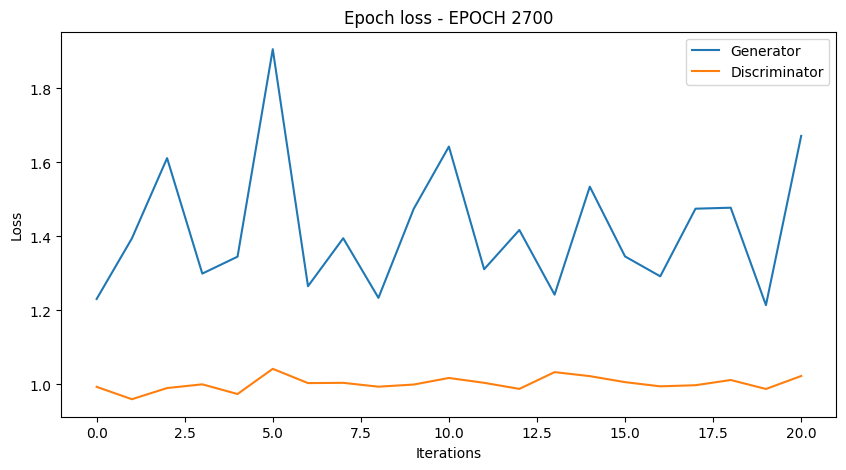

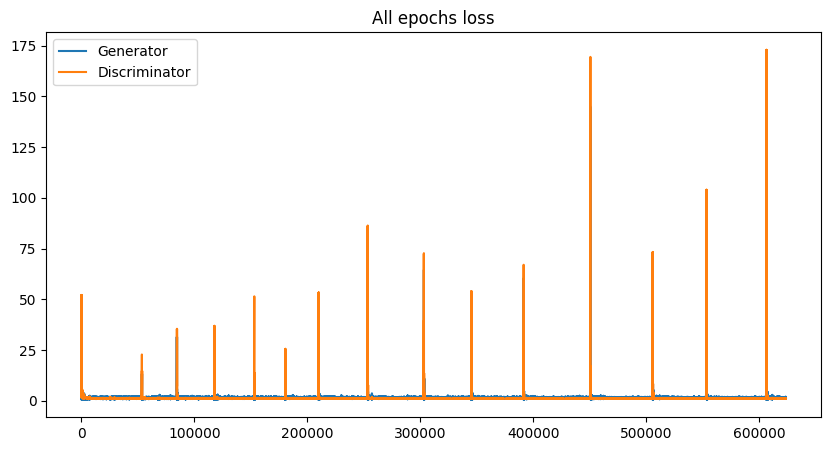

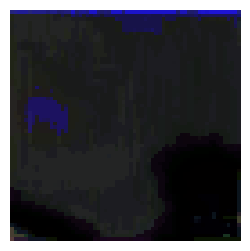

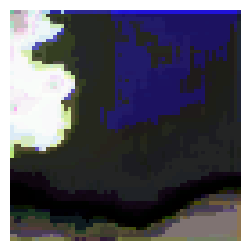

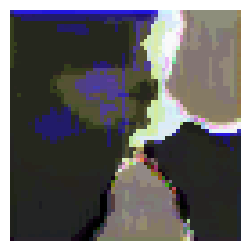

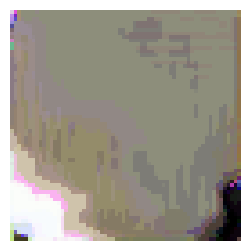

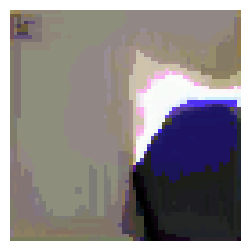

Epoch: 2700 computed for 4.346958160400391 sec
Generator loss mean:  1.4181535  std:  0.17334151
Discriminator loss mean:  1.0023358  std:  0.018390005
Epoch: 2701 computed for 2.829244613647461 sec
Generator loss mean:  1.4179189  std:  0.16983193
Discriminator loss mean:  0.9954151  std:  0.014291811
Epoch: 2702 computed for 2.8081181049346924 sec
Generator loss mean:  1.4193558  std:  0.16893458
Discriminator loss mean:  1.0001894  std:  0.020144954
Epoch: 2703 computed for 2.8076677322387695 sec
Generator loss mean:  1.4334196  std:  0.15208437
Discriminator loss mean:  1.0023217  std:  0.018337956
Epoch: 2704 computed for 2.8127026557922363 sec
Generator loss mean:  1.40965  std:  0.11205053
Discriminator loss mean:  0.99698555  std:  0.013579108
Epoch: 2705 computed for 2.805130958557129 sec
Generator loss mean:  1.4269934  std:  0.18373442
Discriminator loss mean:  0.9961066  std:  0.022777623
Epoch: 2706 computed for 2.8021020889282227 sec
Generator loss mean:  1.4343843  std: 

Epoch: 2754 computed for 2.8053781986236572 sec
Generator loss mean:  1.4123728  std:  0.115676716
Discriminator loss mean:  1.0022297  std:  0.013354572
Epoch: 2755 computed for 2.801694631576538 sec
Generator loss mean:  1.4410511  std:  0.15182638
Discriminator loss mean:  0.9965506  std:  0.01829826
Epoch: 2756 computed for 2.807863235473633 sec
Generator loss mean:  1.4124982  std:  0.12901981
Discriminator loss mean:  0.9947587  std:  0.016413447
Epoch: 2757 computed for 2.803826332092285 sec
Generator loss mean:  1.431753  std:  0.096630685
Discriminator loss mean:  0.9863612  std:  0.014453198
Epoch: 2758 computed for 2.8075063228607178 sec
Generator loss mean:  1.436626  std:  0.10508256
Discriminator loss mean:  0.9924258  std:  0.019981023
Epoch: 2759 computed for 2.803189992904663 sec
Generator loss mean:  1.4131396  std:  0.13998142
Discriminator loss mean:  1.0053426  std:  0.01132347
Epoch: 2760 computed for 2.8864552974700928 sec
Generator loss mean:  1.4123075  std:  0

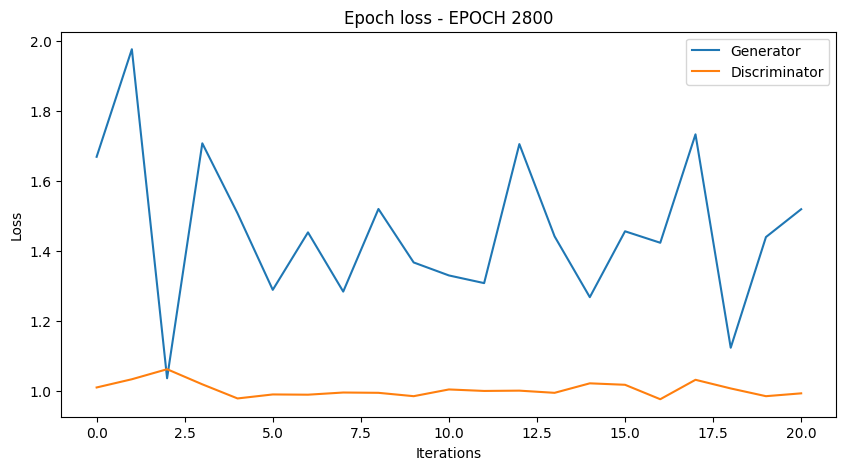

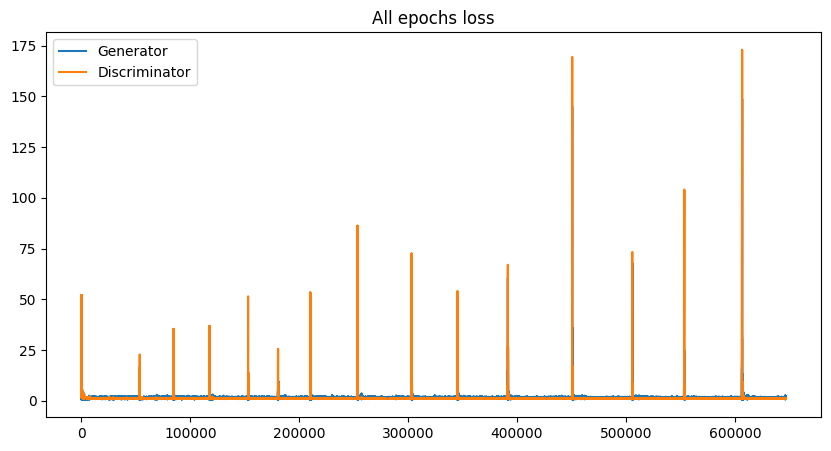

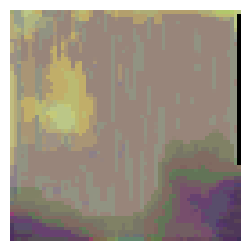

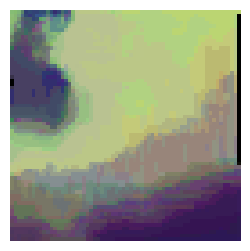

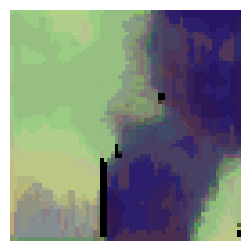

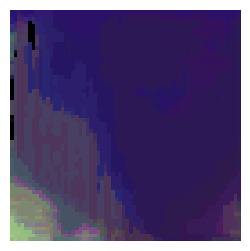

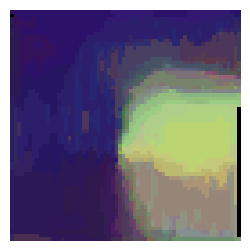

Epoch: 2800 computed for 4.52509617805481 sec
Generator loss mean:  1.4552679  std:  0.21362703
Discriminator loss mean:  1.0038714  std:  0.020398881
Epoch: 2801 computed for 2.827141284942627 sec
Generator loss mean:  1.5009551  std:  0.5581938
Discriminator loss mean:  1.0546176  std:  0.08024246
Epoch: 2802 computed for 2.799441337585449 sec
Generator loss mean:  1.4203931  std:  0.17100266
Discriminator loss mean:  1.002104  std:  0.017904285
Epoch: 2803 computed for 2.8042616844177246 sec
Generator loss mean:  1.4313753  std:  0.18106045
Discriminator loss mean:  0.9986616  std:  0.0185138
Epoch: 2804 computed for 2.8171024322509766 sec
Generator loss mean:  1.449339  std:  0.15593691
Discriminator loss mean:  0.99126655  std:  0.01639926
Epoch: 2805 computed for 2.8086514472961426 sec
Generator loss mean:  1.4202152  std:  0.11368397
Discriminator loss mean:  0.9947499  std:  0.019005038
Epoch: 2806 computed for 2.808495044708252 sec
Generator loss mean:  1.4333646  std:  0.0770

Epoch: 2854 computed for 2.8568499088287354 sec
Generator loss mean:  1.4244616  std:  0.15268433
Discriminator loss mean:  0.9991566  std:  0.015135846
Epoch: 2855 computed for 2.812671422958374 sec
Generator loss mean:  1.4355618  std:  0.10612553
Discriminator loss mean:  0.9976754  std:  0.01884733
Epoch: 2856 computed for 2.825117349624634 sec
Generator loss mean:  1.4199955  std:  0.15976766
Discriminator loss mean:  0.9995755  std:  0.016631665
Epoch: 2857 computed for 2.7990562915802 sec
Generator loss mean:  1.4431341  std:  0.21758829
Discriminator loss mean:  1.0021791  std:  0.015557391
Epoch: 2858 computed for 2.8105709552764893 sec
Generator loss mean:  1.4273779  std:  0.13893144
Discriminator loss mean:  1.0037477  std:  0.01618593
Epoch: 2859 computed for 2.8046698570251465 sec
Generator loss mean:  1.4353952  std:  0.19827724
Discriminator loss mean:  1.0041926  std:  0.020124452
Epoch: 2860 computed for 2.8027117252349854 sec
Generator loss mean:  1.4393679  std:  0.

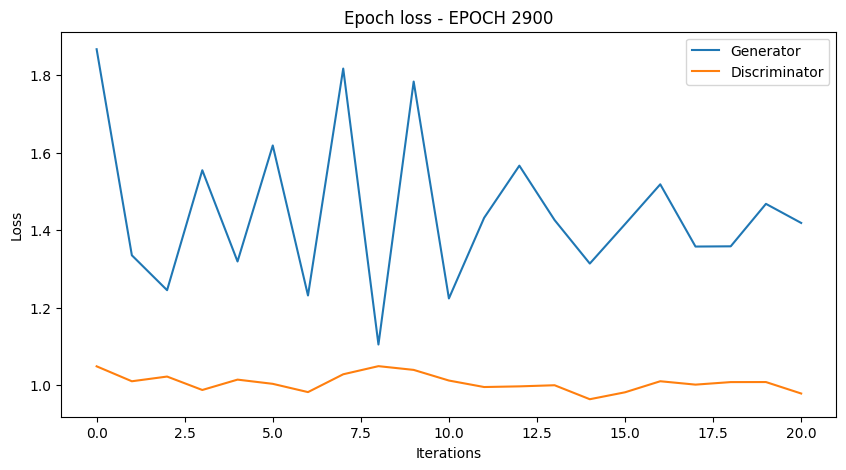

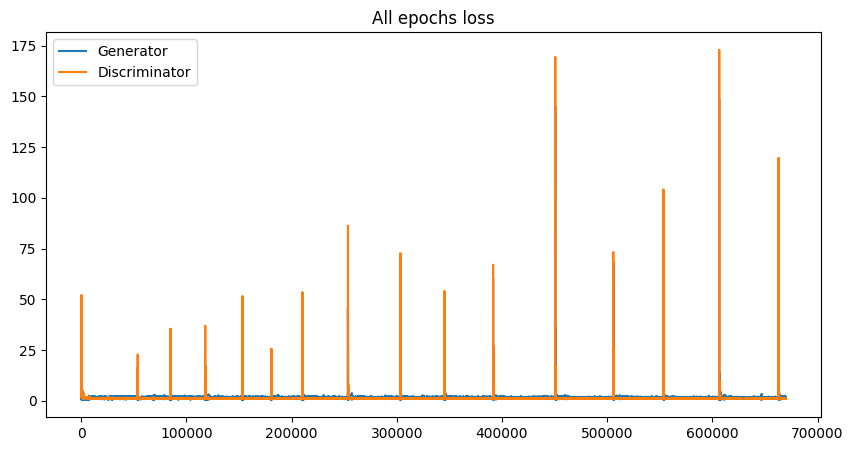

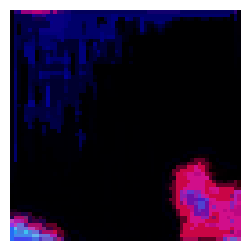

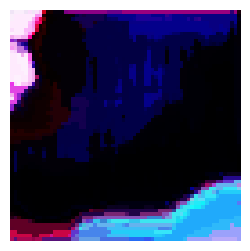

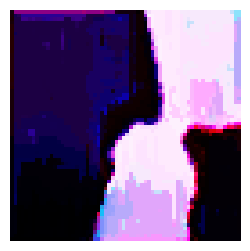

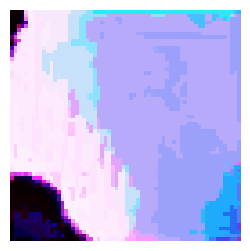

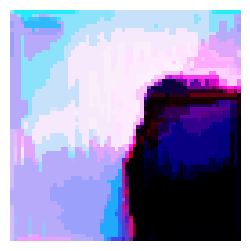

Epoch: 2900 computed for 5.310092210769653 sec
Generator loss mean:  1.4467931  std:  0.19596393
Discriminator loss mean:  1.006988  std:  0.021815501
Epoch: 2901 computed for 2.829355001449585 sec
Generator loss mean:  1.428936  std:  0.13403279
Discriminator loss mean:  0.99632525  std:  0.017017173
Epoch: 2902 computed for 2.8105642795562744 sec
Generator loss mean:  1.3985097  std:  0.11766339
Discriminator loss mean:  1.0075982  std:  0.014912665
Epoch: 2903 computed for 2.8084170818328857 sec
Generator loss mean:  1.4326131  std:  0.21963498
Discriminator loss mean:  1.0022206  std:  0.026374133
Epoch: 2904 computed for 2.813892364501953 sec
Generator loss mean:  1.4346771  std:  0.14913031
Discriminator loss mean:  0.99922526  std:  0.017714502
Epoch: 2905 computed for 2.80935001373291 sec
Generator loss mean:  1.412599  std:  0.13363592
Discriminator loss mean:  1.0029294  std:  0.012404903
Epoch: 2906 computed for 2.813866138458252 sec
Generator loss mean:  1.4129263  std:  0.

Epoch: 2954 computed for 2.809415578842163 sec
Generator loss mean:  1.4282541  std:  0.15279324
Discriminator loss mean:  1.0036  std:  0.017802803
Epoch: 2955 computed for 2.8081727027893066 sec
Generator loss mean:  1.432869  std:  0.14059694
Discriminator loss mean:  1.0001024  std:  0.017396087
Epoch: 2956 computed for 2.8232498168945312 sec
Generator loss mean:  1.4184902  std:  0.21723996
Discriminator loss mean:  1.0033671  std:  0.020388493
Epoch: 2957 computed for 2.7996394634246826 sec
Generator loss mean:  1.423447  std:  0.15864715
Discriminator loss mean:  1.0004199  std:  0.020031597
Epoch: 2958 computed for 2.8191869258880615 sec
Generator loss mean:  1.4258235  std:  0.14935781
Discriminator loss mean:  1.0003864  std:  0.01741416
Epoch: 2959 computed for 2.807001829147339 sec
Generator loss mean:  1.4432676  std:  0.21716304
Discriminator loss mean:  1.0067956  std:  0.018470319
Epoch: 2960 computed for 2.8135874271392822 sec
Generator loss mean:  1.4270254  std:  0.1

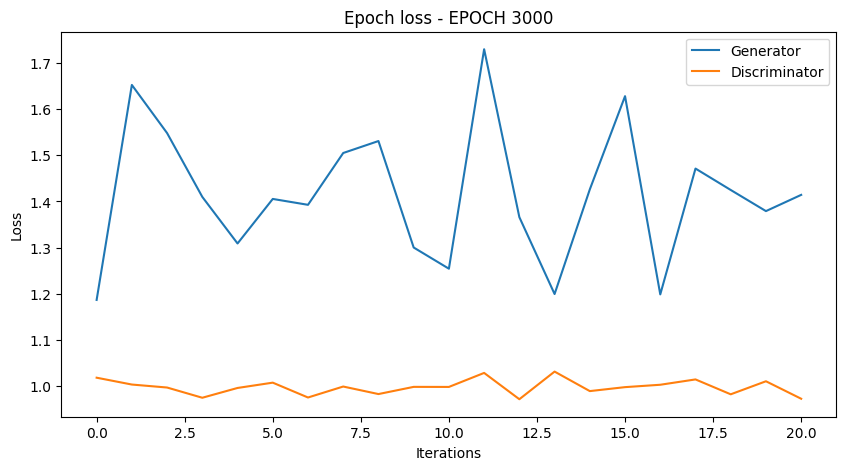

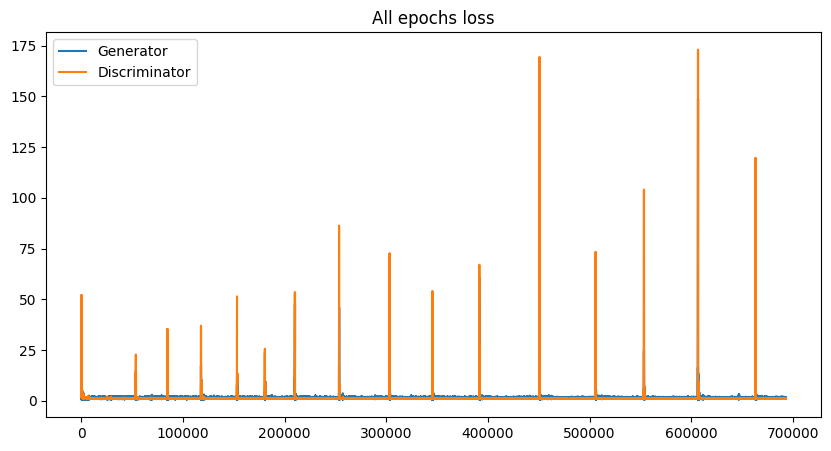

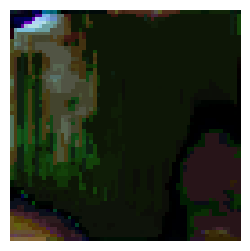

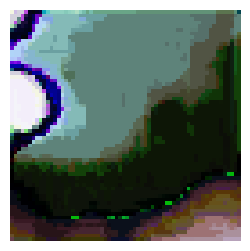

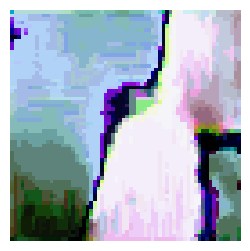

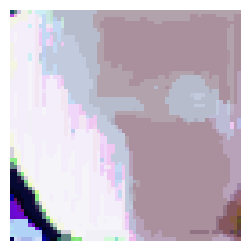

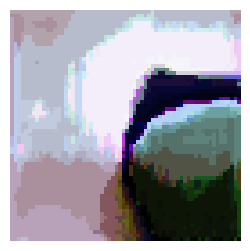

Epoch: 3000 computed for 4.539803981781006 sec
Generator loss mean:  1.4156836  std:  0.14535528
Discriminator loss mean:  0.9974219  std:  0.016895525
Epoch: 3001 computed for 2.8579084873199463 sec
Generator loss mean:  1.4276433  std:  0.1381659
Discriminator loss mean:  0.9964723  std:  0.015808532
Epoch: 3002 computed for 2.8127105236053467 sec
Generator loss mean:  1.4424816  std:  0.15867108
Discriminator loss mean:  0.9888235  std:  0.015908152
Epoch: 3003 computed for 2.801923990249634 sec
Generator loss mean:  1.4355928  std:  0.14710437
Discriminator loss mean:  0.99812853  std:  0.016213953
Epoch: 3004 computed for 2.8058362007141113 sec
Generator loss mean:  1.4133775  std:  0.14891495
Discriminator loss mean:  1.0043144  std:  0.015492215
Epoch: 3005 computed for 2.8042068481445312 sec
Generator loss mean:  1.4167793  std:  0.15005623
Discriminator loss mean:  0.9973387  std:  0.016258884
Epoch: 3006 computed for 2.79931902885437 sec
Generator loss mean:  1.4367197  std: 

Epoch: 3054 computed for 2.811854600906372 sec
Generator loss mean:  1.4218341  std:  0.15315506
Discriminator loss mean:  0.99508387  std:  0.020535188
Epoch: 3055 computed for 2.808943510055542 sec
Generator loss mean:  1.431698  std:  0.18403745
Discriminator loss mean:  1.004588  std:  0.013706217
Epoch: 3056 computed for 2.8078627586364746 sec
Generator loss mean:  1.4378393  std:  0.15001538
Discriminator loss mean:  0.9943844  std:  0.022528712
Epoch: 3057 computed for 2.815831422805786 sec
Generator loss mean:  1.4150656  std:  0.12126002
Discriminator loss mean:  0.99732727  std:  0.010668219
Epoch: 3058 computed for 2.809108018875122 sec
Generator loss mean:  1.4246558  std:  0.1162421
Discriminator loss mean:  0.9981387  std:  0.01666018
Epoch: 3059 computed for 2.816215753555298 sec
Generator loss mean:  1.4516492  std:  0.19901772
Discriminator loss mean:  0.99860626  std:  0.013119298
Epoch: 3060 computed for 2.79949951171875 sec
Generator loss mean:  1.4189775  std:  0.1

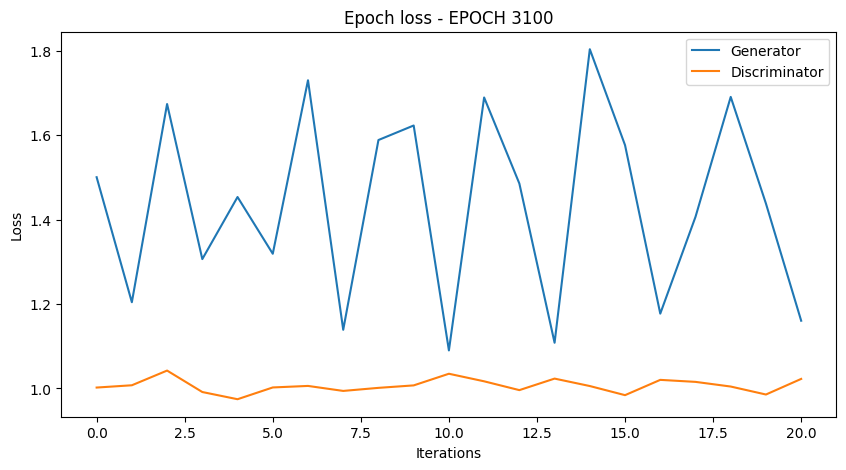

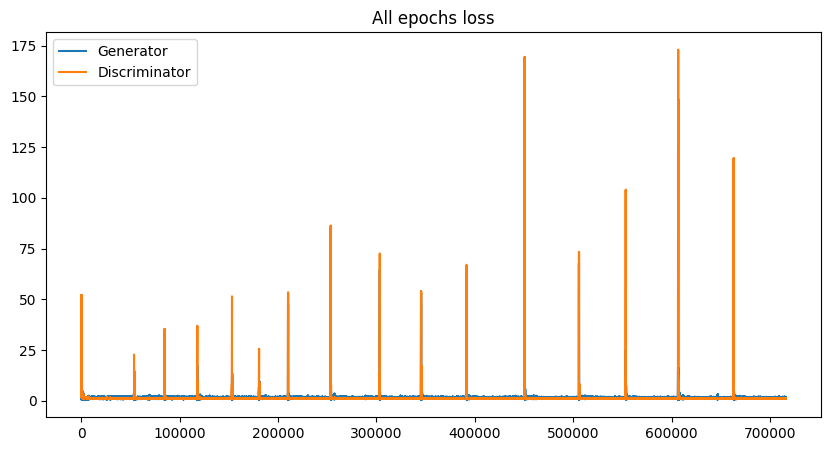

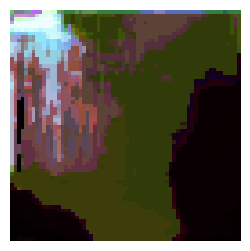

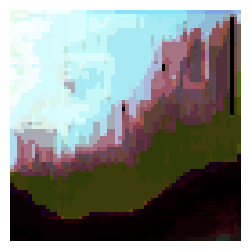

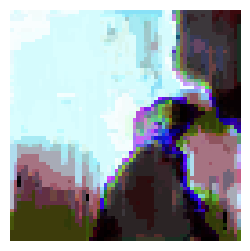

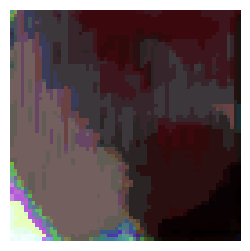

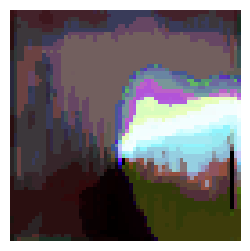

Epoch: 3100 computed for 5.021716594696045 sec
Generator loss mean:  1.4365416  std:  0.2221635
Discriminator loss mean:  1.0065001  std:  0.0162359
Epoch: 3101 computed for 2.8500442504882812 sec
Generator loss mean:  1.4305655  std:  0.16629755
Discriminator loss mean:  0.9998889  std:  0.018726975
Epoch: 3102 computed for 2.8076231479644775 sec
Generator loss mean:  1.4192157  std:  0.1595104
Discriminator loss mean:  1.0045593  std:  0.024070302
Epoch: 3103 computed for 2.812441349029541 sec
Generator loss mean:  1.4122196  std:  0.13919069
Discriminator loss mean:  1.0007074  std:  0.017333716
Epoch: 3104 computed for 2.8220064640045166 sec
Generator loss mean:  1.4295588  std:  0.18416838
Discriminator loss mean:  1.0096388  std:  0.018895477
Epoch: 3105 computed for 2.8137238025665283 sec
Generator loss mean:  1.4198878  std:  0.15502761
Discriminator loss mean:  0.99603283  std:  0.023446197
Epoch: 3106 computed for 2.8377058506011963 sec
Generator loss mean:  1.4389174  std:  

Epoch: 3154 computed for 2.817331552505493 sec
Generator loss mean:  1.4407419  std:  0.22012241
Discriminator loss mean:  1.0110152  std:  0.027581977
Epoch: 3155 computed for 2.8004345893859863 sec
Generator loss mean:  1.4376886  std:  0.19678439
Discriminator loss mean:  1.009618  std:  0.01793132
Epoch: 3156 computed for 2.8105530738830566 sec
Generator loss mean:  1.4182631  std:  0.14565828
Discriminator loss mean:  1.0046396  std:  0.019781673
Epoch: 3157 computed for 2.8139491081237793 sec
Generator loss mean:  1.4501132  std:  0.13154705
Discriminator loss mean:  1.0033894  std:  0.021843355
Epoch: 3158 computed for 2.807138204574585 sec
Generator loss mean:  1.4295678  std:  0.20198312
Discriminator loss mean:  1.0054123  std:  0.022842186
Epoch: 3159 computed for 2.8086187839508057 sec
Generator loss mean:  1.435342  std:  0.12805735
Discriminator loss mean:  0.99642193  std:  0.012561248
Epoch: 3160 computed for 2.9181647300720215 sec
Generator loss mean:  1.4236758  std: 

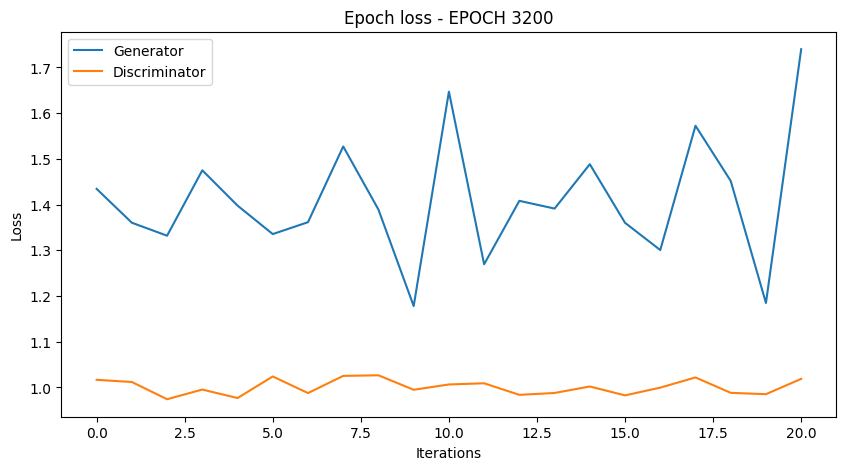

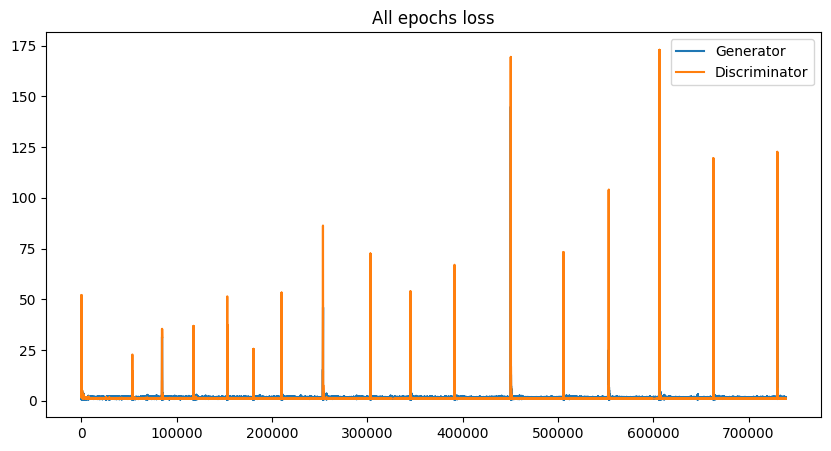

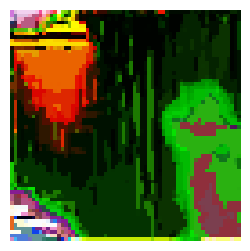

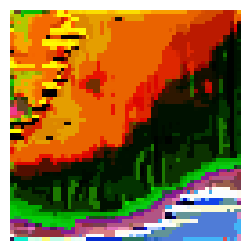

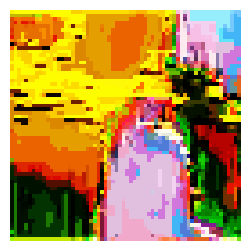

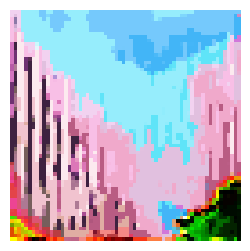

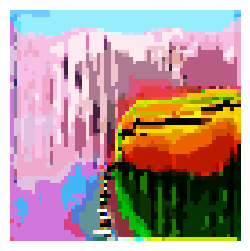

Epoch: 3200 computed for 4.347639083862305 sec
Generator loss mean:  1.40968  std:  0.13345076
Discriminator loss mean:  1.0008411  std:  0.016554784
Epoch: 3201 computed for 2.836803674697876 sec
Generator loss mean:  1.4487985  std:  0.19235629
Discriminator loss mean:  0.9986298  std:  0.016104806
Epoch: 3202 computed for 2.813110589981079 sec
Generator loss mean:  1.4260395  std:  0.12518951
Discriminator loss mean:  0.9945934  std:  0.014486328
Epoch: 3203 computed for 2.8062431812286377 sec
Generator loss mean:  1.4275756  std:  0.12770595
Discriminator loss mean:  0.9949134  std:  0.019105295
Epoch: 3204 computed for 2.8178539276123047 sec
Generator loss mean:  1.4290334  std:  0.16434436
Discriminator loss mean:  1.0010043  std:  0.015978176
Epoch: 3205 computed for 2.797248601913452 sec
Generator loss mean:  1.4324926  std:  0.15916839
Discriminator loss mean:  0.9994764  std:  0.017556053
Epoch: 3206 computed for 2.8311522006988525 sec
Generator loss mean:  1.4305971  std:  0

Epoch: 3254 computed for 2.846677541732788 sec
Generator loss mean:  1.4210601  std:  0.1512675
Discriminator loss mean:  0.99757624  std:  0.014636415
Epoch: 3255 computed for 2.8244388103485107 sec
Generator loss mean:  1.4399846  std:  0.15577851
Discriminator loss mean:  0.9926055  std:  0.01785572
Epoch: 3256 computed for 2.821354389190674 sec
Generator loss mean:  1.4159437  std:  0.11196492
Discriminator loss mean:  0.99866486  std:  0.014781358
Epoch: 3257 computed for 2.822718620300293 sec
Generator loss mean:  1.4465693  std:  0.14868917
Discriminator loss mean:  0.99391663  std:  0.015978271
Epoch: 3258 computed for 2.817474126815796 sec
Generator loss mean:  1.4248343  std:  0.14411026
Discriminator loss mean:  0.9976892  std:  0.01813138
Epoch: 3259 computed for 2.8120157718658447 sec
Generator loss mean:  1.4017289  std:  0.13310668
Discriminator loss mean:  1.0012357  std:  0.016949728
Epoch: 3260 computed for 2.8187153339385986 sec
Generator loss mean:  1.441878  std:  

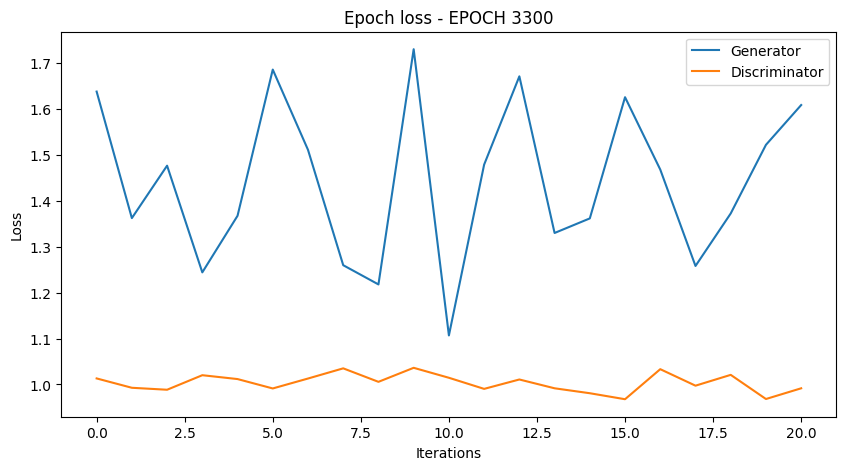

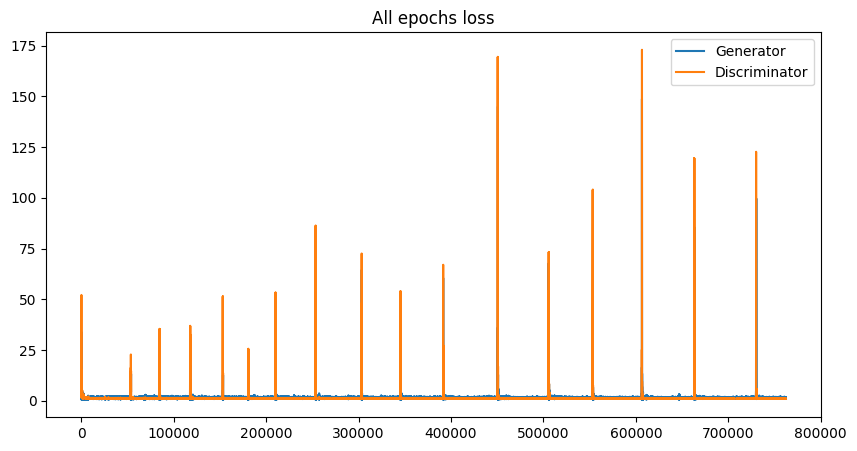

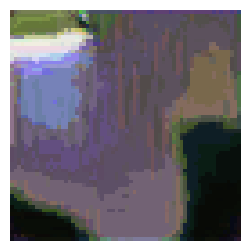

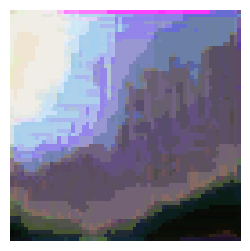

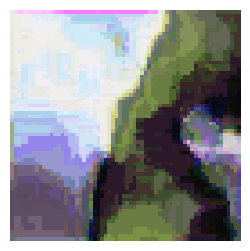

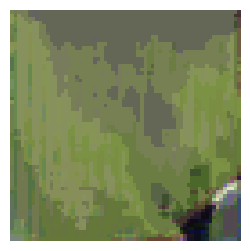

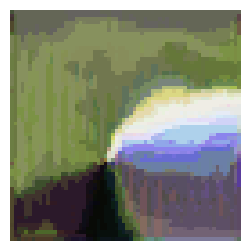

Epoch: 3300 computed for 4.292252063751221 sec
Generator loss mean:  1.4422667  std:  0.17077798
Discriminator loss mean:  1.0036397  std:  0.019463696
Epoch: 3301 computed for 2.8110976219177246 sec
Generator loss mean:  1.4092988  std:  0.09496381
Discriminator loss mean:  0.9963369  std:  0.018060459
Epoch: 3302 computed for 2.8140640258789062 sec
Generator loss mean:  1.4152449  std:  0.11050667
Discriminator loss mean:  0.9979434  std:  0.017462125
Epoch: 3303 computed for 2.8146660327911377 sec
Generator loss mean:  1.4233774  std:  0.092393026
Discriminator loss mean:  0.99463516  std:  0.017478766
Epoch: 3304 computed for 2.81046986579895 sec
Generator loss mean:  1.4256986  std:  0.10403823
Discriminator loss mean:  0.9937893  std:  0.01674517
Epoch: 3305 computed for 2.8099277019500732 sec
Generator loss mean:  1.4213823  std:  0.1302873
Discriminator loss mean:  0.99632853  std:  0.015934015
Epoch: 3306 computed for 2.810819625854492 sec
Generator loss mean:  1.4301805  std:

Epoch: 3354 computed for 2.8209242820739746 sec
Generator loss mean:  1.513912  std:  0.45623037
Discriminator loss mean:  1.0563198  std:  0.07804262
Epoch: 3355 computed for 2.8151886463165283 sec
Generator loss mean:  1.4634676  std:  0.23265813
Discriminator loss mean:  1.0156314  std:  0.021802025
Epoch: 3356 computed for 2.815497398376465 sec
Generator loss mean:  1.4523089  std:  0.25971925
Discriminator loss mean:  1.0133054  std:  0.018629111
Epoch: 3357 computed for 2.80568528175354 sec
Generator loss mean:  1.4845155  std:  0.20659858
Discriminator loss mean:  1.0058594  std:  0.023966515
Epoch: 3358 computed for 2.8186371326446533 sec
Generator loss mean:  1.4747187  std:  0.2832959
Discriminator loss mean:  1.0095934  std:  0.022323016
Epoch: 3359 computed for 2.8203370571136475 sec
Generator loss mean:  1.4121157  std:  0.36230057
Discriminator loss mean:  1.0356975  std:  0.08484025
Epoch: 3360 computed for 2.804166078567505 sec
Generator loss mean:  1.4389416  std:  0.3

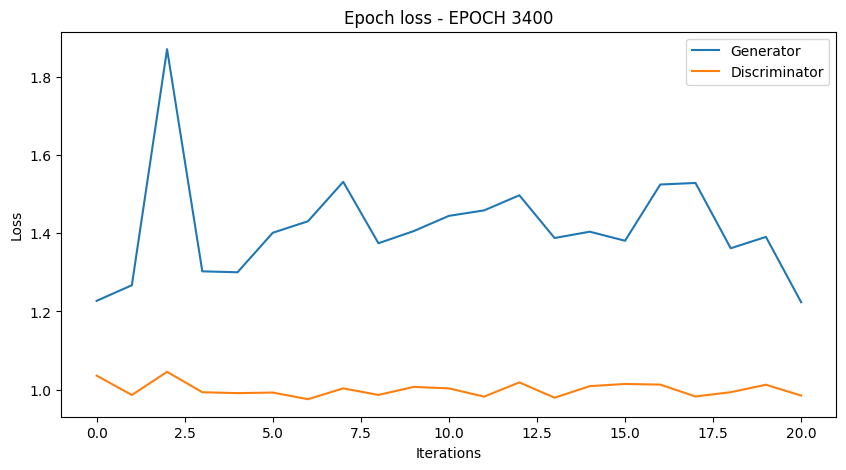

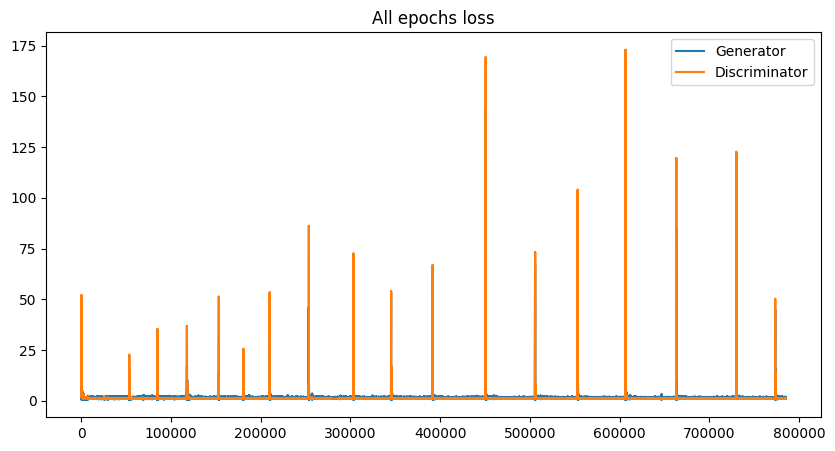

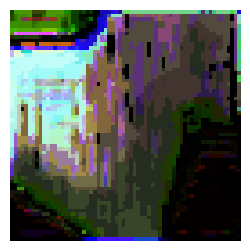

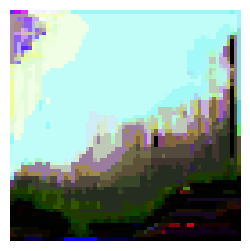

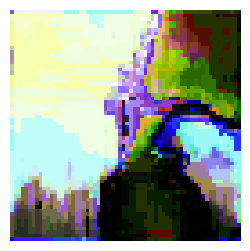

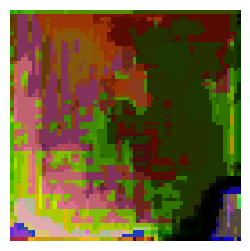

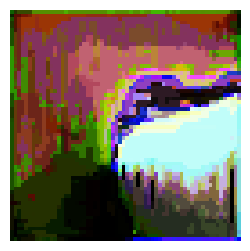

Epoch: 3400 computed for 4.1000025272369385 sec
Generator loss mean:  1.4145969  std:  0.13492188
Discriminator loss mean:  1.0005592  std:  0.018052392
Epoch: 3401 computed for 2.815539598464966 sec
Generator loss mean:  1.4227011  std:  0.13481908
Discriminator loss mean:  0.99914813  std:  0.021420937
Epoch: 3402 computed for 2.808701515197754 sec
Generator loss mean:  1.4405463  std:  0.1330881
Discriminator loss mean:  0.9924966  std:  0.0141865695
Epoch: 3403 computed for 2.8297860622406006 sec
Generator loss mean:  1.4159673  std:  0.14998835
Discriminator loss mean:  1.0010036  std:  0.017865704
Epoch: 3404 computed for 2.81831431388855 sec
Generator loss mean:  1.4416617  std:  0.20125146
Discriminator loss mean:  0.9979495  std:  0.016203877
Epoch: 3405 computed for 2.8257429599761963 sec
Generator loss mean:  1.4301844  std:  0.15030156
Discriminator loss mean:  0.99960226  std:  0.020020206
Epoch: 3406 computed for 2.813295841217041 sec
Generator loss mean:  1.4119833  std:

Epoch: 3454 computed for 2.8133432865142822 sec
Generator loss mean:  1.4377047  std:  0.18465666
Discriminator loss mean:  1.0040296  std:  0.021098949
Epoch: 3455 computed for 2.804368257522583 sec
Generator loss mean:  1.4271128  std:  0.14837733
Discriminator loss mean:  0.9975945  std:  0.015710665
Epoch: 3456 computed for 2.8120014667510986 sec
Generator loss mean:  1.4346236  std:  0.17687921
Discriminator loss mean:  1.0030705  std:  0.021472737
Epoch: 3457 computed for 2.8154563903808594 sec
Generator loss mean:  1.4357386  std:  0.13874198
Discriminator loss mean:  0.99144083  std:  0.014839437
Epoch: 3458 computed for 2.8227601051330566 sec
Generator loss mean:  1.4217407  std:  0.1408675
Discriminator loss mean:  0.995762  std:  0.014660139
Epoch: 3459 computed for 2.8222875595092773 sec
Generator loss mean:  1.4227604  std:  0.09761073
Discriminator loss mean:  0.99847376  std:  0.013706493
Epoch: 3460 computed for 2.8311662673950195 sec
Generator loss mean:  1.4210173  st

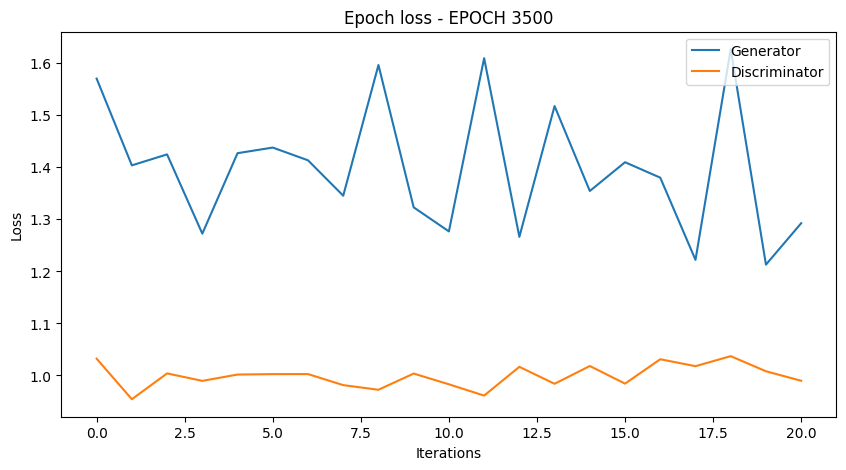

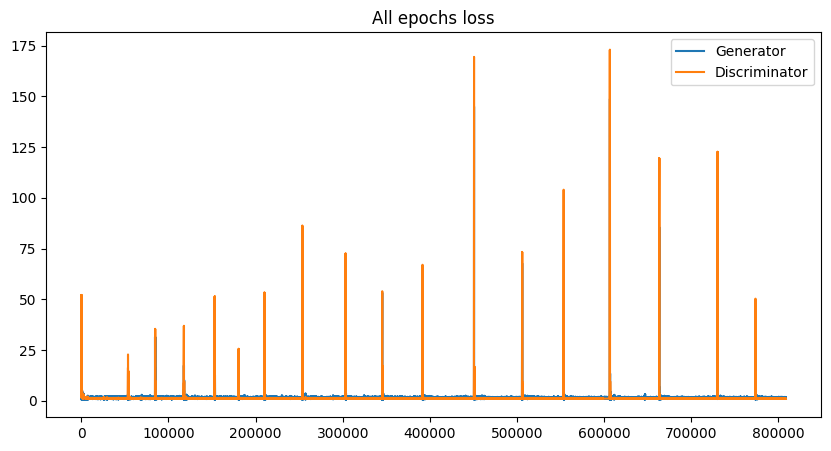

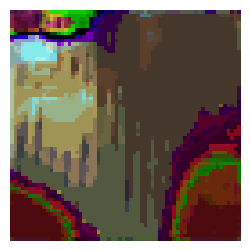

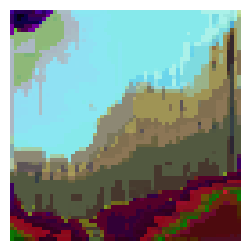

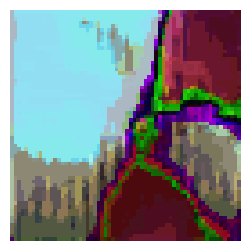

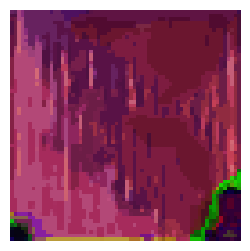

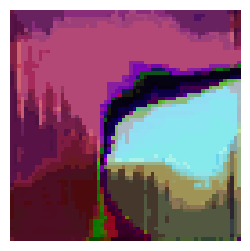

Epoch: 3500 computed for 4.184054136276245 sec
Generator loss mean:  1.3993537  std:  0.12324754
Discriminator loss mean:  0.99887776  std:  0.021913083
Epoch: 3501 computed for 2.822026014328003 sec
Generator loss mean:  1.4473094  std:  0.13176464
Discriminator loss mean:  0.9950391  std:  0.012929204
Epoch: 3502 computed for 2.805553436279297 sec
Generator loss mean:  1.4317228  std:  0.09729453
Discriminator loss mean:  0.9874595  std:  0.012298509
Epoch: 3503 computed for 2.8219106197357178 sec
Generator loss mean:  1.4326596  std:  0.20722835
Discriminator loss mean:  0.99363464  std:  0.01470204
Epoch: 3504 computed for 2.8181703090667725 sec
Generator loss mean:  1.4326997  std:  0.12172469
Discriminator loss mean:  0.9932244  std:  0.013808436
Epoch: 3505 computed for 2.8147497177124023 sec
Generator loss mean:  1.4295886  std:  0.1172772
Discriminator loss mean:  0.99520946  std:  0.018190922
Epoch: 3506 computed for 2.813401937484741 sec
Generator loss mean:  1.4260564  std:

Epoch: 3554 computed for 2.81847882270813 sec
Generator loss mean:  1.4548461  std:  0.21085258
Discriminator loss mean:  1.0024258  std:  0.020330632
Epoch: 3555 computed for 2.809800624847412 sec
Generator loss mean:  1.432822  std:  0.1705
Discriminator loss mean:  0.9942357  std:  0.021941872
Epoch: 3556 computed for 2.8165462017059326 sec
Generator loss mean:  1.4454334  std:  0.21083039
Discriminator loss mean:  1.0085002  std:  0.022464754
Epoch: 3557 computed for 2.8287856578826904 sec
Generator loss mean:  1.4431859  std:  0.132179
Discriminator loss mean:  0.99791807  std:  0.016590571
Epoch: 3558 computed for 2.828516721725464 sec
Generator loss mean:  1.4170684  std:  0.110474385
Discriminator loss mean:  0.9940286  std:  0.018893825
Epoch: 3559 computed for 2.8257017135620117 sec
Generator loss mean:  1.4425763  std:  0.18056619
Discriminator loss mean:  1.002828  std:  0.021127382
Epoch: 3560 computed for 2.9025301933288574 sec
Generator loss mean:  1.4321162  std:  0.129

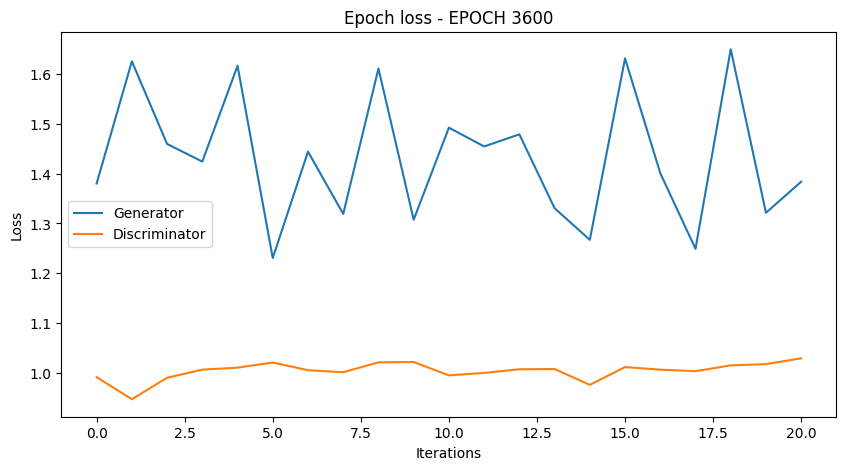

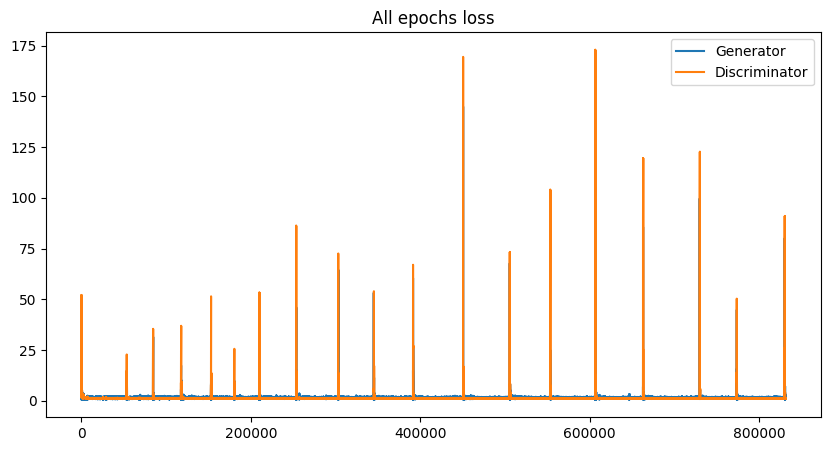

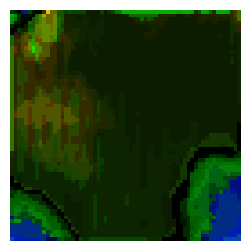

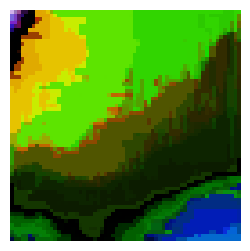

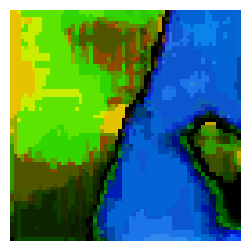

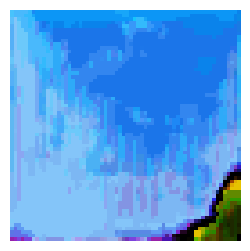

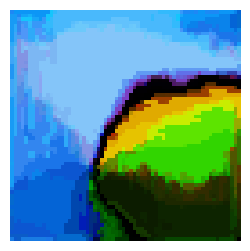

Epoch: 3600 computed for 4.251214504241943 sec
Generator loss mean:  1.4322083  std:  0.13019909
Discriminator loss mean:  1.0039613  std:  0.017536502
Epoch: 3601 computed for 2.8482236862182617 sec
Generator loss mean:  1.5100273  std:  0.33637515
Discriminator loss mean:  1.0235198  std:  0.04239257
Epoch: 3602 computed for 2.852064609527588 sec
Generator loss mean:  1.4839014  std:  0.34376785
Discriminator loss mean:  1.0305154  std:  0.032983504
Epoch: 3603 computed for 2.8410158157348633 sec
Generator loss mean:  1.470075  std:  0.27517077
Discriminator loss mean:  1.0254294  std:  0.027975846
Epoch: 3604 computed for 2.820148468017578 sec
Generator loss mean:  1.4579558  std:  0.23395759
Discriminator loss mean:  1.0061398  std:  0.030046541
Epoch: 3605 computed for 2.8162903785705566 sec
Generator loss mean:  1.450341  std:  0.25508195
Discriminator loss mean:  1.014308  std:  0.026780218
Epoch: 3606 computed for 2.8561761379241943 sec
Generator loss mean:  1.4526448  std:  0.

Epoch: 3654 computed for 2.818727493286133 sec
Generator loss mean:  1.4267764  std:  0.12948234
Discriminator loss mean:  0.99761873  std:  0.018434623
Epoch: 3655 computed for 2.814948797225952 sec
Generator loss mean:  1.426285  std:  0.15214537
Discriminator loss mean:  0.99620074  std:  0.016781004
Epoch: 3656 computed for 2.81656551361084 sec
Generator loss mean:  1.4225438  std:  0.17256647
Discriminator loss mean:  1.0089442  std:  0.02110152
Epoch: 3657 computed for 2.8258841037750244 sec
Generator loss mean:  1.4266475  std:  0.17548166
Discriminator loss mean:  1.0010976  std:  0.019908702
Epoch: 3658 computed for 2.8188886642456055 sec
Generator loss mean:  1.4178838  std:  0.16602889
Discriminator loss mean:  0.99784195  std:  0.016271213
Epoch: 3659 computed for 2.8171162605285645 sec
Generator loss mean:  1.440933  std:  0.14271572
Discriminator loss mean:  0.9964132  std:  0.018355949
Epoch: 3660 computed for 2.814481019973755 sec
Generator loss mean:  1.414752  std:  0

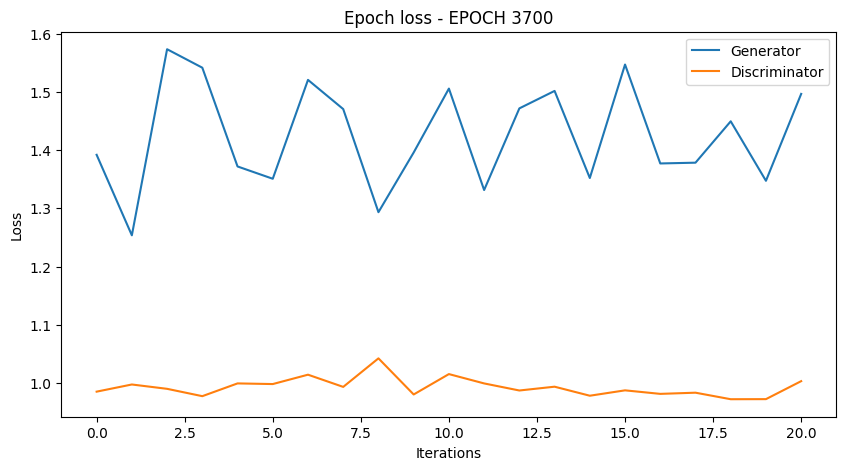

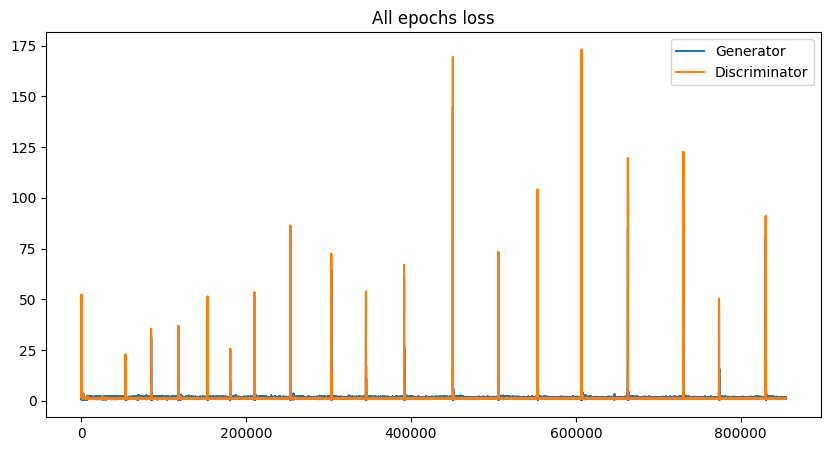

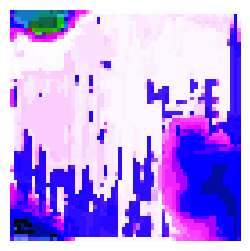

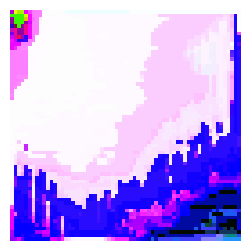

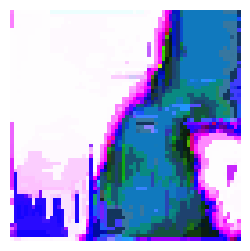

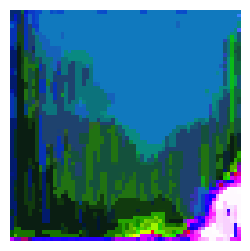

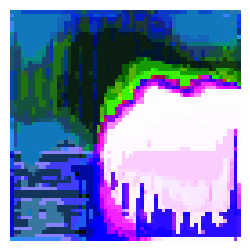

Epoch: 3700 computed for 4.279344797134399 sec
Generator loss mean:  1.424867  std:  0.088271715
Discriminator loss mean:  0.99269694  std:  0.016147658
Epoch: 3701 computed for 2.831393241882324 sec
Generator loss mean:  1.4398005  std:  0.10336057
Discriminator loss mean:  0.993266  std:  0.017389797
Epoch: 3702 computed for 2.8104500770568848 sec
Generator loss mean:  1.4232755  std:  0.13062717
Discriminator loss mean:  0.9946154  std:  0.015558813
Epoch: 3703 computed for 2.81307315826416 sec
Generator loss mean:  1.4347637  std:  0.08091867
Discriminator loss mean:  0.99081486  std:  0.015707044
Epoch: 3704 computed for 2.814645767211914 sec
Generator loss mean:  1.4326584  std:  0.08958127
Discriminator loss mean:  0.9965524  std:  0.014833813
Epoch: 3705 computed for 2.8156604766845703 sec
Generator loss mean:  1.4282733  std:  0.12361788
Discriminator loss mean:  0.9969181  std:  0.01274539
Epoch: 3706 computed for 2.8166990280151367 sec
Generator loss mean:  1.4172503  std:  

In [ ]:
dcgan.train(
    dataset,
    generator, 
    discriminator,
    epochs=5000,
    save_every_x_results=100)

### 6. Evaluating trainging progress

As you can see in the output above, each training epoch runs for a few seconds (at least for the initial configuration). For each epoch a *loss* value is computed for both the generator and discriminator. This value is a measure of how far off from the truth the network is when making a prediction. A lower value means the prediction is better. The loss value is what is fed back from one iteration to the next to enable learning of the neural network weights. The loss value is fed into an *optimizer* function that calculates how the weights should be adjusted for the network to improve. How the optimizer works is beyond the scope of this excercise. The loss values are easier to reason about here. If you are able to run a successfull training session for long enough, you will see in the *All epochs loss* graph how the loss values go up and down all the time but starts stabilizing at different levels after some number of iterations. When training for example an image object detection network for detecting different animals, you will see the loss value decrease to a more stable low number, with less variance. But when training a GAN the loss values will keep fluctuating. This is because the generator and discriminator keep competing and influencing each others loss function.

How do you know training is complete? You don't! You'll have to watch the output and decide when you think the results stop improving. You should also interupt training if the DCGAN doesn't seem to learn anything and the generator keeps generating random noise images.

### 7. Try different hyperparameters

Now go back to the code cell where we defined hyperparameters. Change some values, run all code cells again, and see if you can improve the results. There are plenty articles on the web that can guide you to hyperparameter settings for stable training of a DCGAN. If you know Python programming you can make a copy of the dcgan utility script and see if you can do any changes to the code to improve your results.